# Classical ML on OCD classification

## Import Required Modules

In [1]:
%load_ext autoreload
%autoreload 2

## Import System tools

In [2]:
import os
import sys
import gc
import cProfile
import warnings

In [3]:
current_dir = os.getcwd()
helpers = os.path.join(current_dir, "helpers")
sys.path.insert(0,helpers)

## Importing libraries

In [4]:
from enum import Enum, IntEnum
import itertools
from collections import Counter
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as markers
import seaborn as sns
import json
import pickle
from tabulate import tabulate
from logger import logger
import directory_manager as dm
import object_manager as om
import data_structures as ds
import df_manager as dfm
from data_model import Metrics, CSVHeader,HandWashingType
import plotter
import sampler
import random
import re

2023-09-02 01:57:43 - INFO - Logger Created.


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, matthews_corrcoef,average_precision_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import RobustScaler, MinMaxScaler

## Setup

In [6]:
warnings.filterwarnings("ignore")

In [7]:
dm.generate_name("")

'2023-09-02_01-57-44'

In [8]:
logger.info("Running Notebook.")

2023-09-02 01:57:44 - INFO - Running Notebook.


## Global Variables

In [ ]:
# Load lists of csv files
data_folder = "features"
personalized_subject = "03"
csv_files = dm.get_files_names(dm.get_data_dir(data_folder))
grouped_files = ds.group_by_subjects(csv_files)
subjects = [key for key in grouped_files.keys()]
print(f"Total Subjects:{len(subjects)}")

subjects.remove(personalized_subject)
total_subjects = len(subjects)
print(f"Personalized Subject:{personalized_subject}")

random.seed(52)
random.shuffle(subjects)
print(f"Shuffled:{subjects}")
total_train = 0.3
train_sub_ids = subjects[:int(total_train*total_subjects)]
inference_sub_ids = set(subjects)-set(train_sub_ids)

print(f"Train_set:{train_sub_ids}")
print(f"Inference_set:{inference_sub_ids}")

### Data

In [10]:
data_folder = "features"#"stats" #"OCDetect_Export"
csv_files = dm.get_files_names(dm.get_data_dir(data_folder))

In [26]:
r = re.compile("acc*")
cols = list(filter(r.match,df.columns.tolist()))

cols = ["acc x__median"]
cols= ["acc x__standard_deviation","acc x__root_mean_square"]
#cols =        ["acc x__skewness","acc x__kurtosis"]

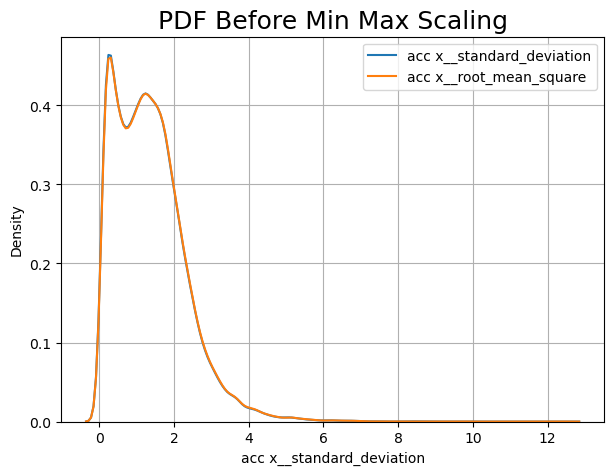

In [27]:
plotter.pdf(df,cols)

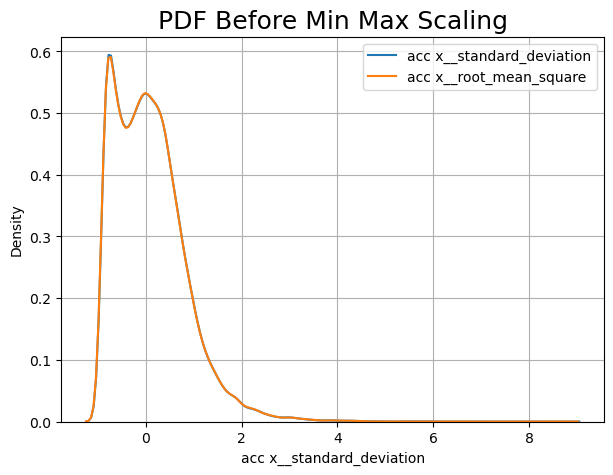

In [37]:
plotter.pdf(df_scaled,cols)

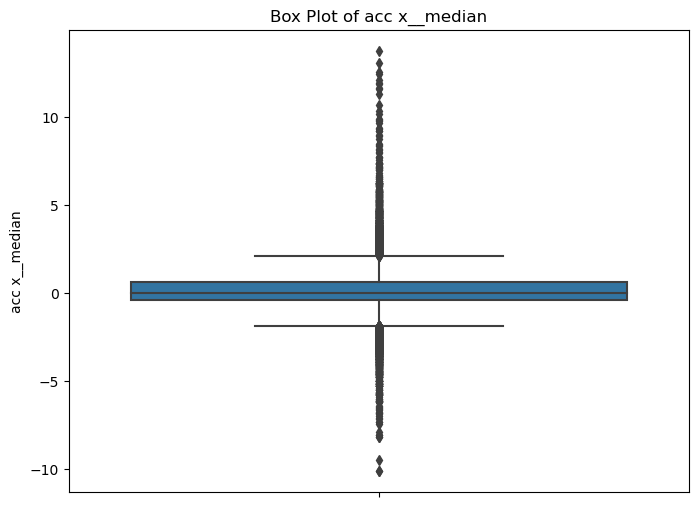

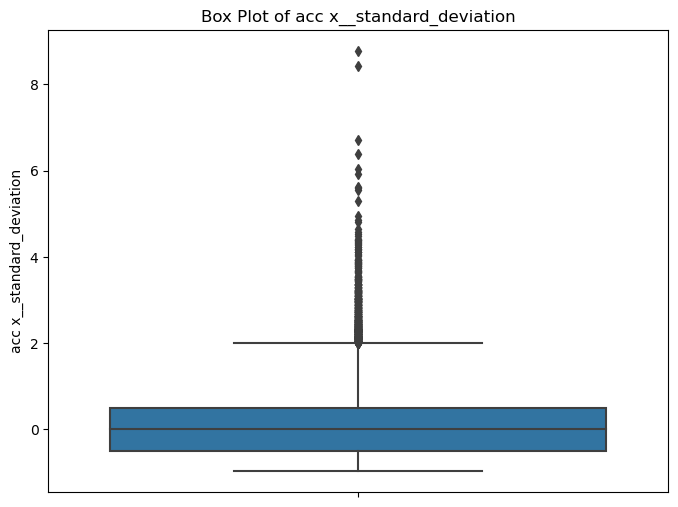

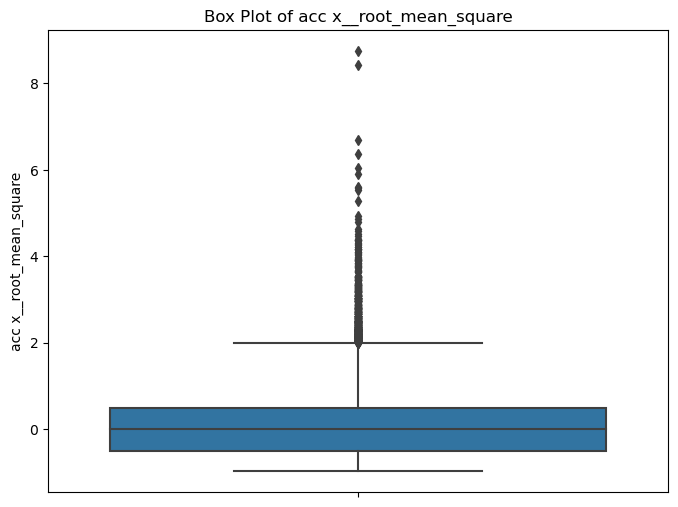

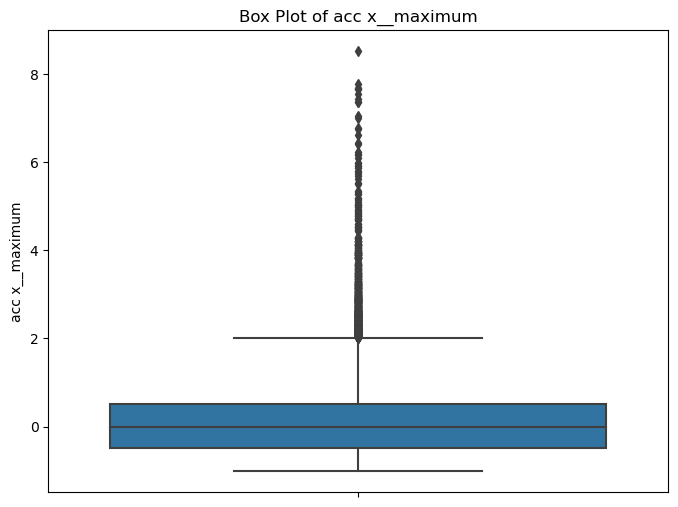

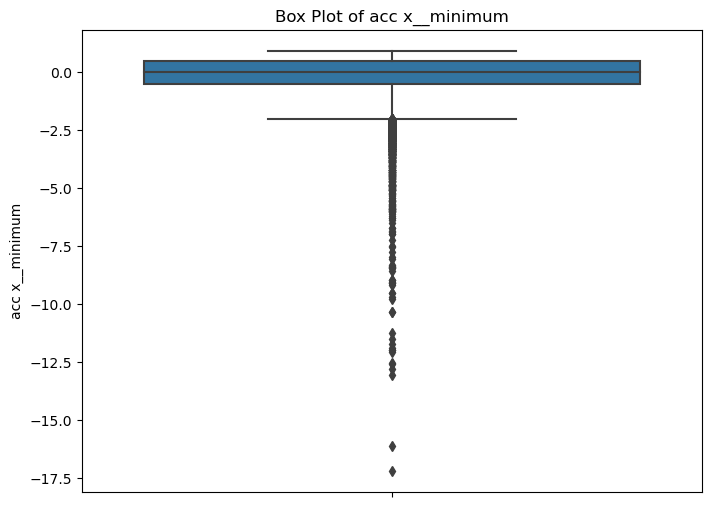

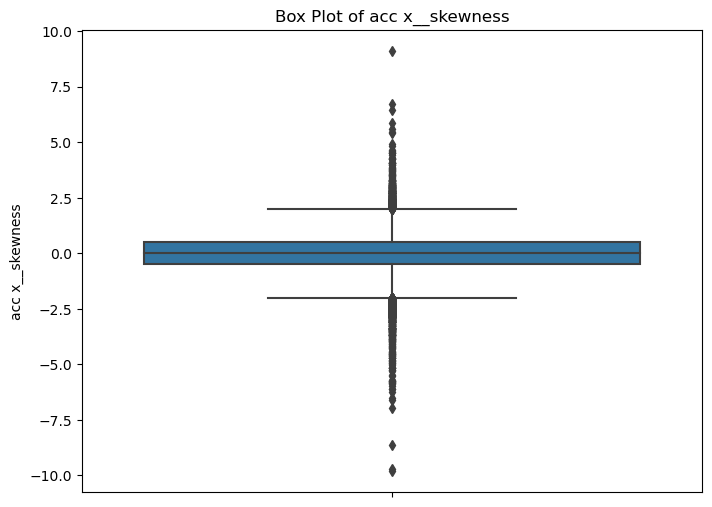

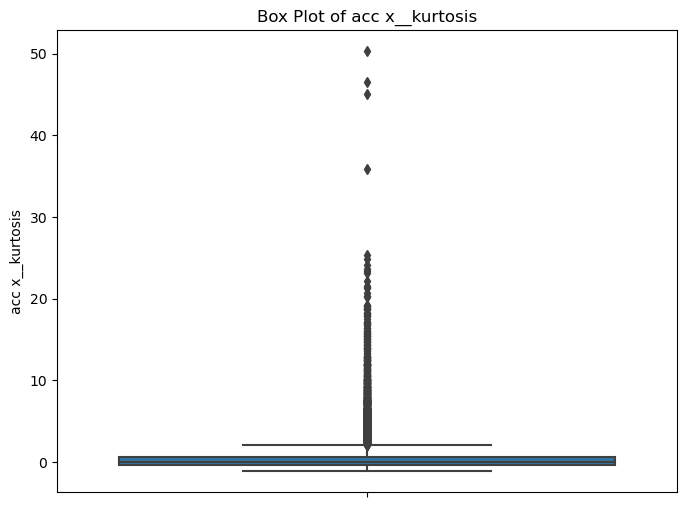

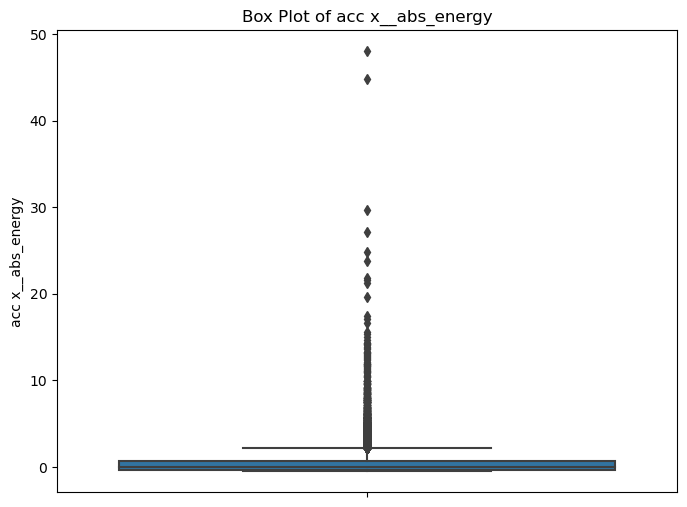

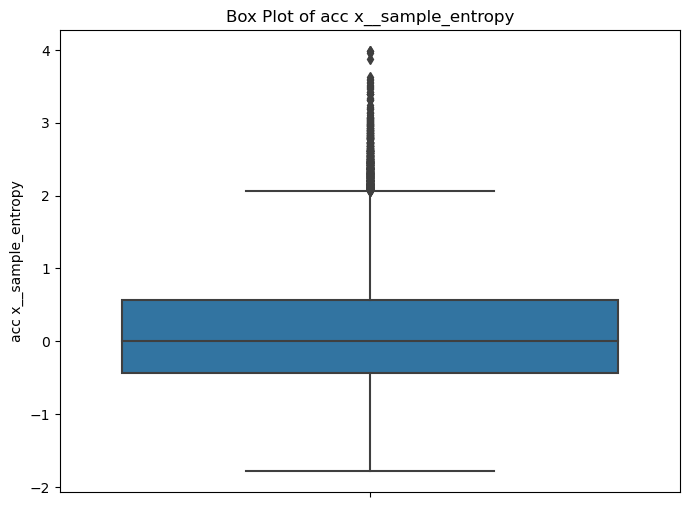

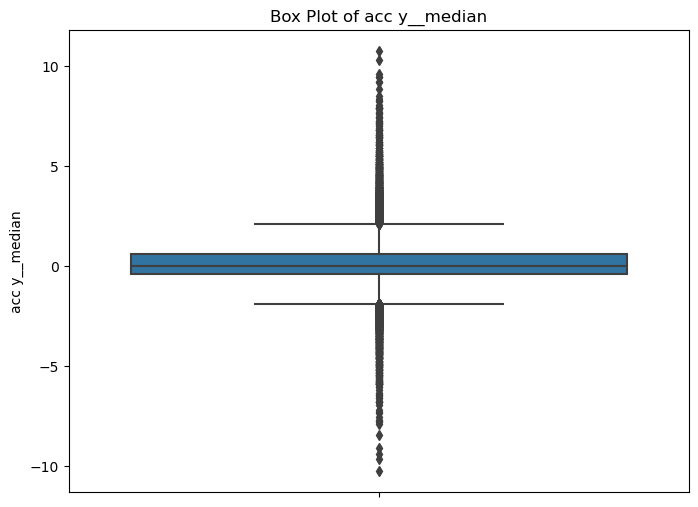

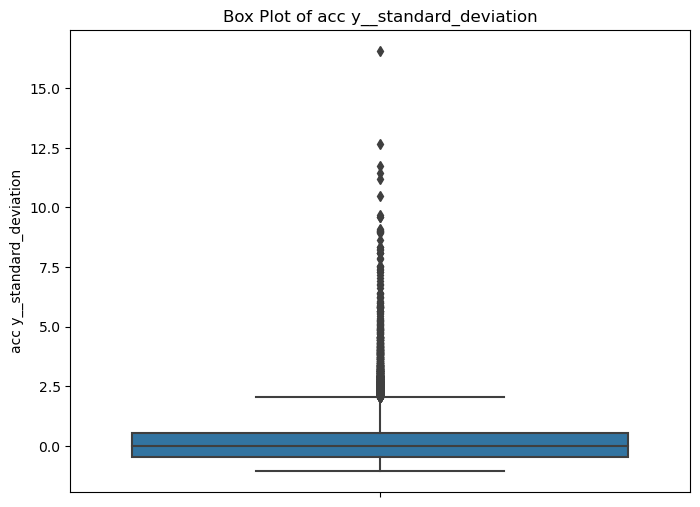

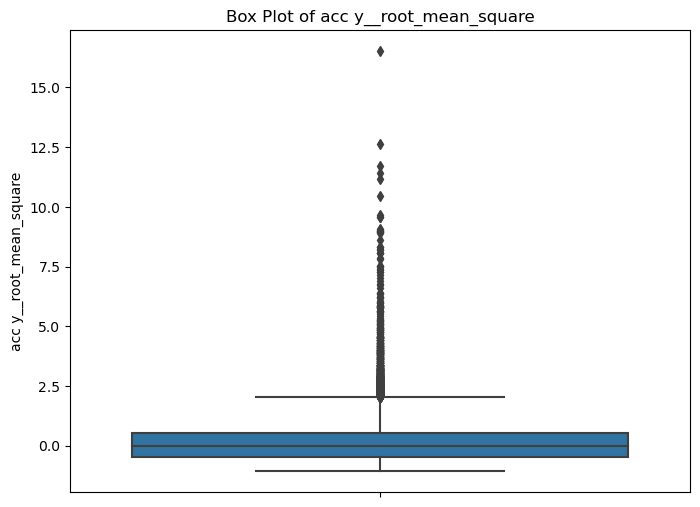

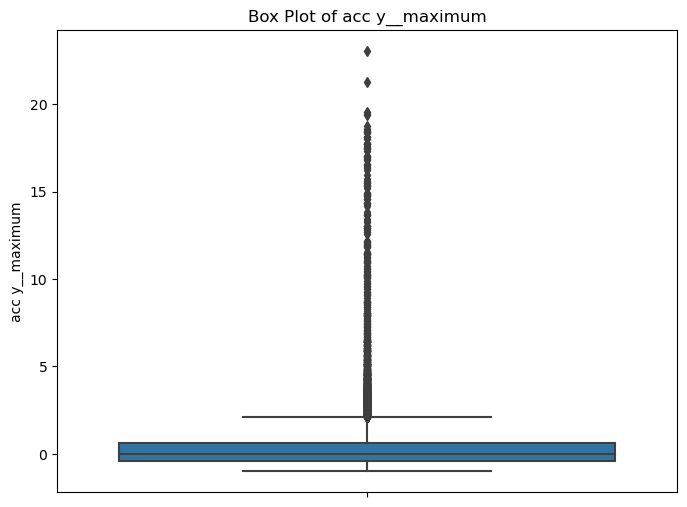

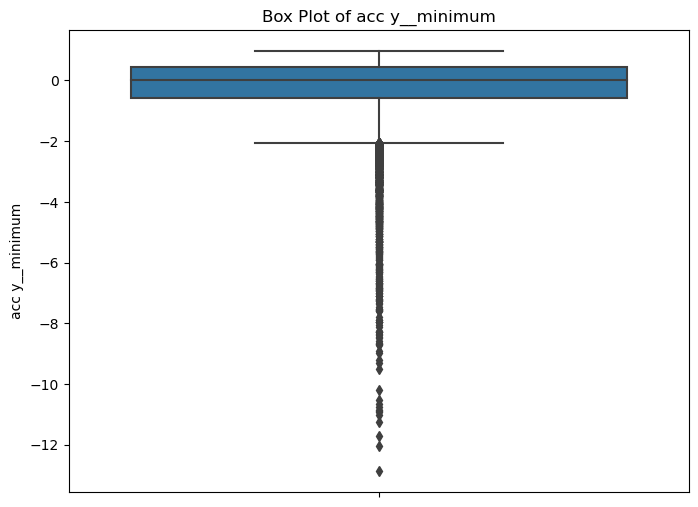

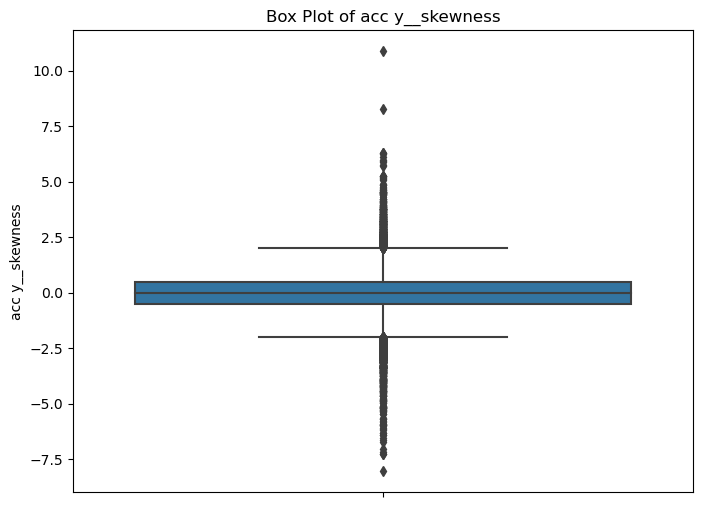

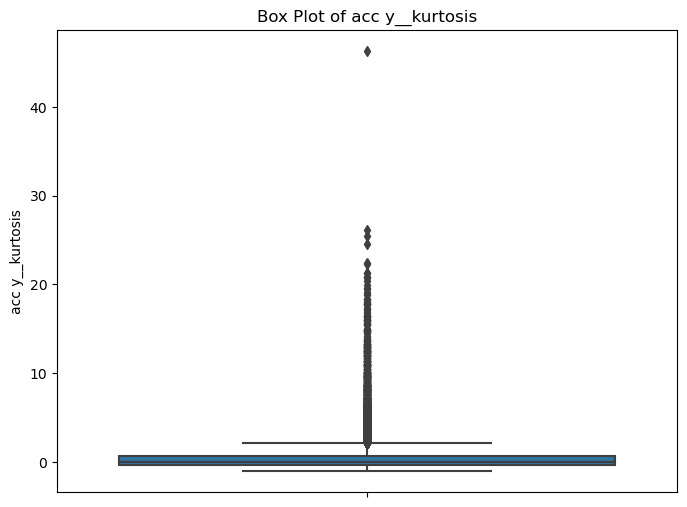

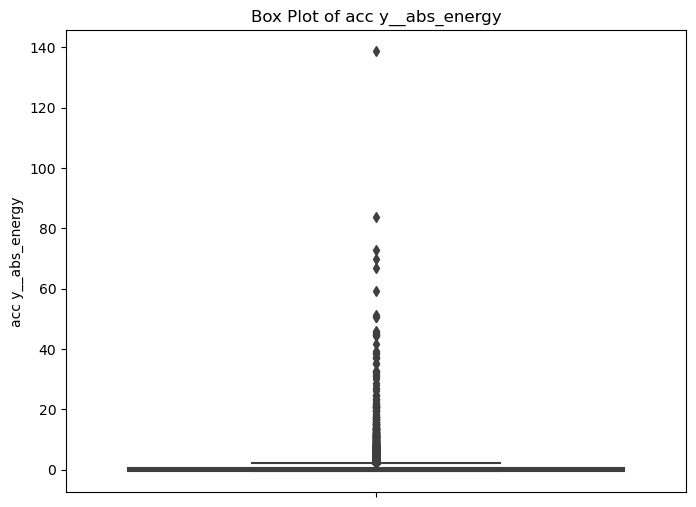

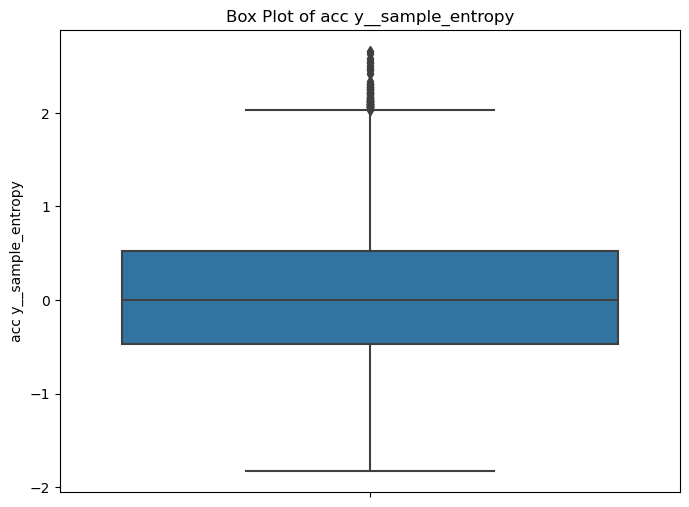

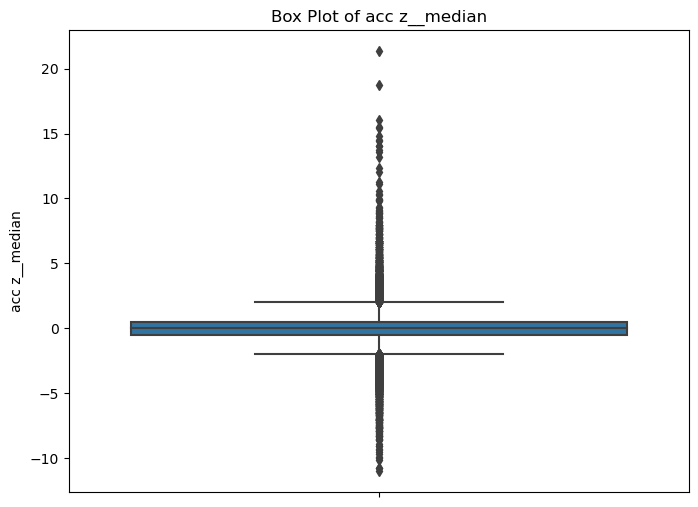

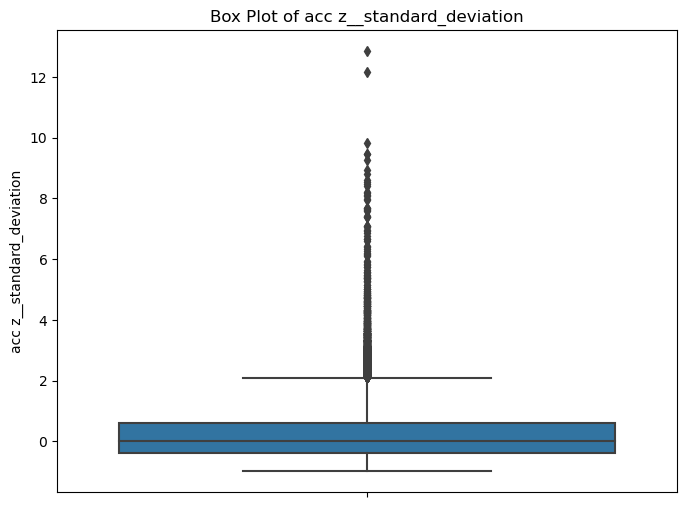

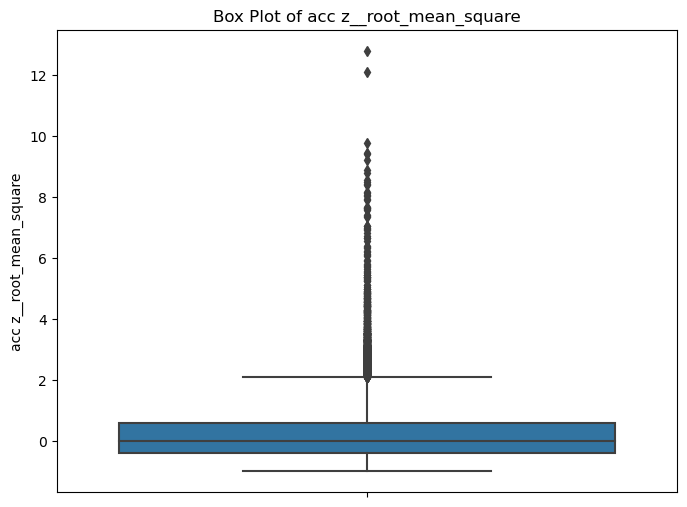

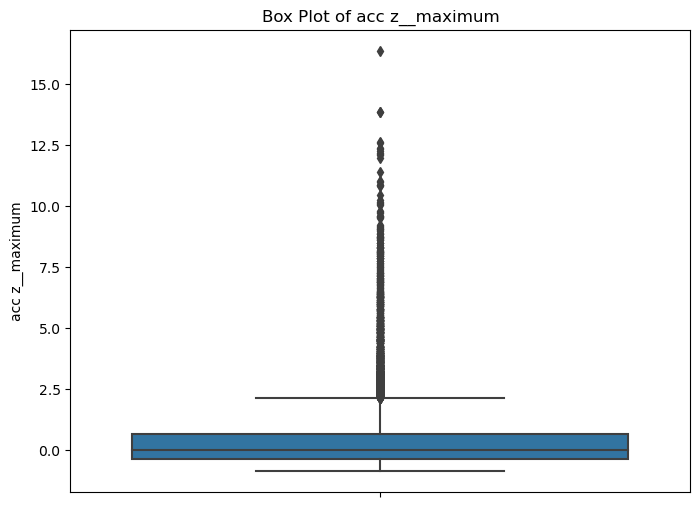

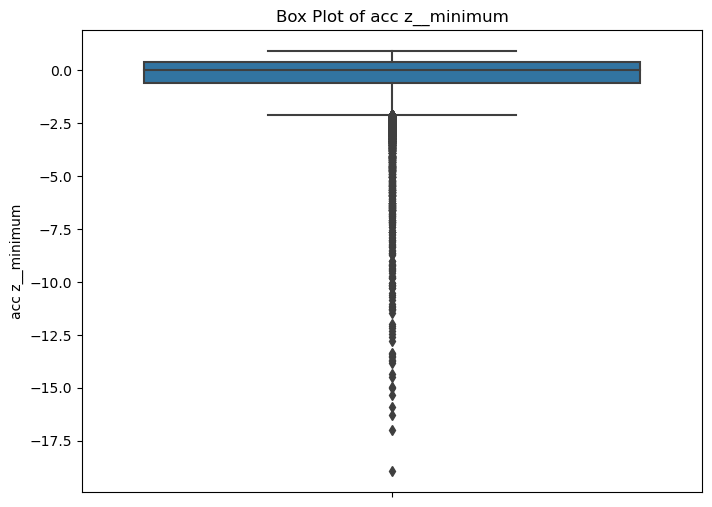

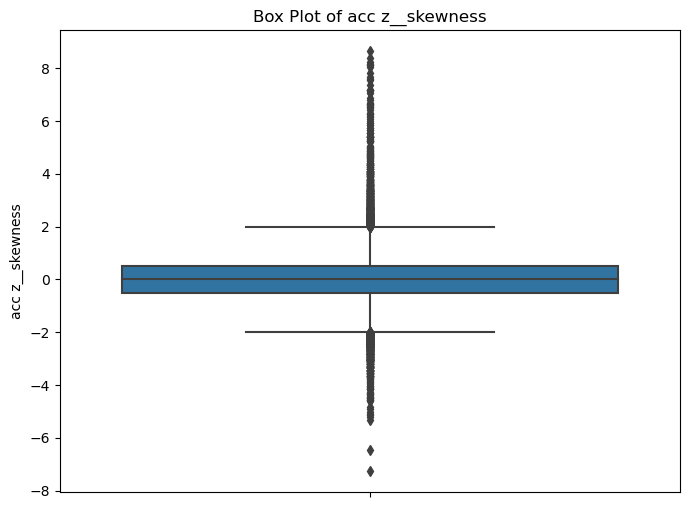

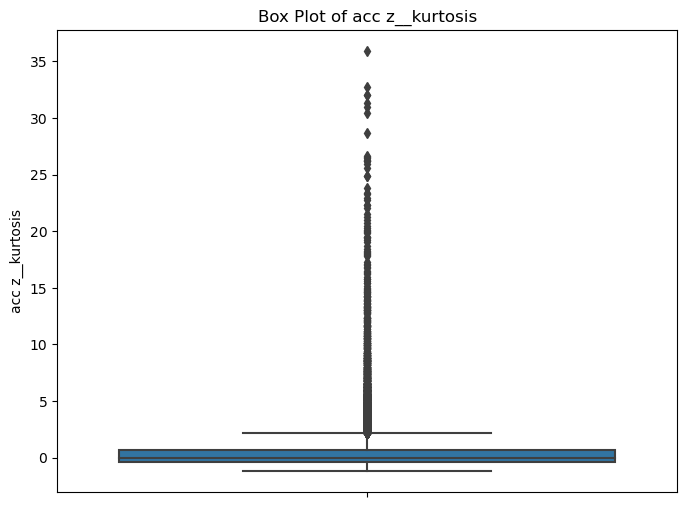

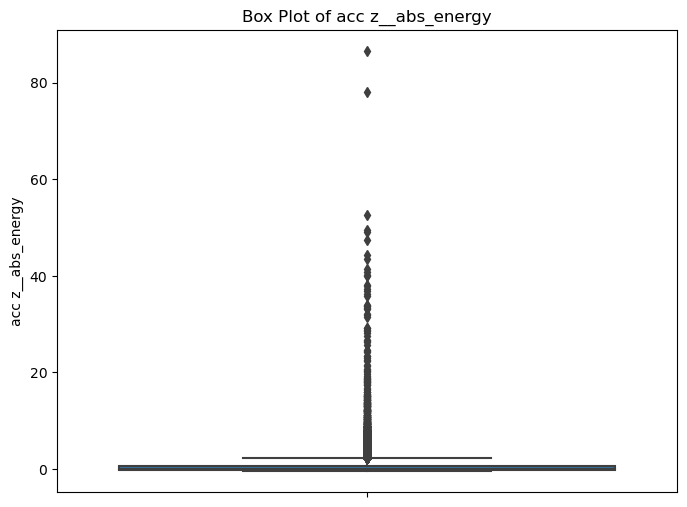

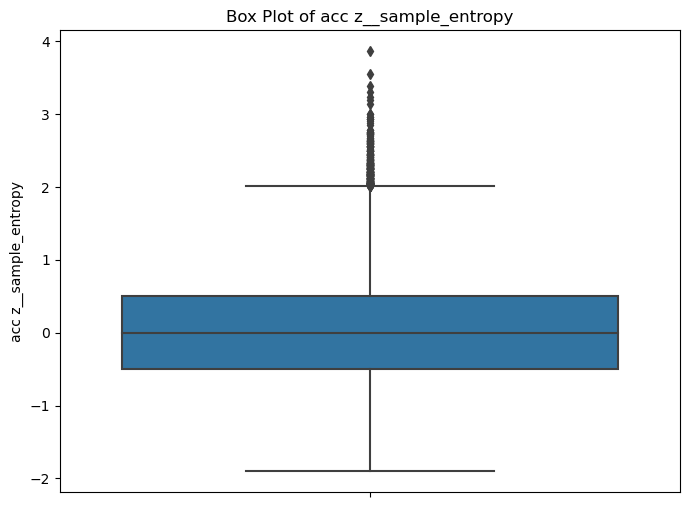

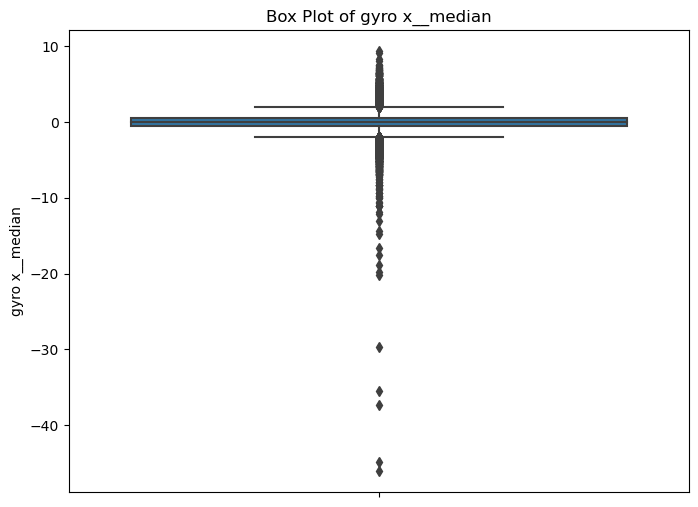

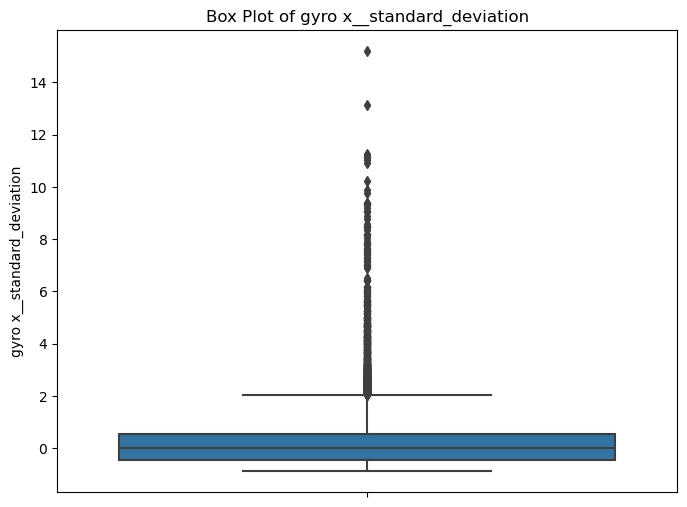

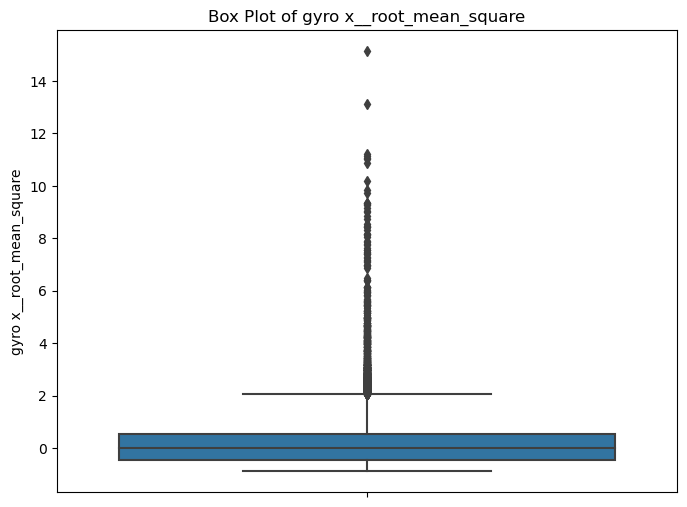

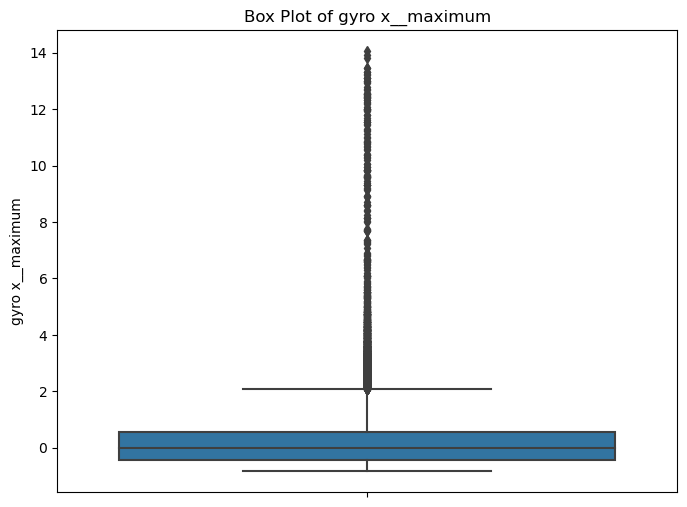

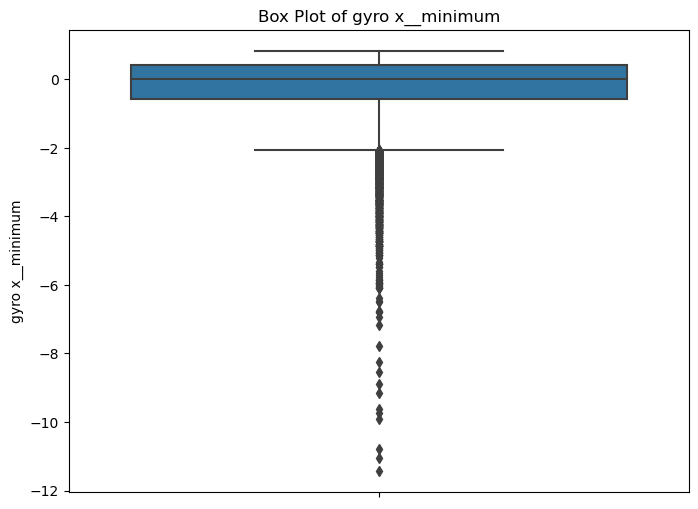

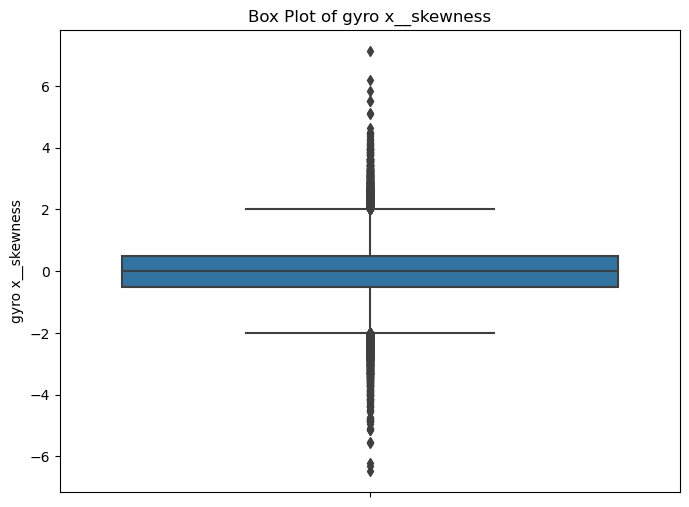

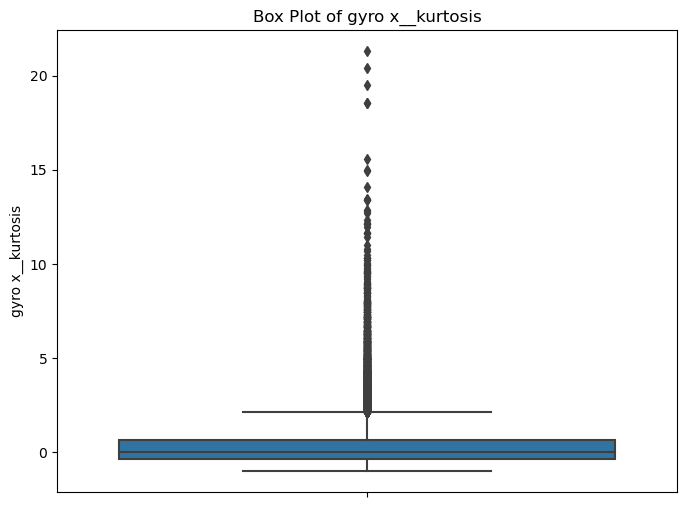

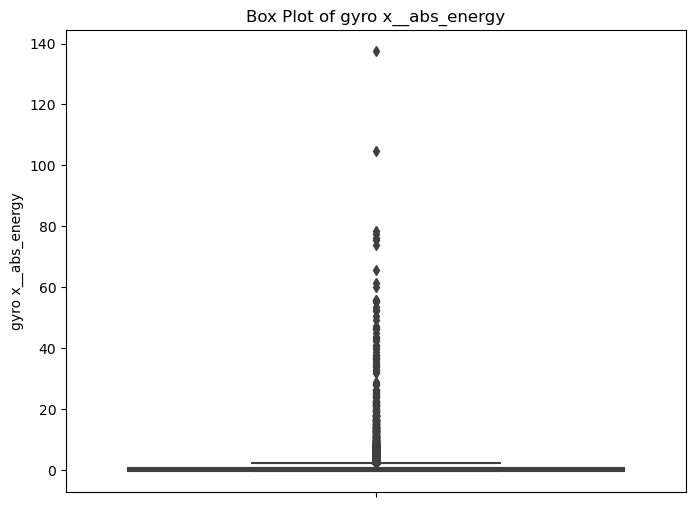

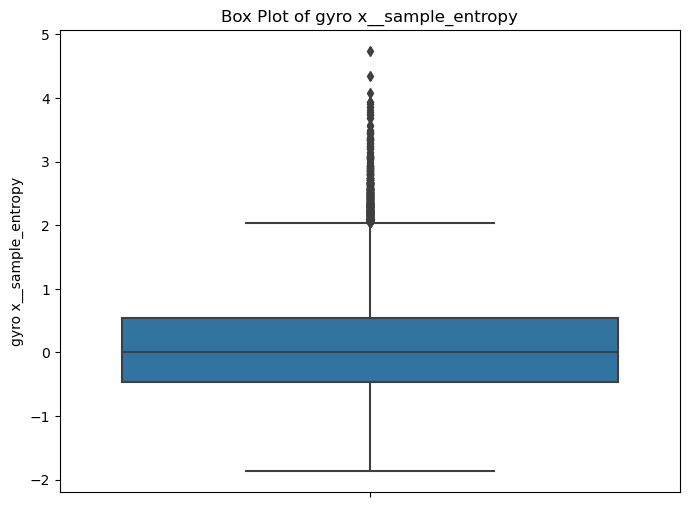

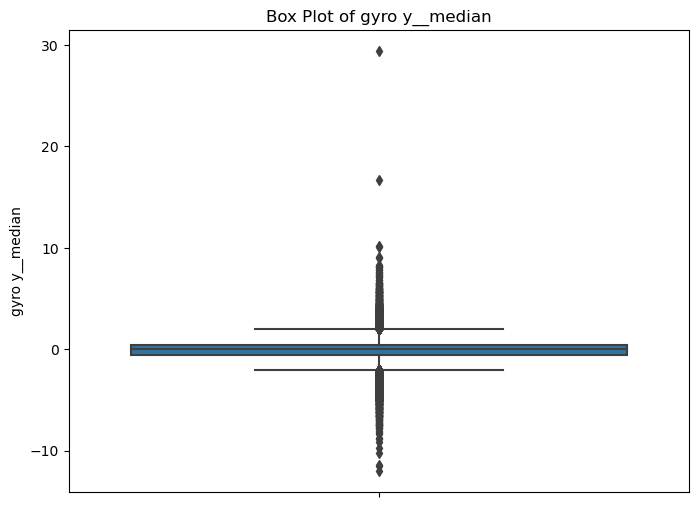

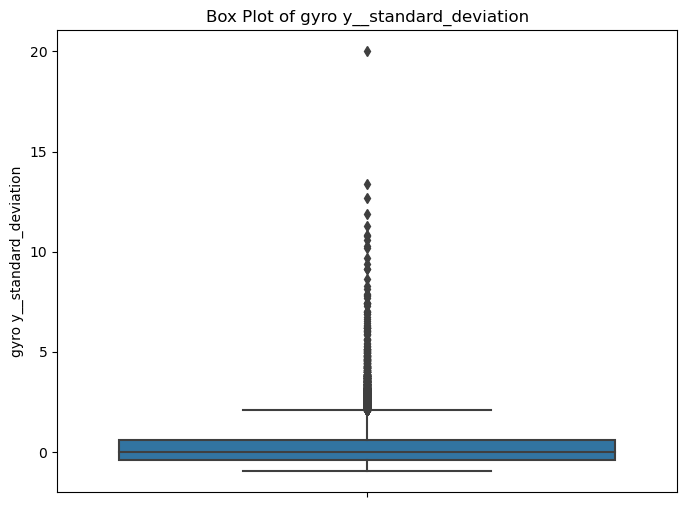

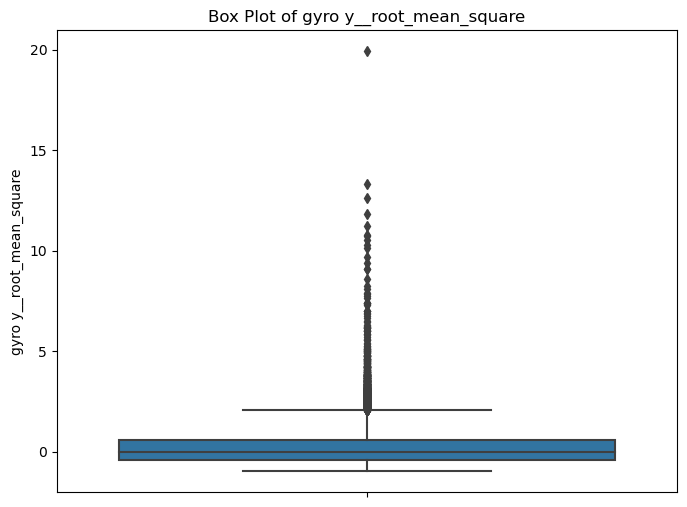

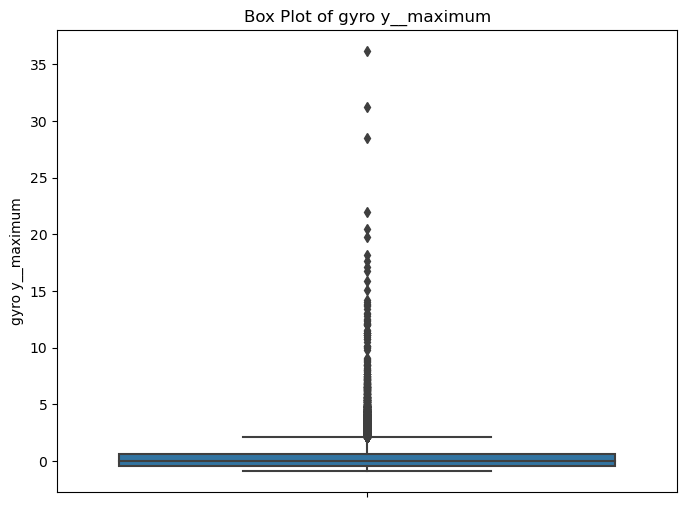

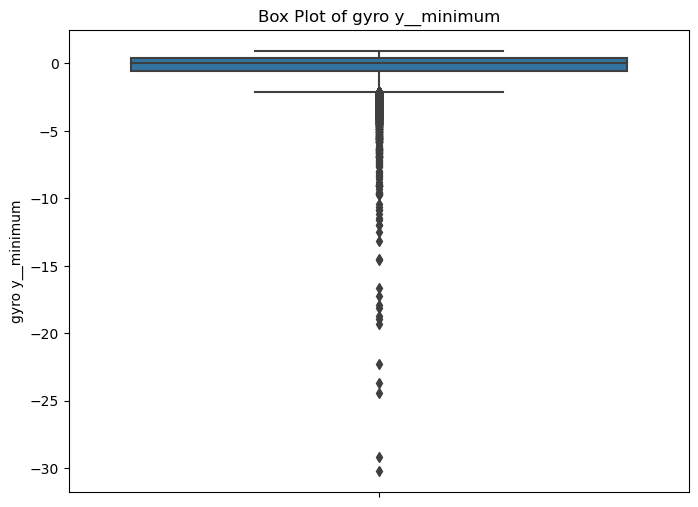

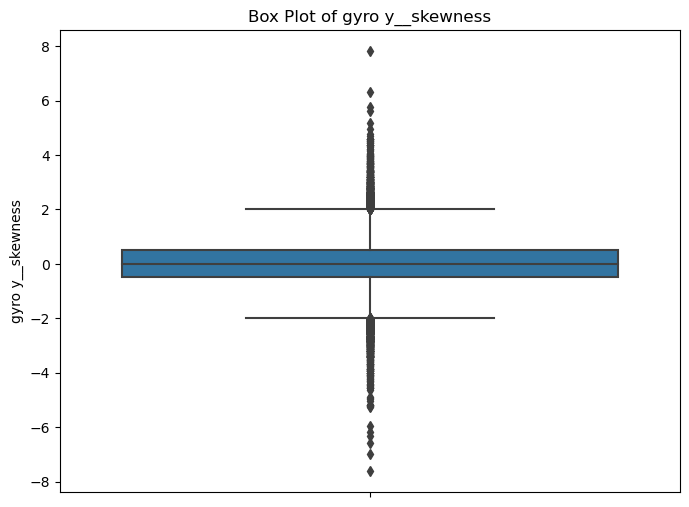

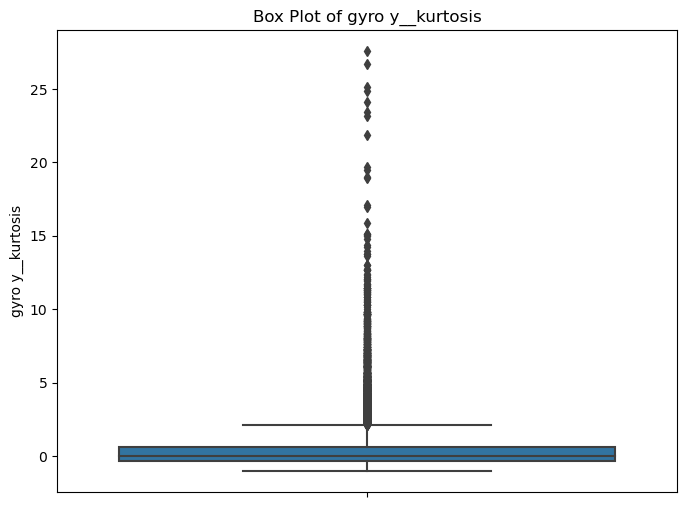

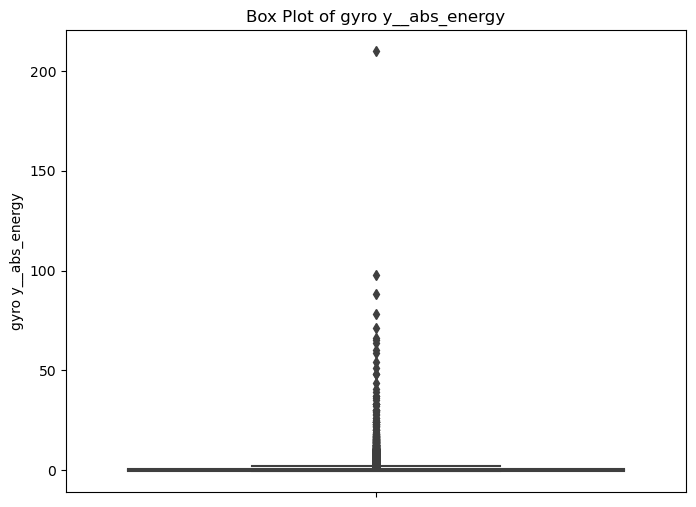

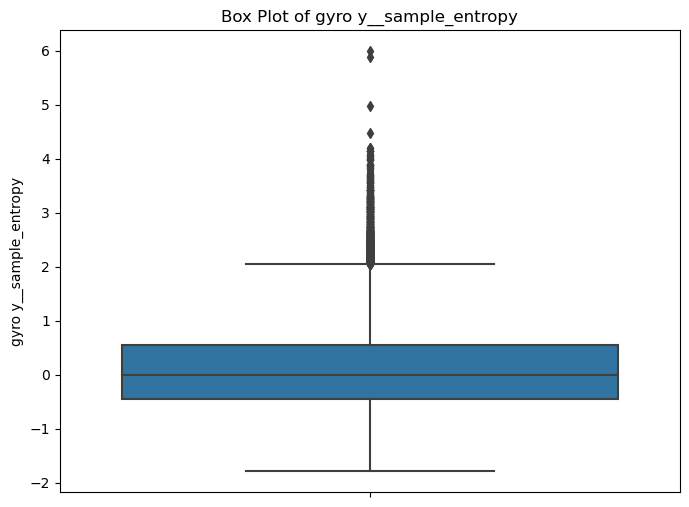

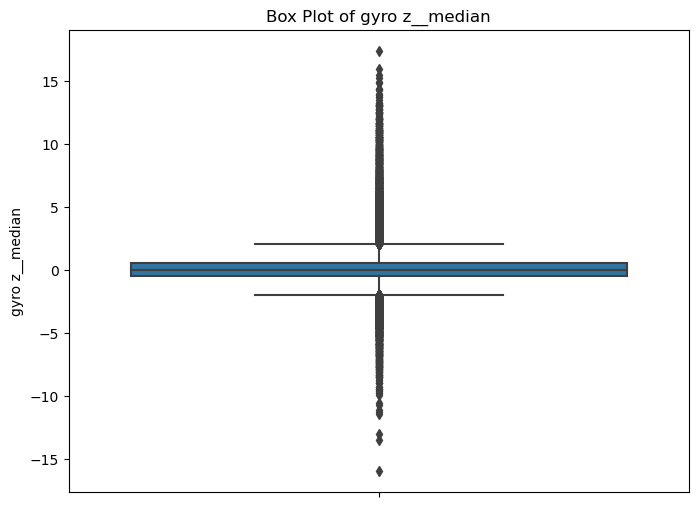

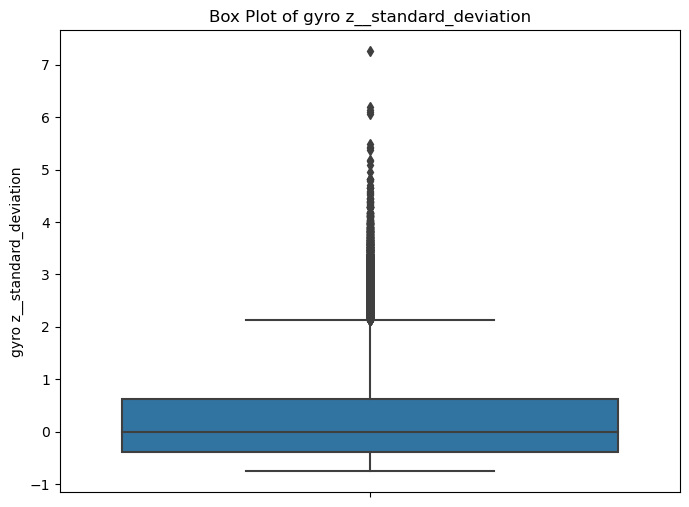

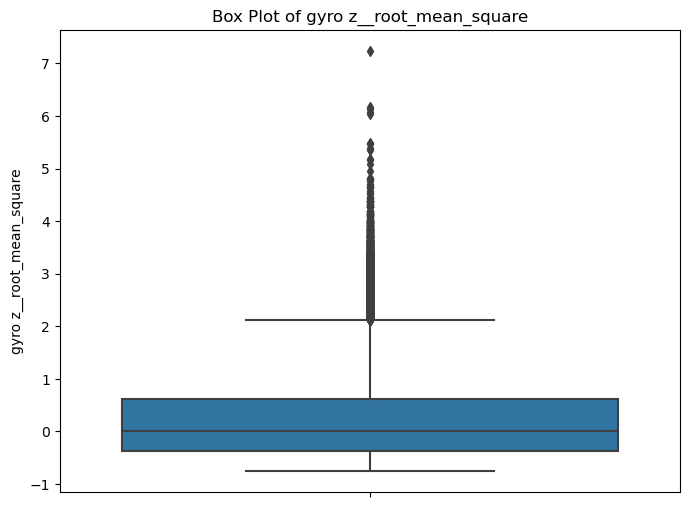

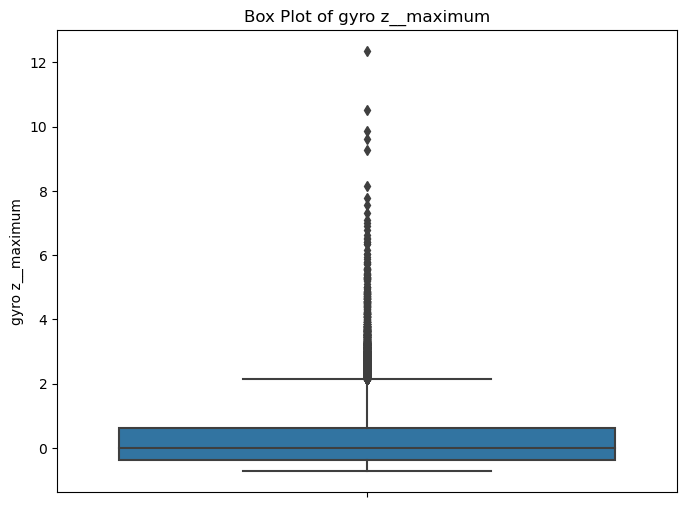

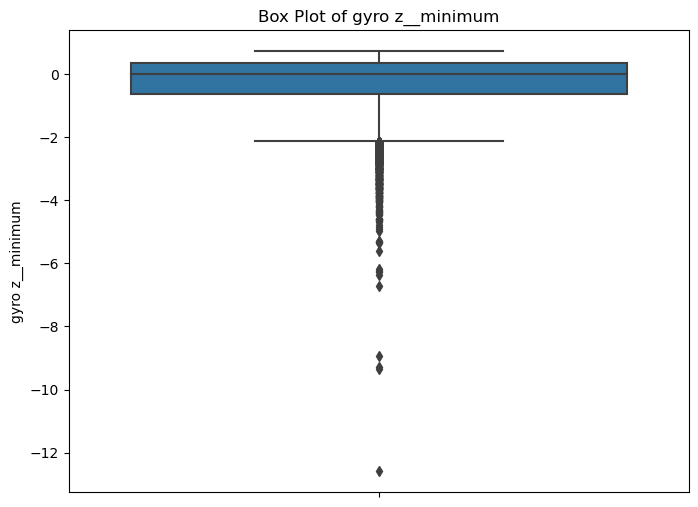

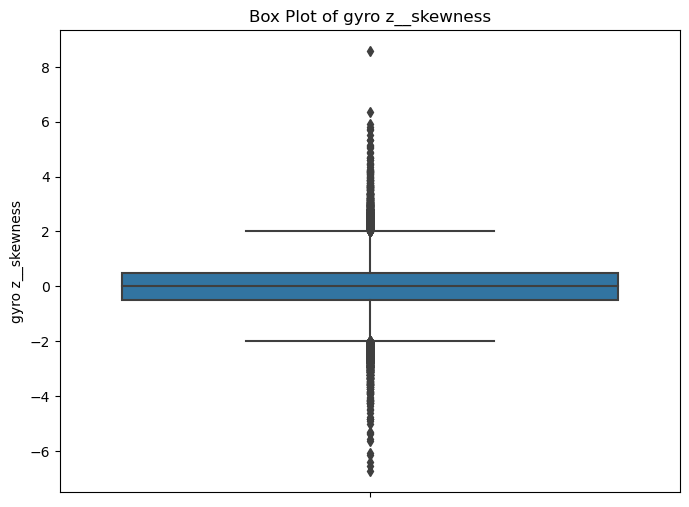

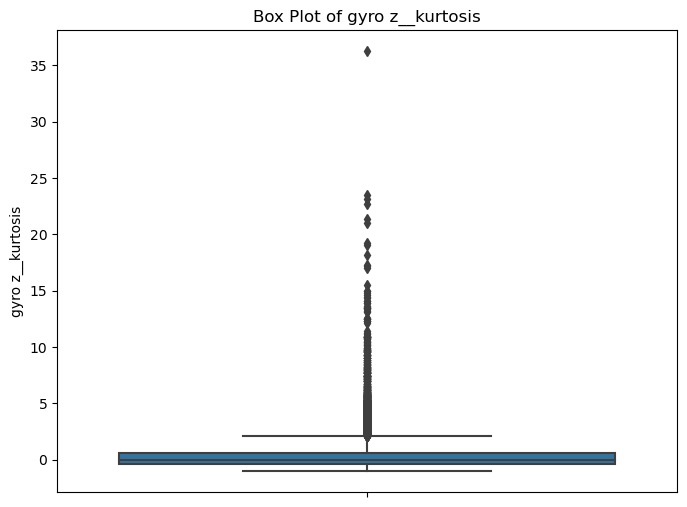

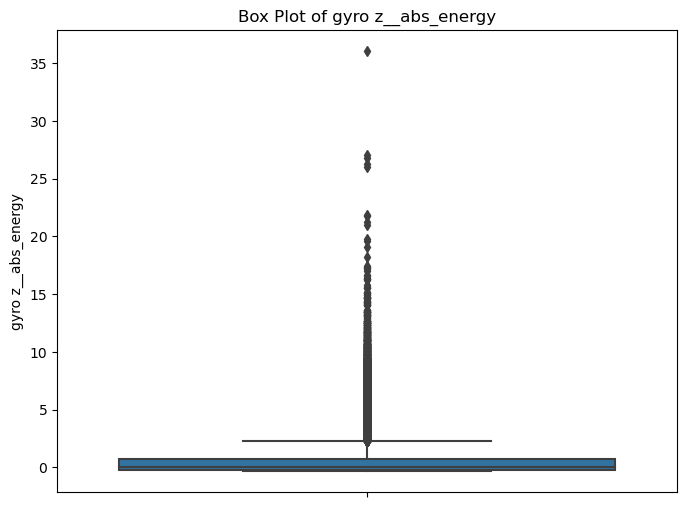

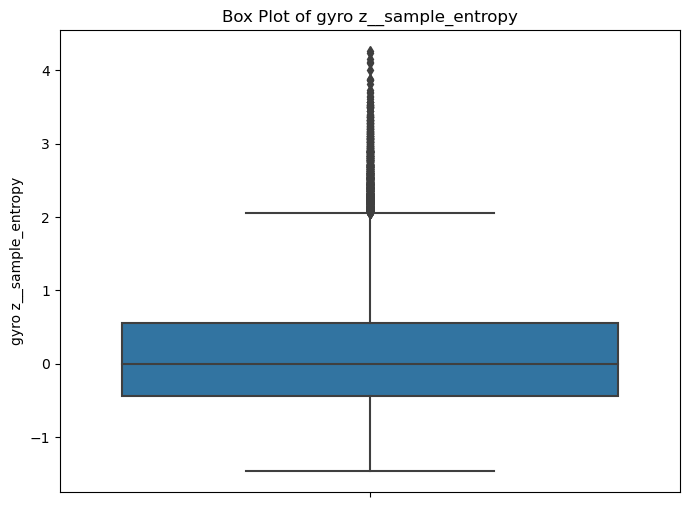

In [42]:
columns = df.columns.tolist()[:-1]
for feature in columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_scaled, y=feature)
    plt.title(f'Box Plot of {feature}')
    plt.show()

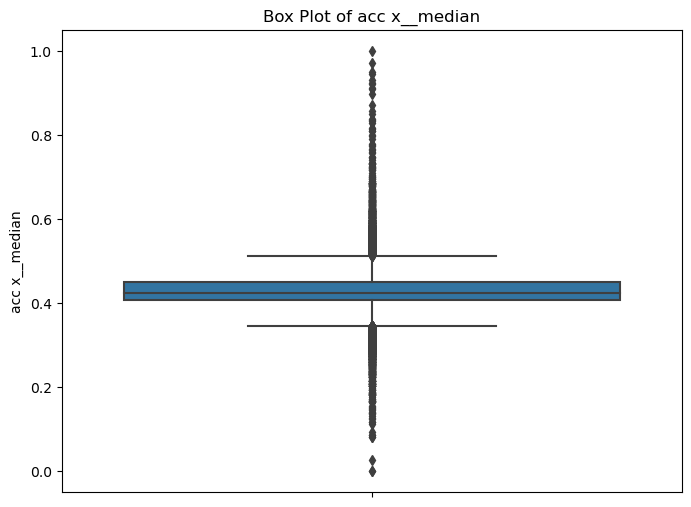

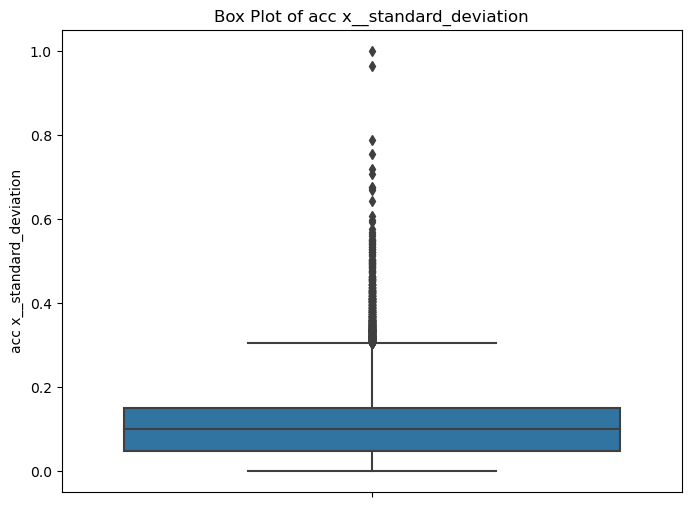

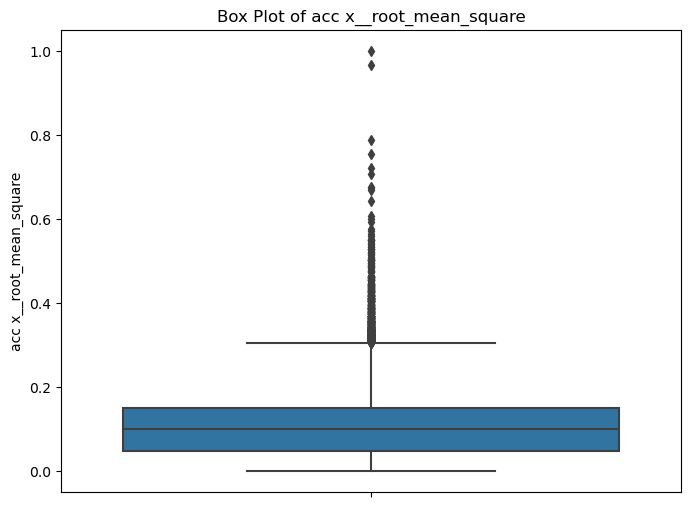

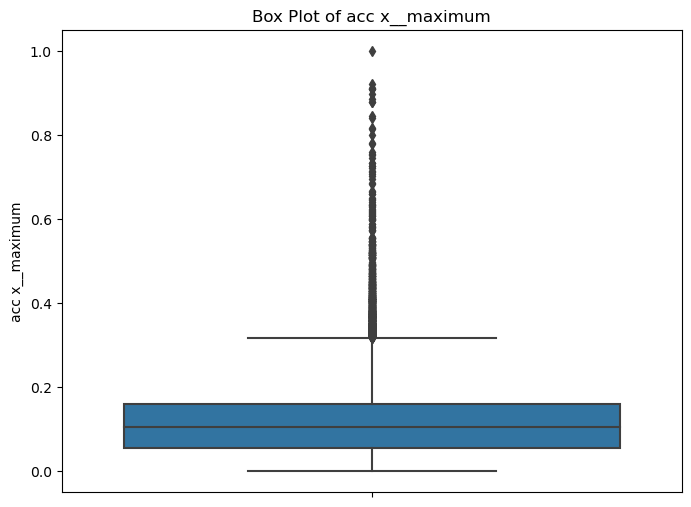

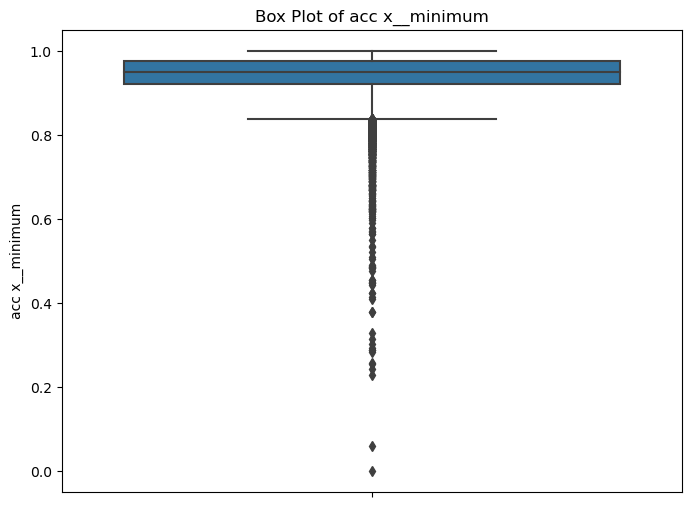

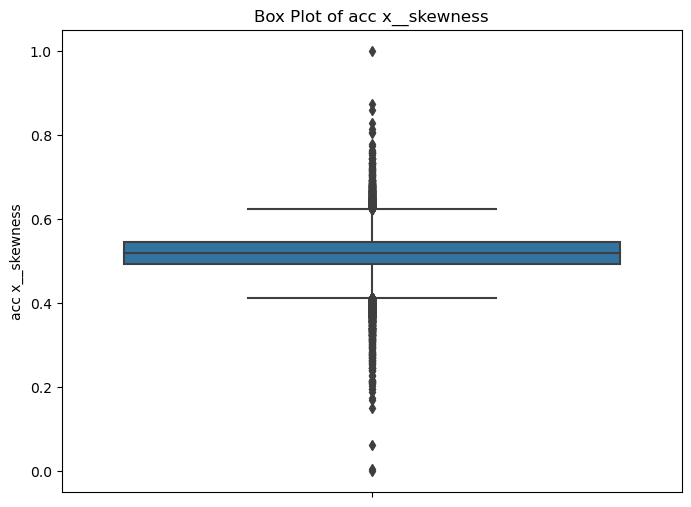

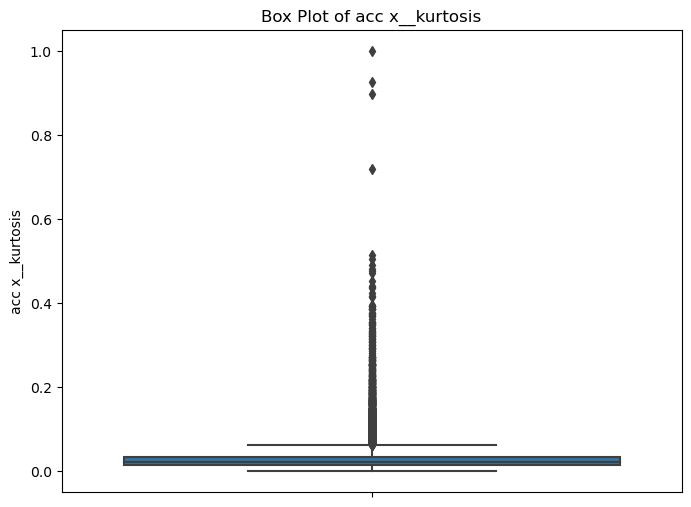

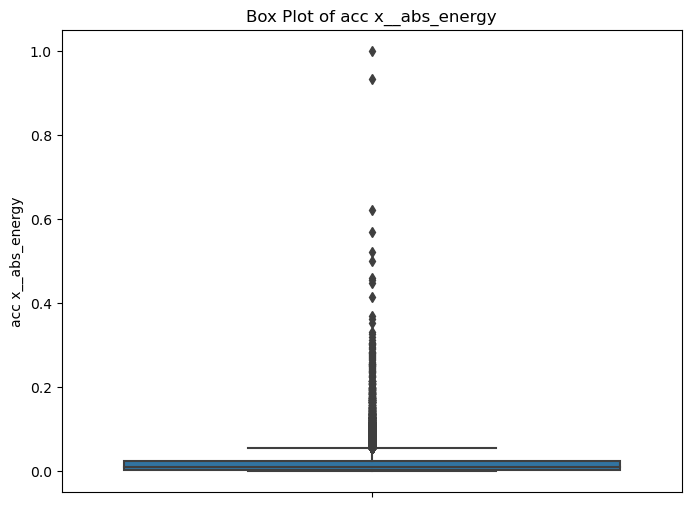

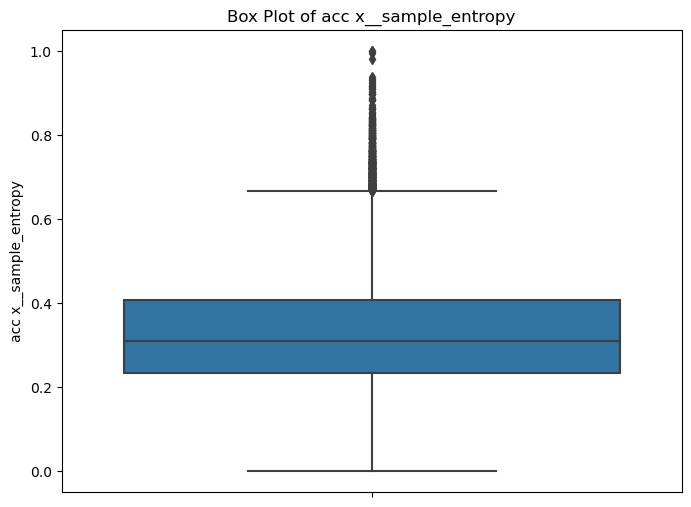

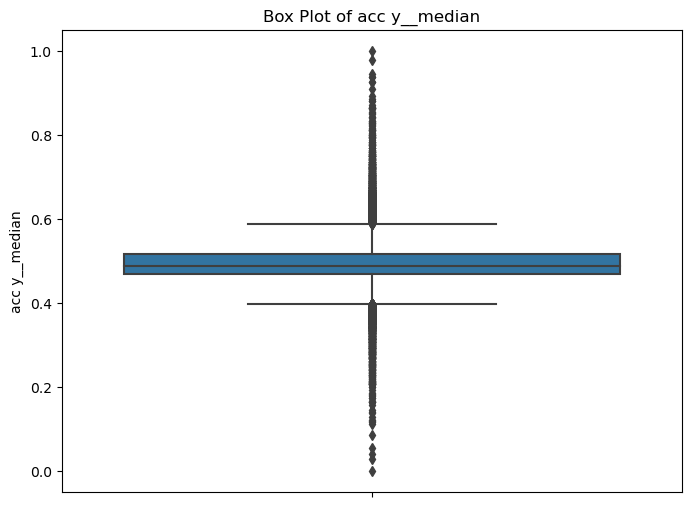

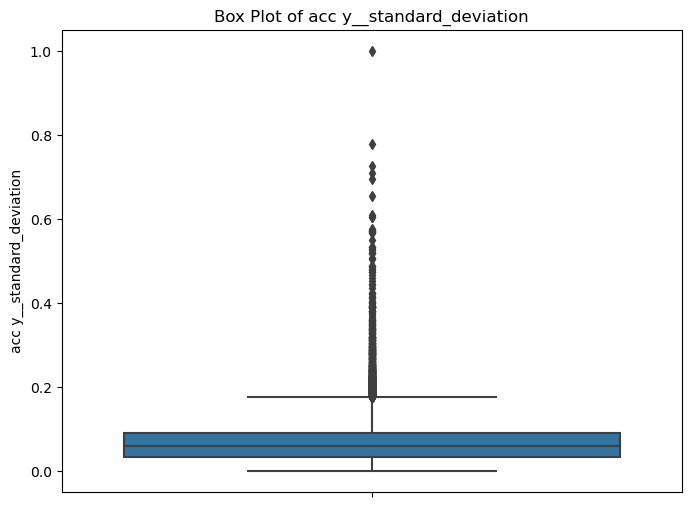

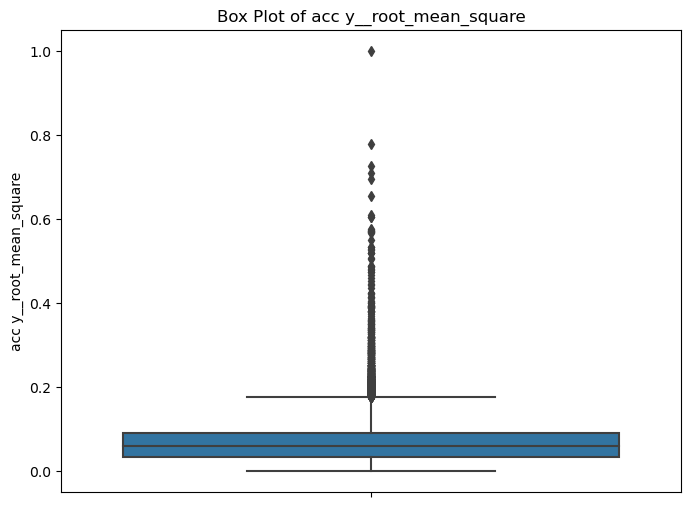

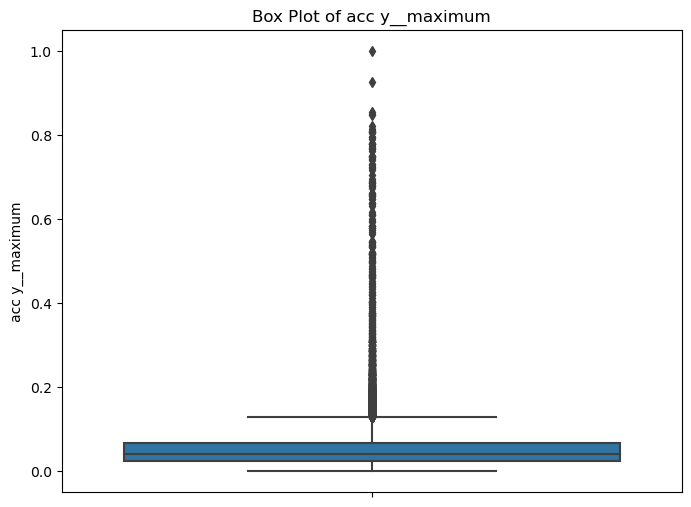

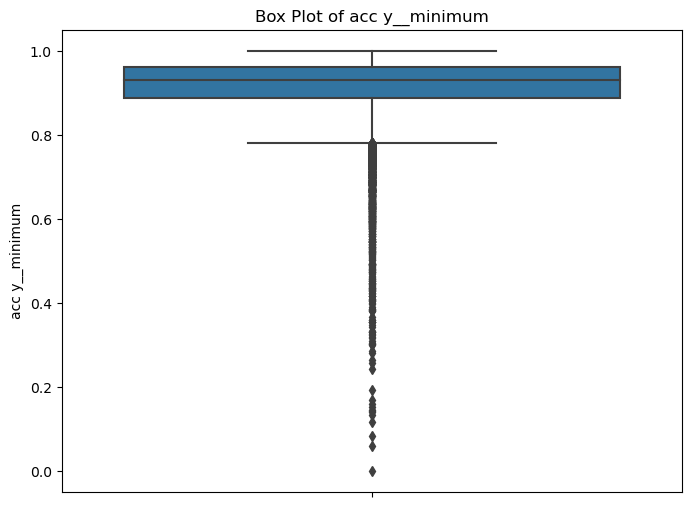

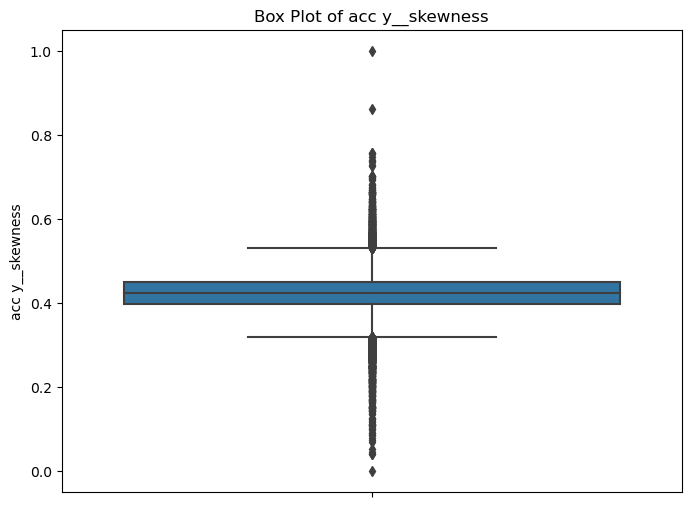

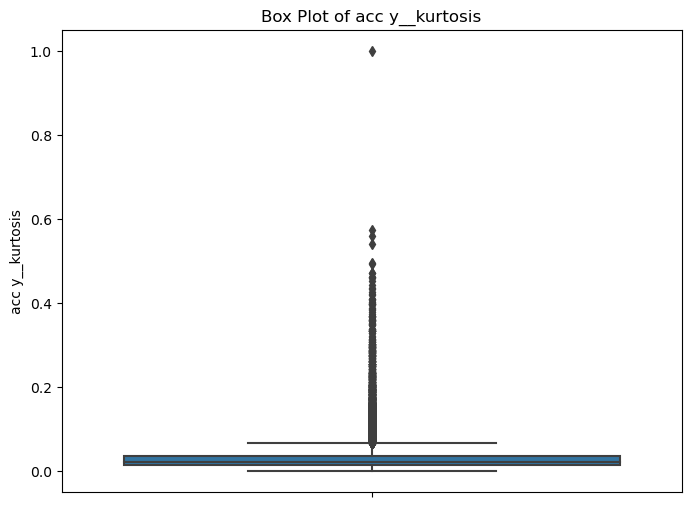

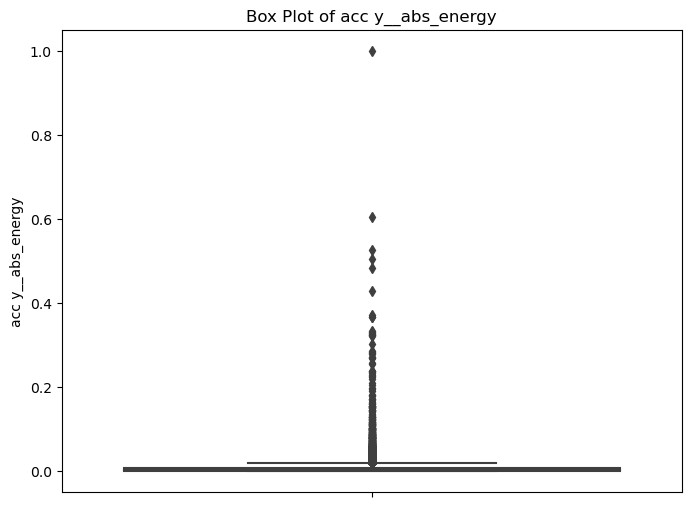

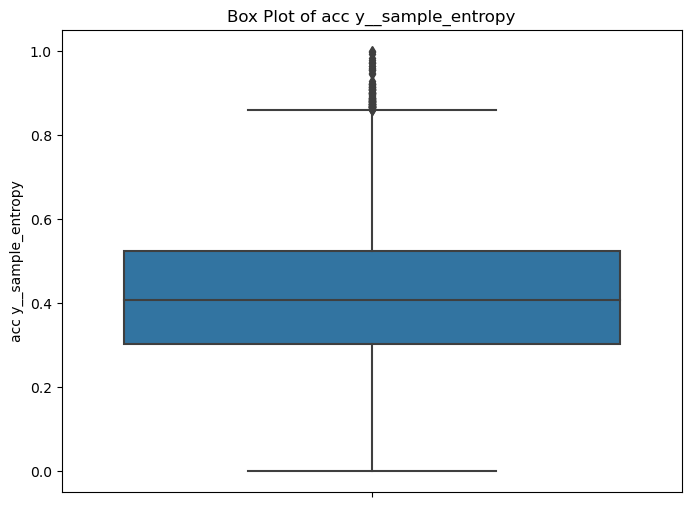

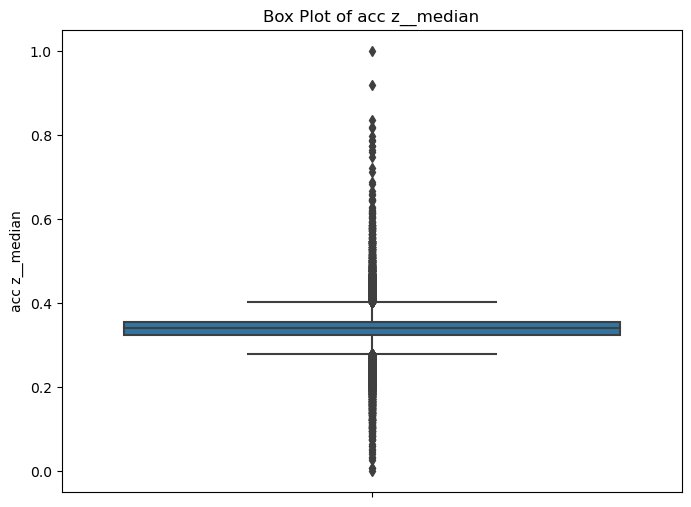

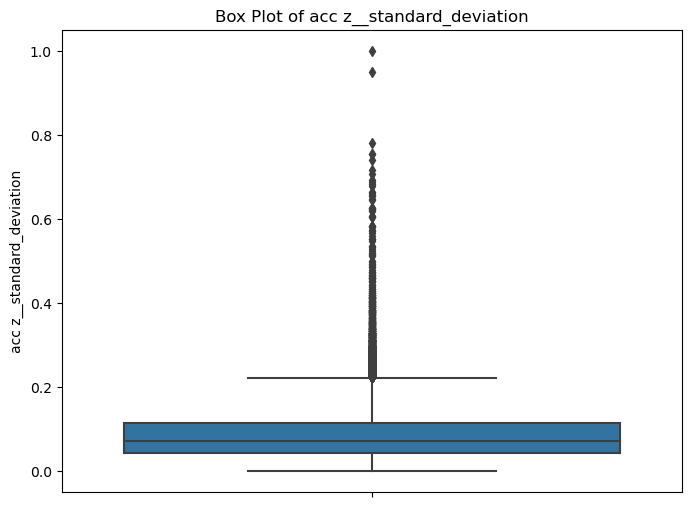

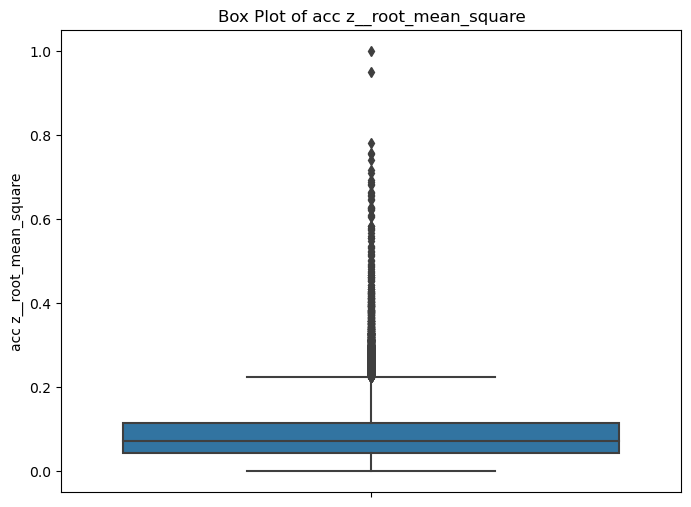

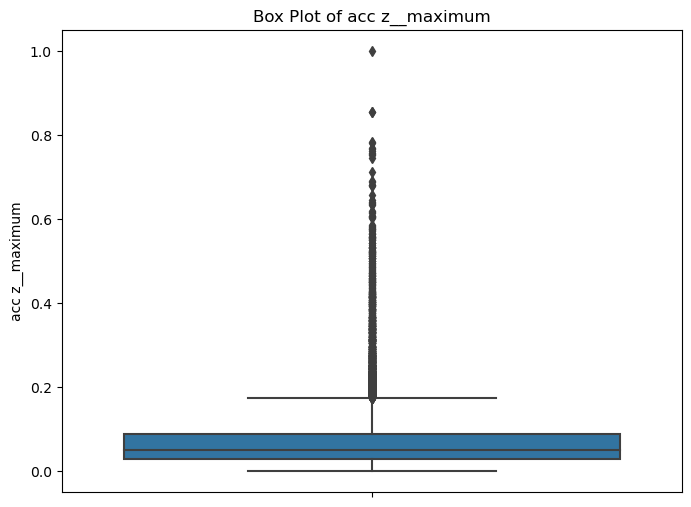

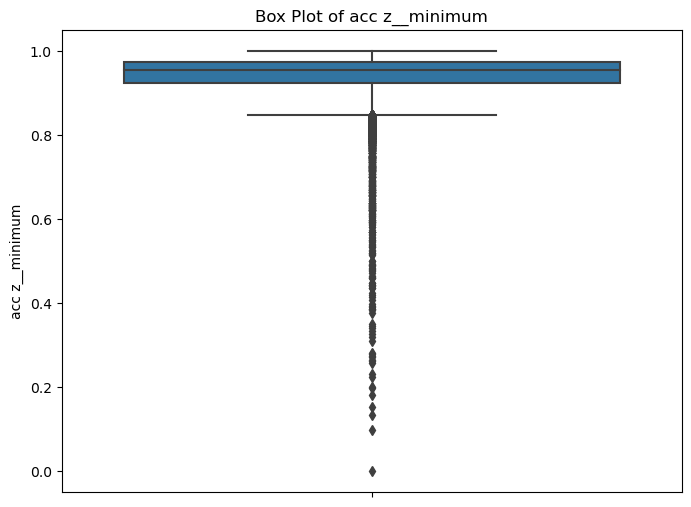

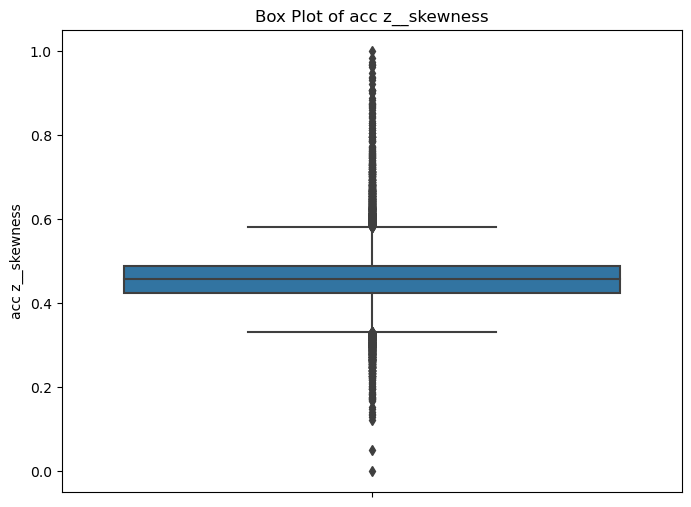

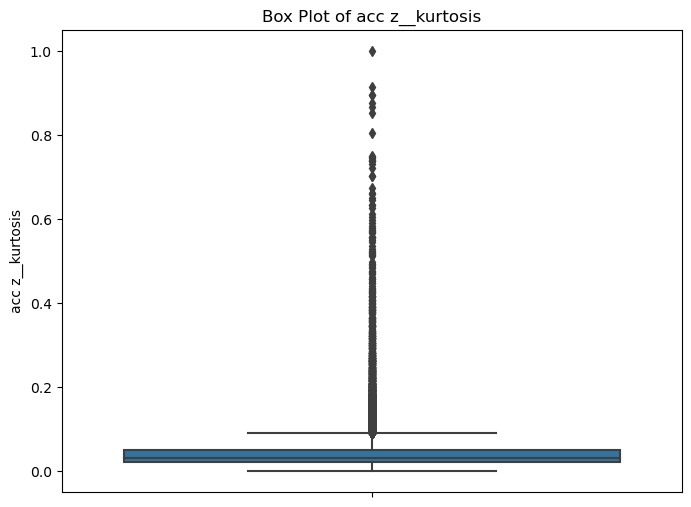

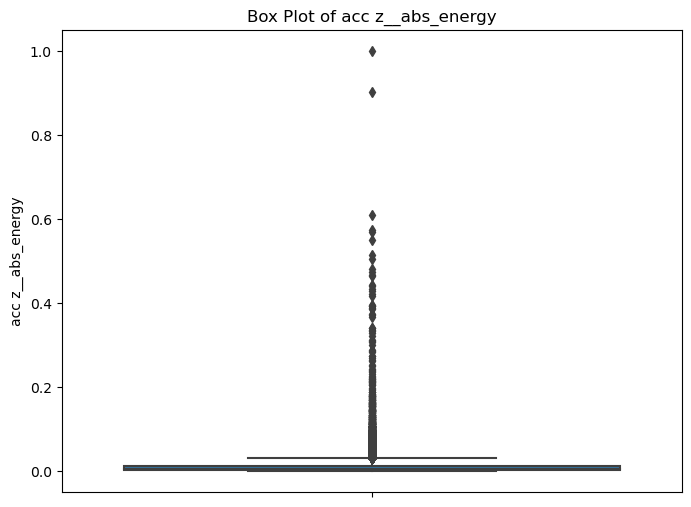

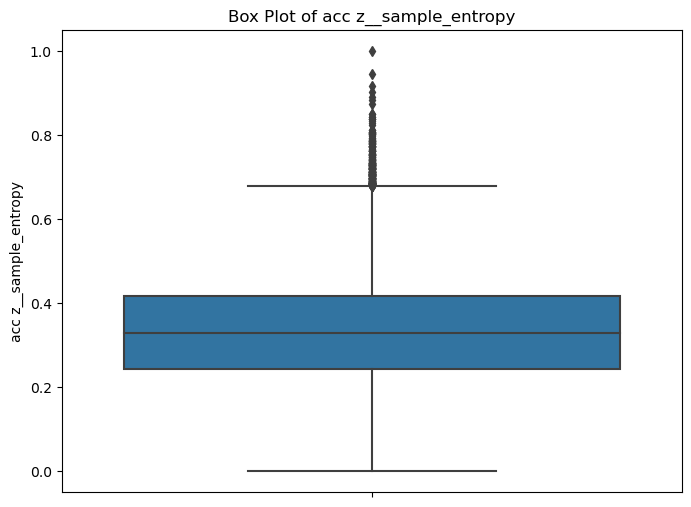

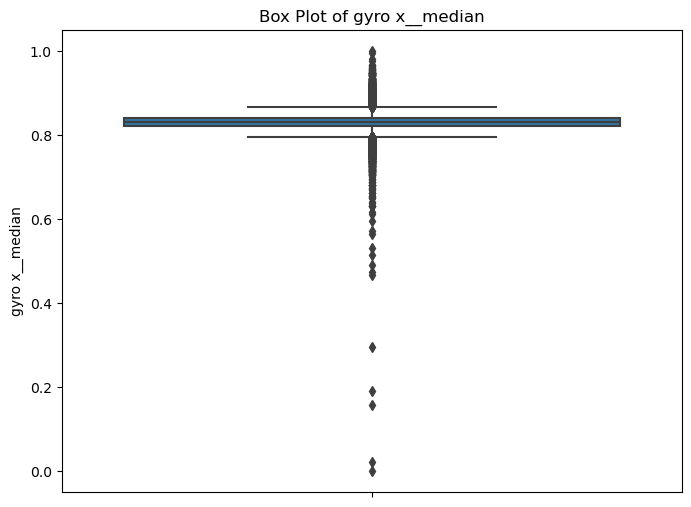

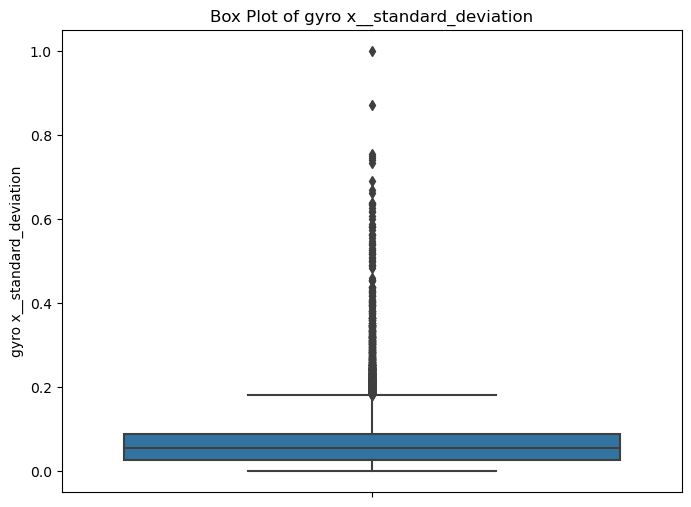

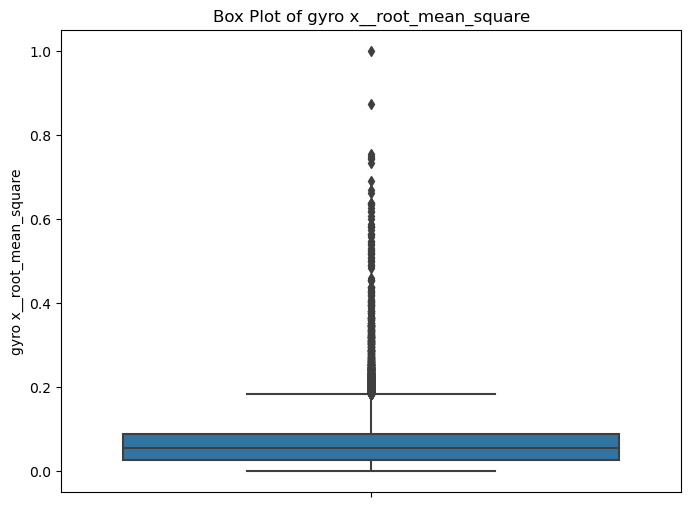

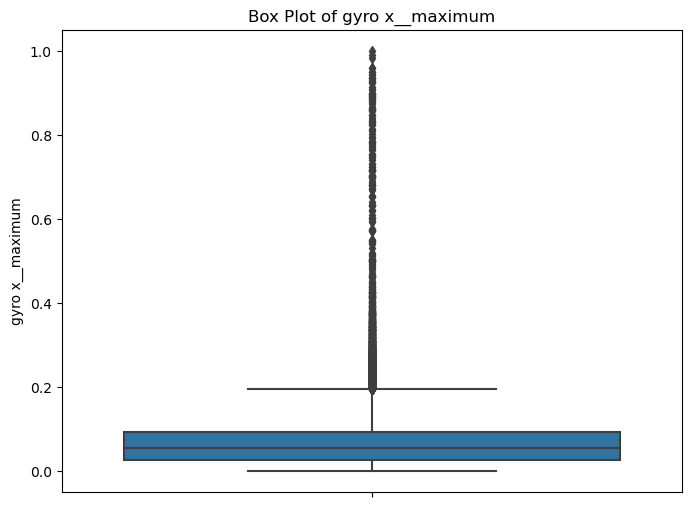

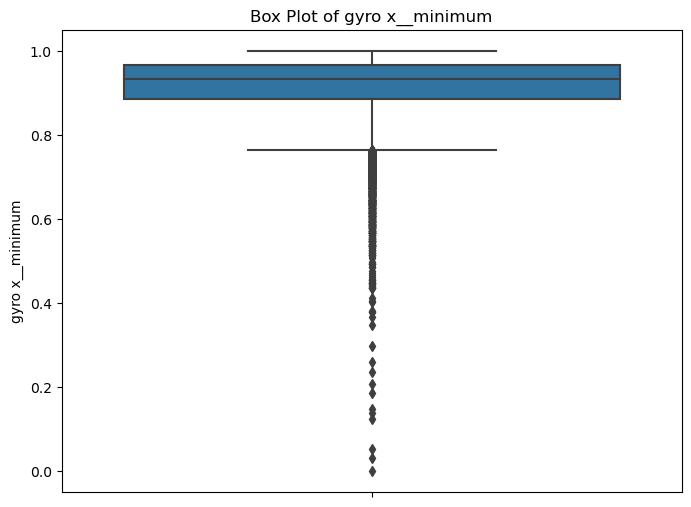

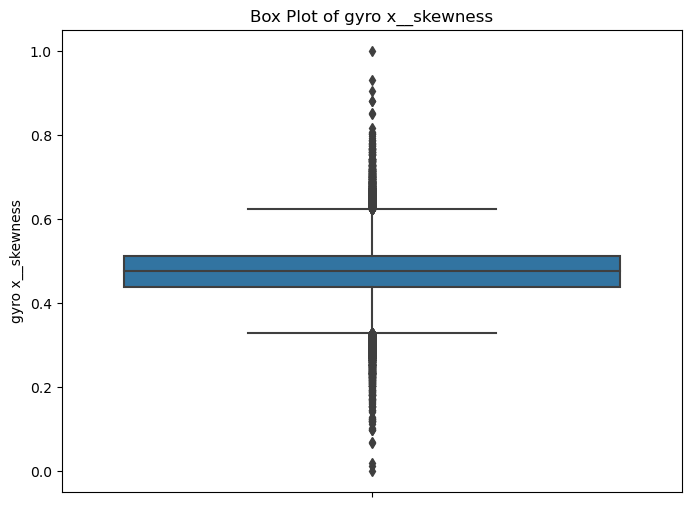

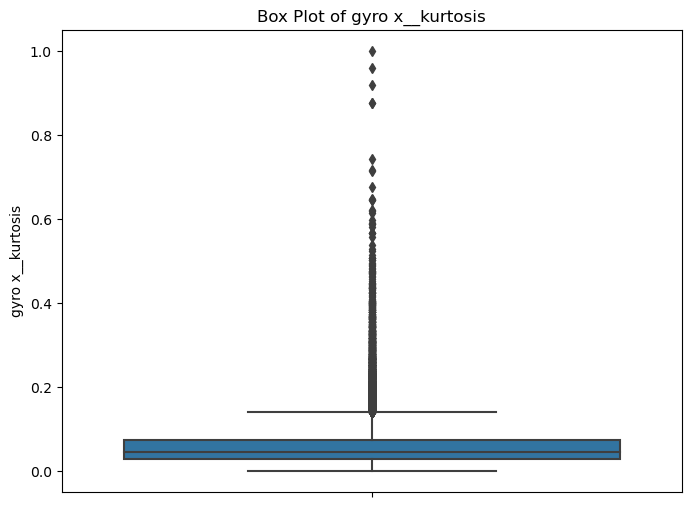

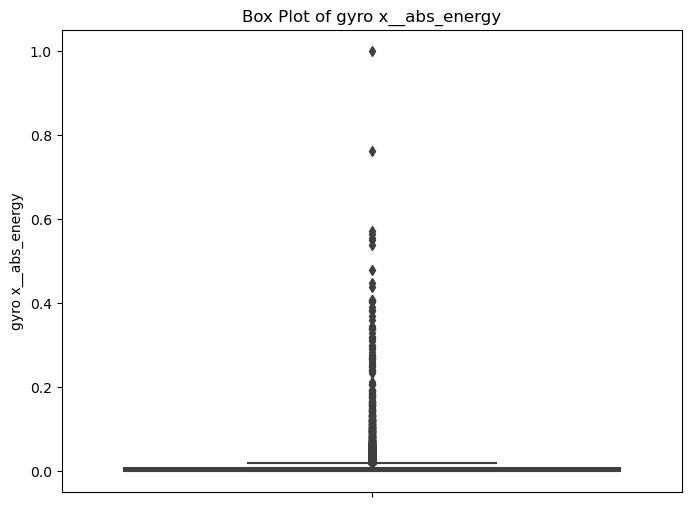

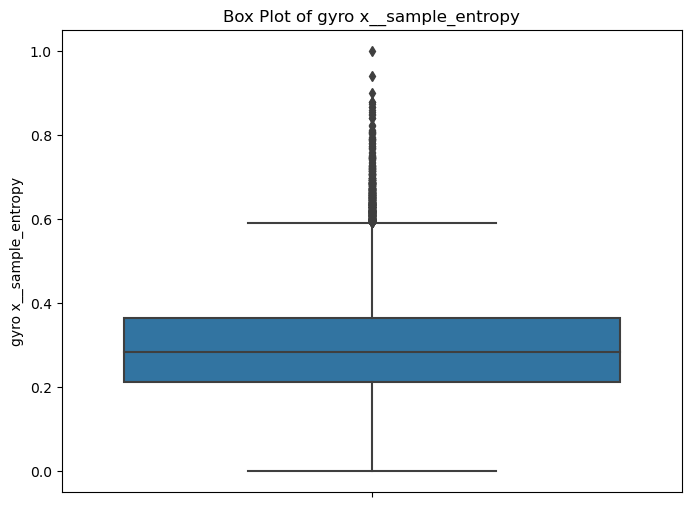

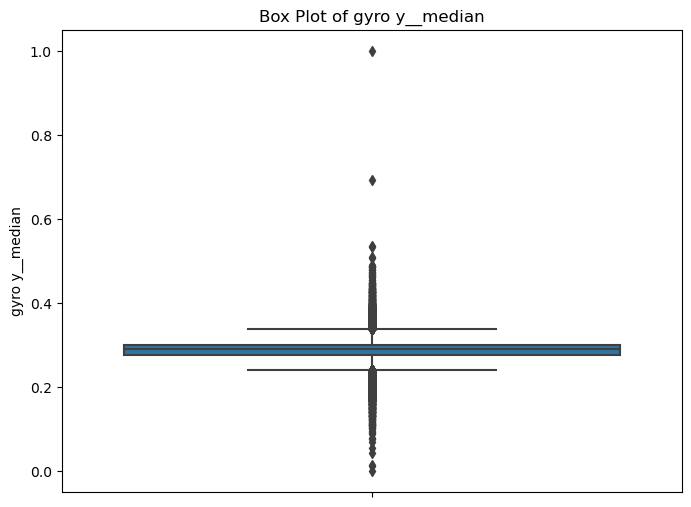

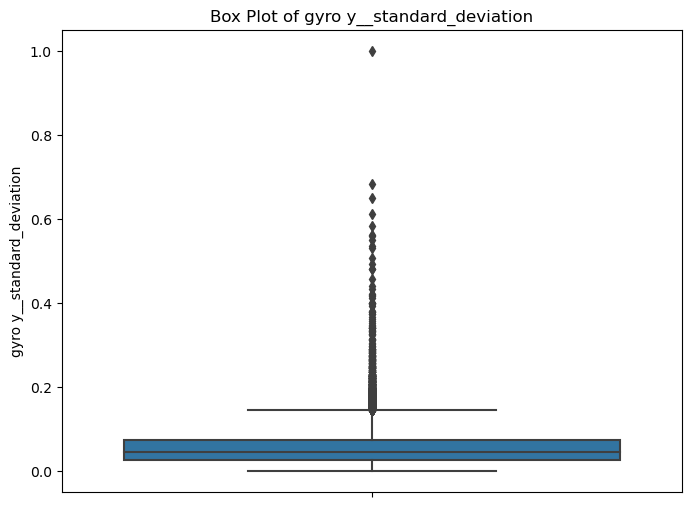

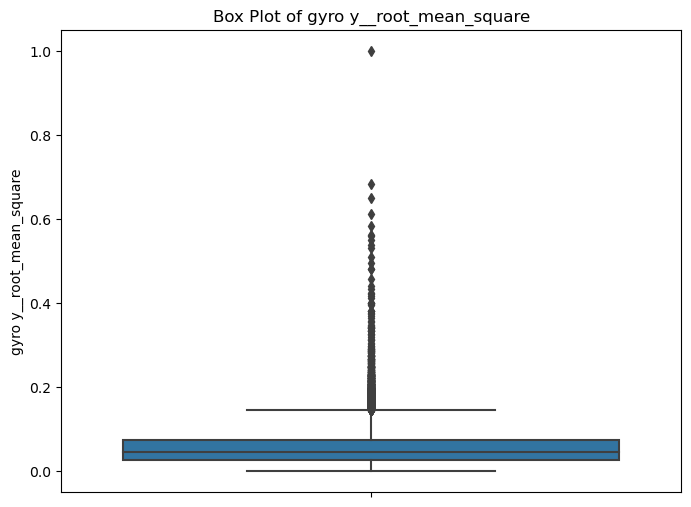

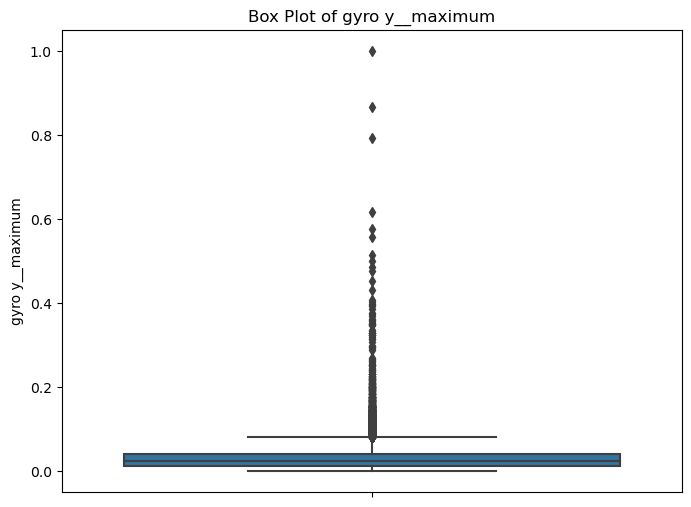

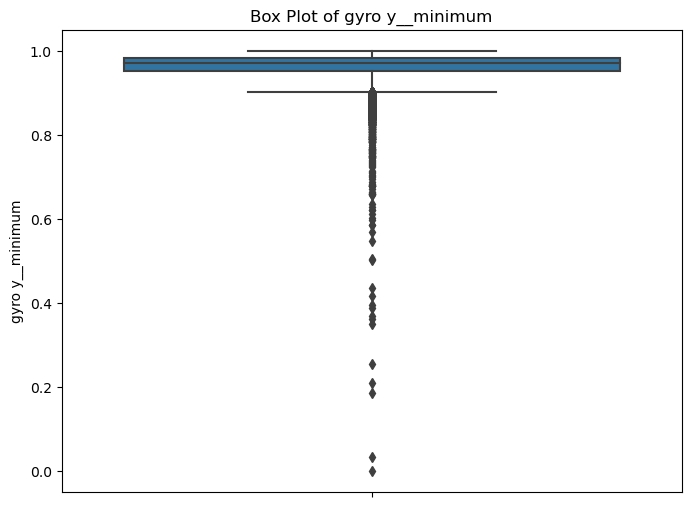

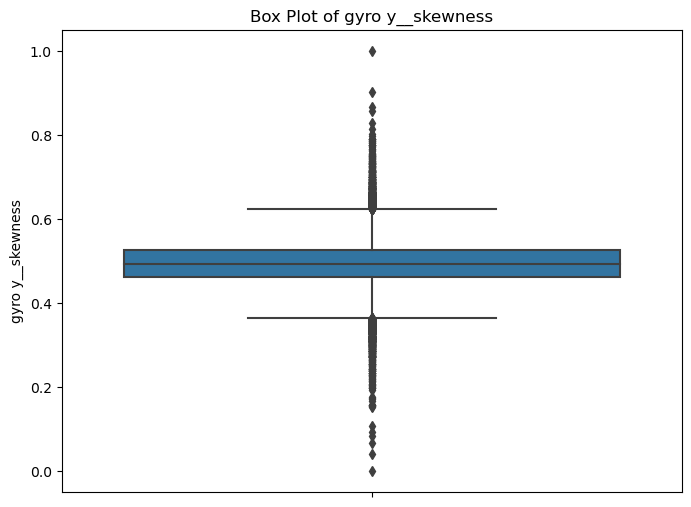

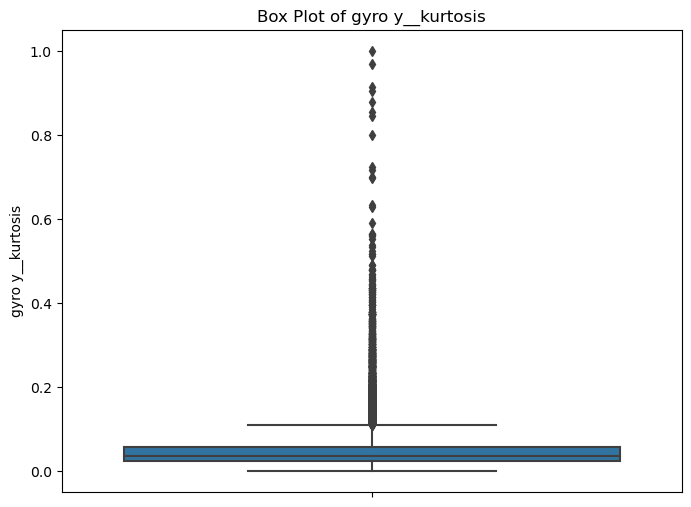

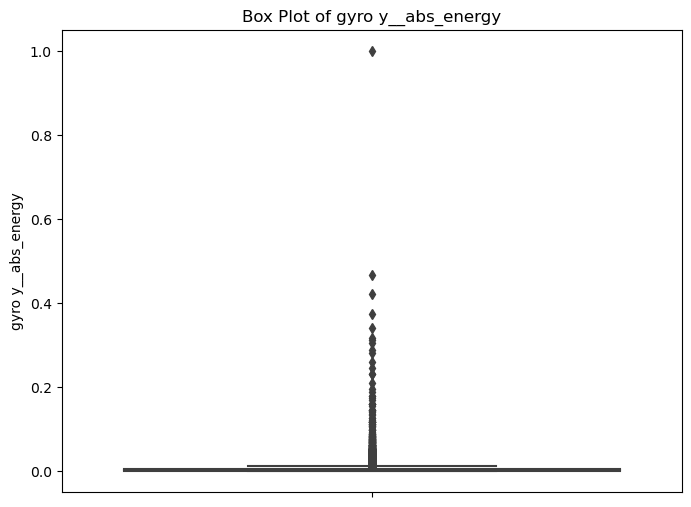

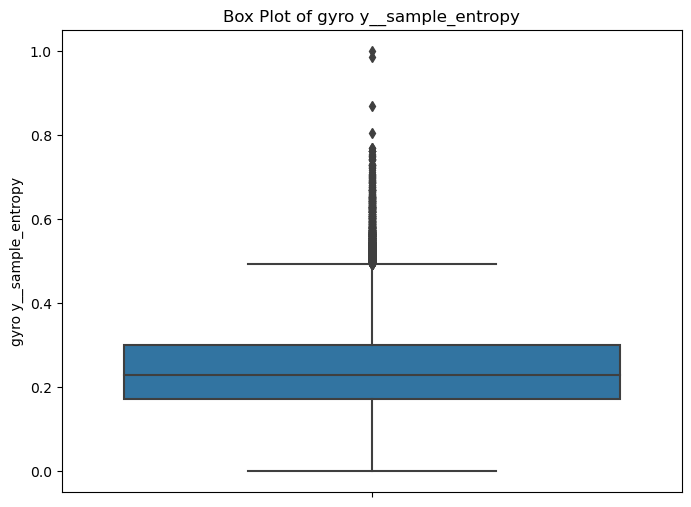

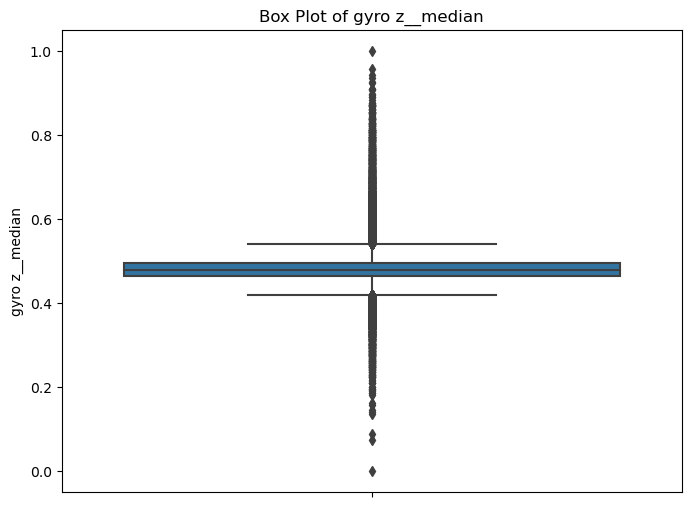

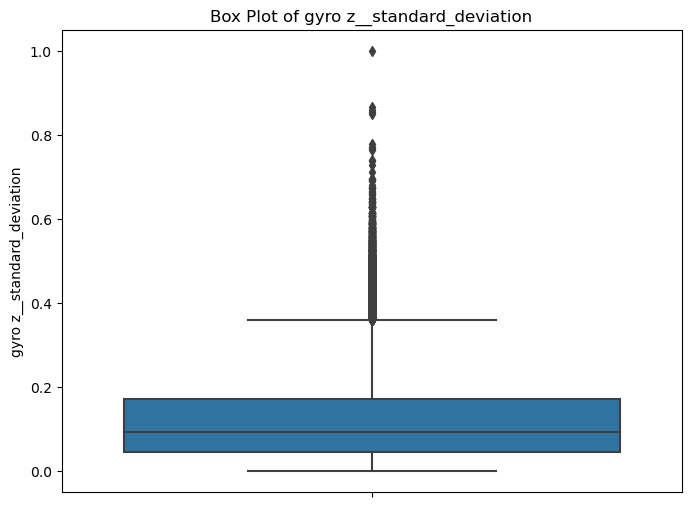

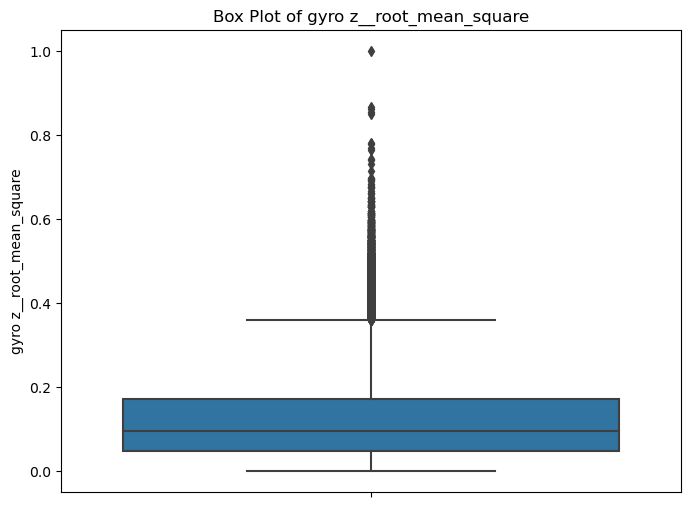

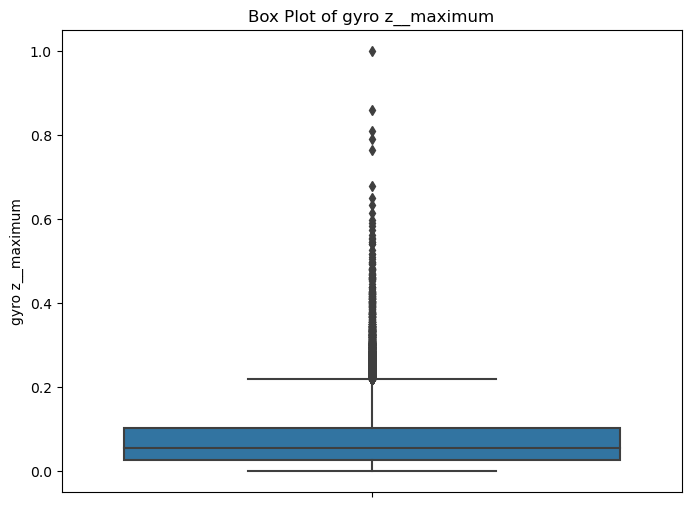

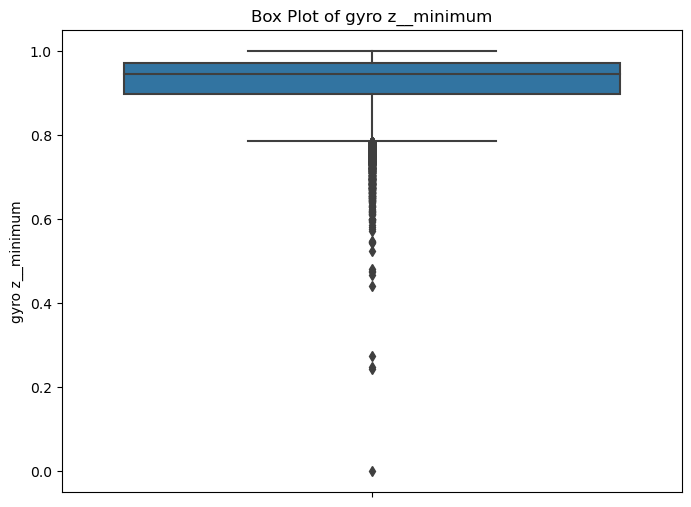

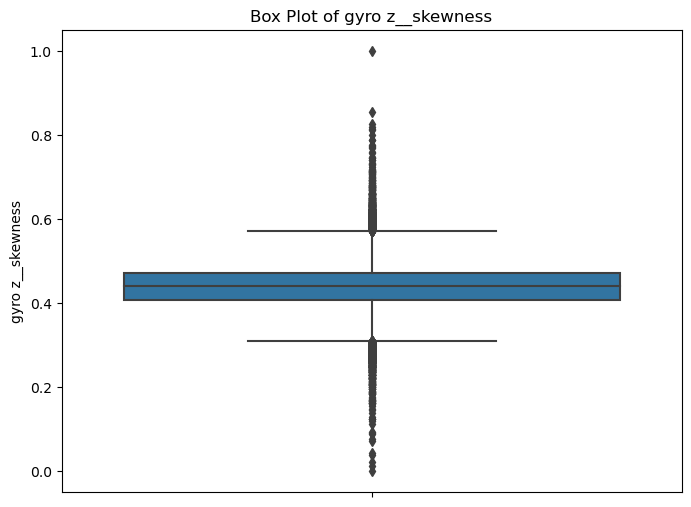

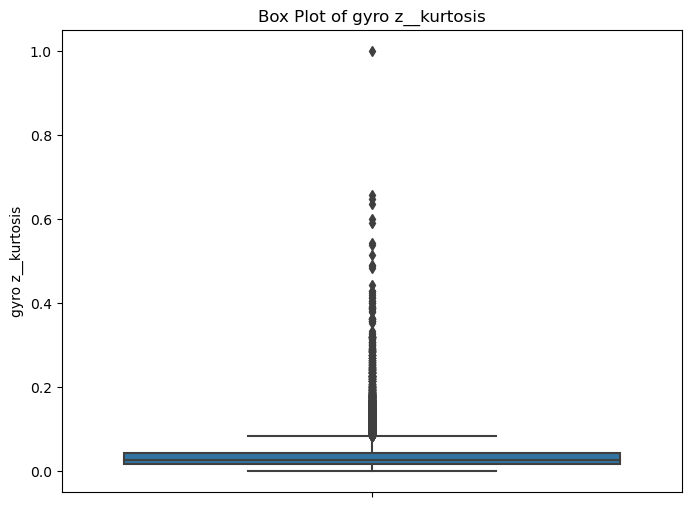

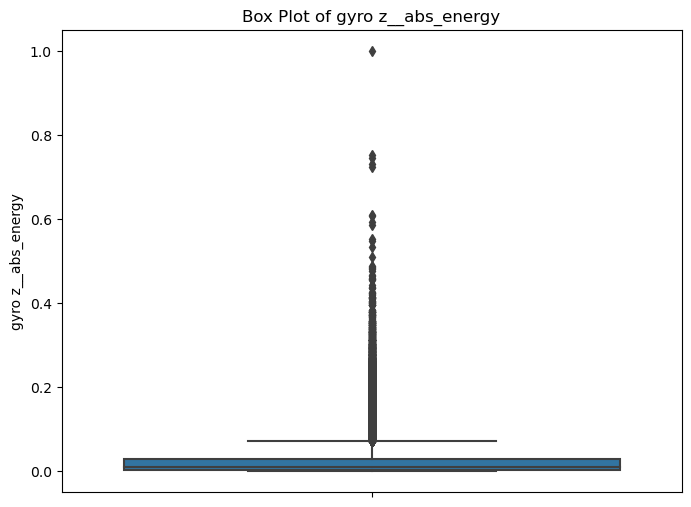

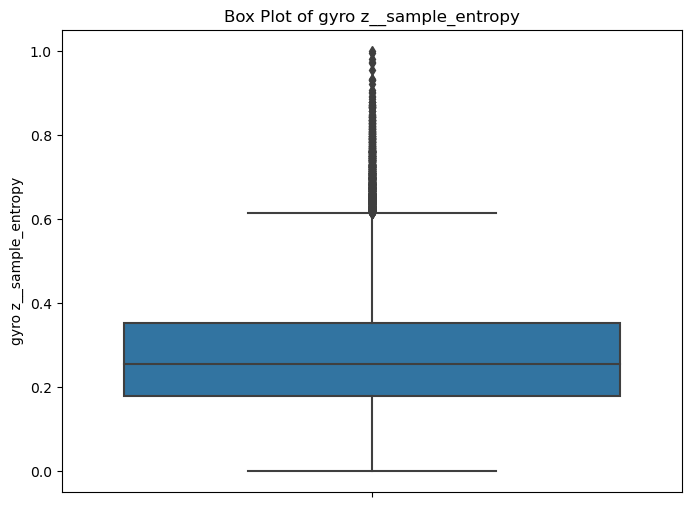

In [50]:
columns = df.columns.tolist()[:-1]
for feature in columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_minmax, y=feature)
    plt.title(f'Box Plot of {feature}')
    plt.show()

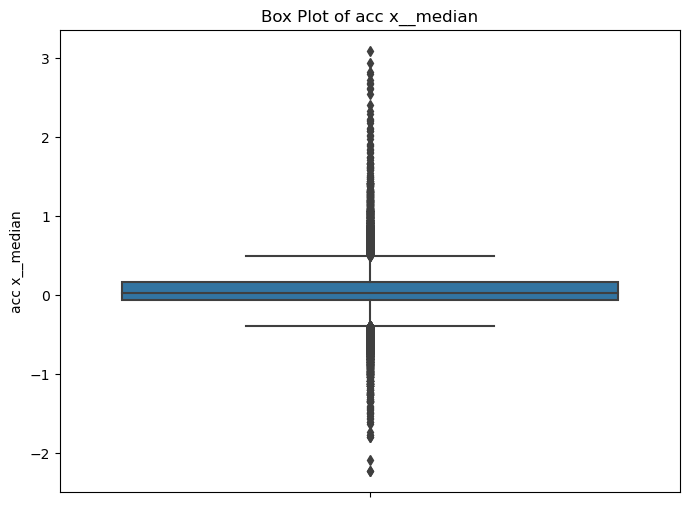

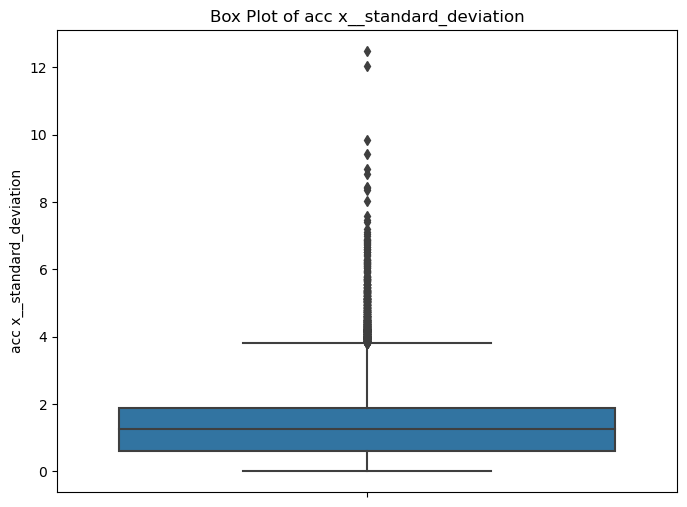

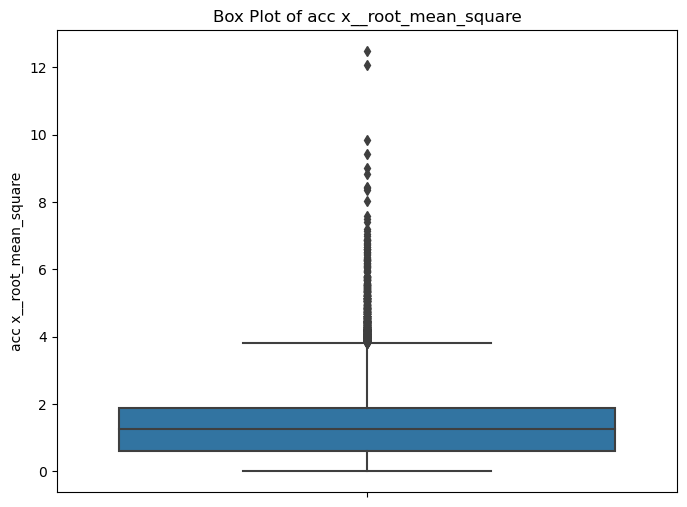

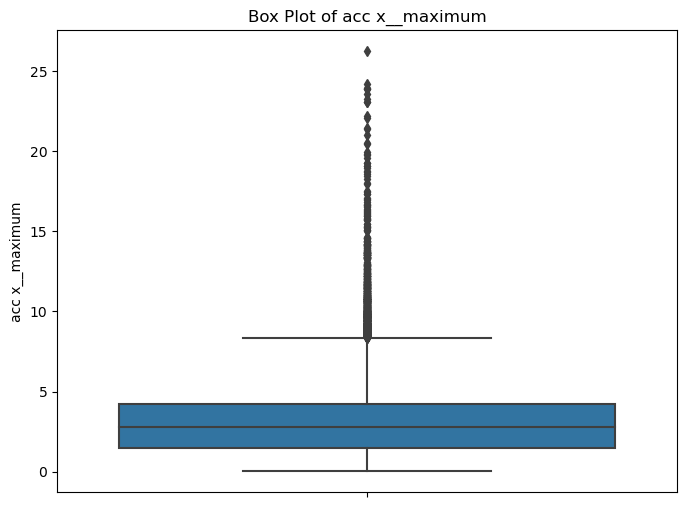

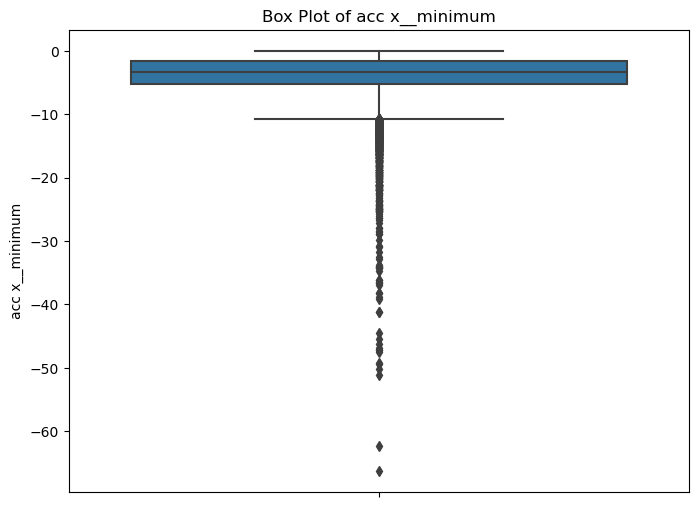

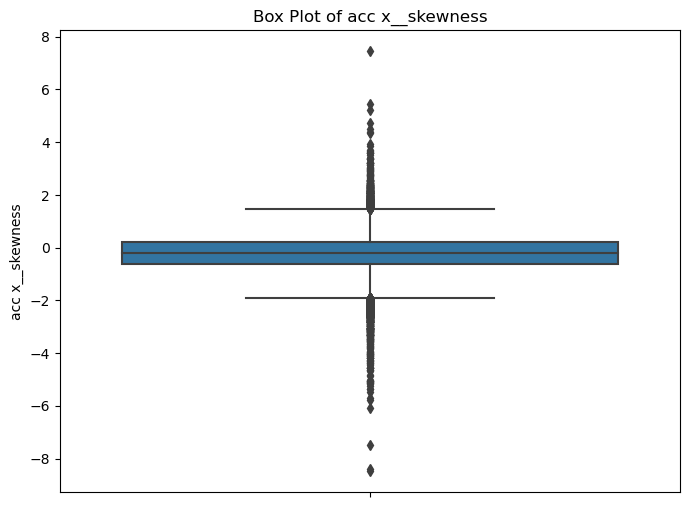

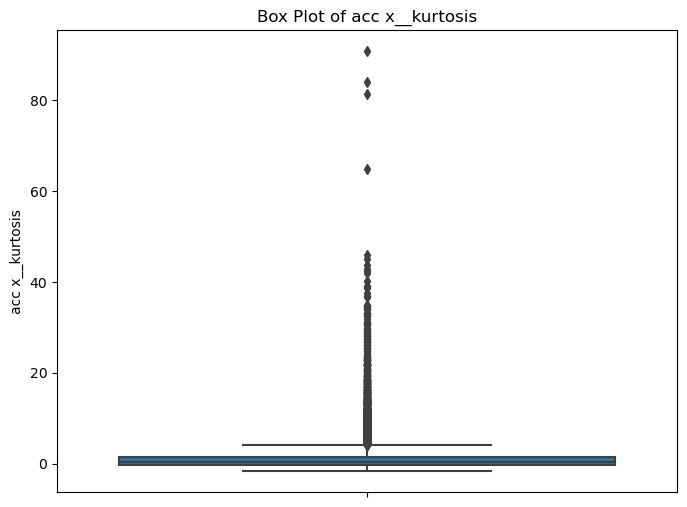

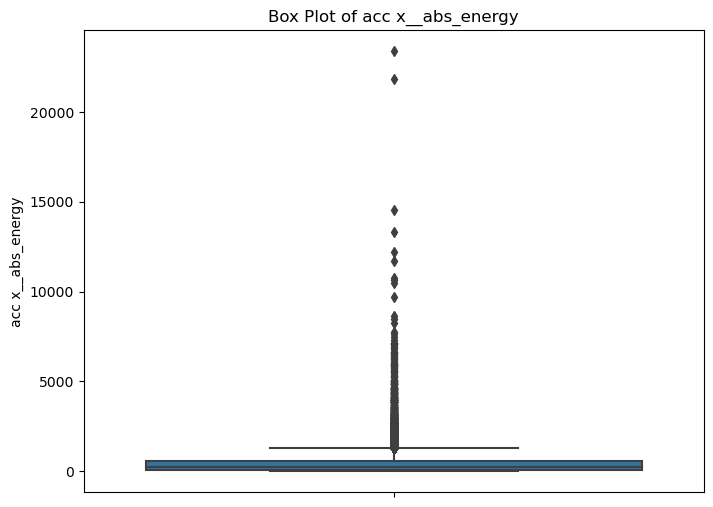

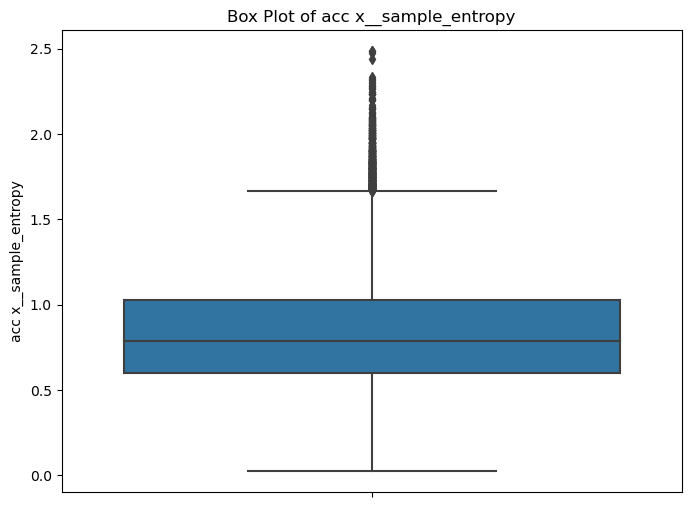

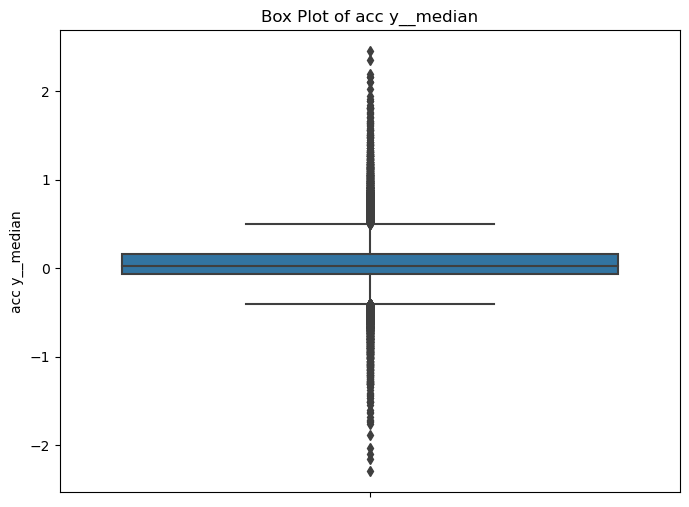

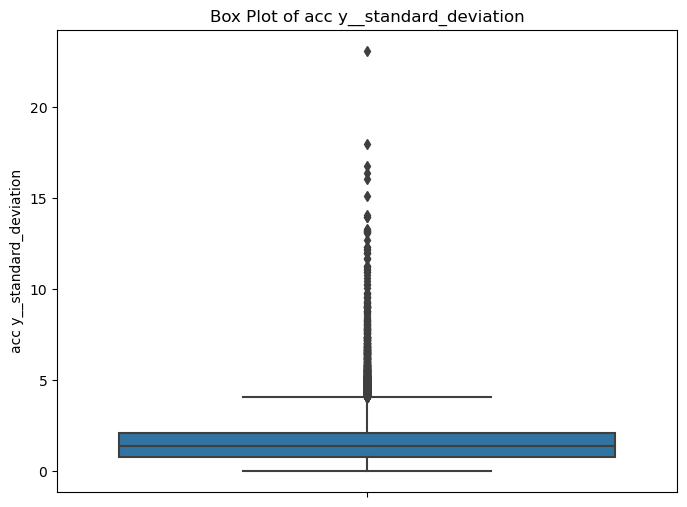

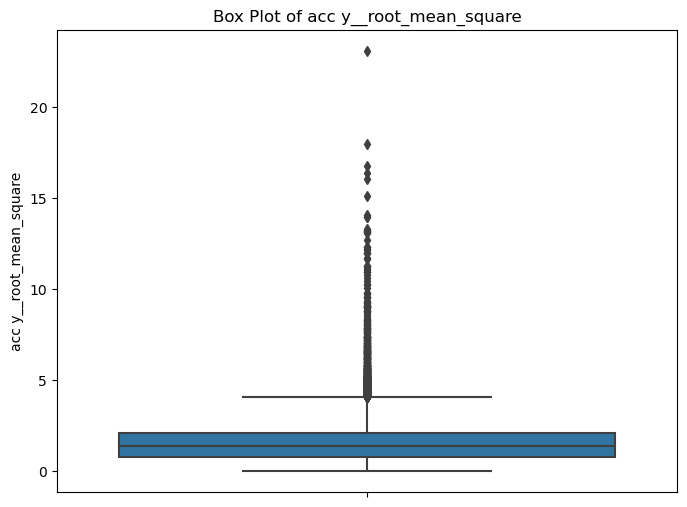

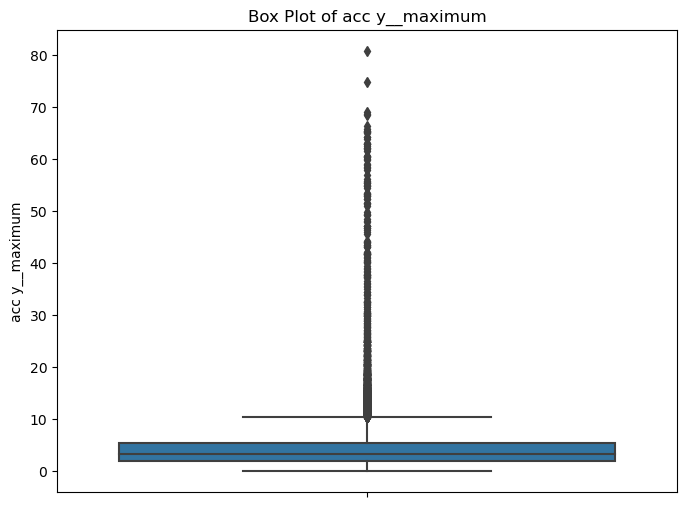

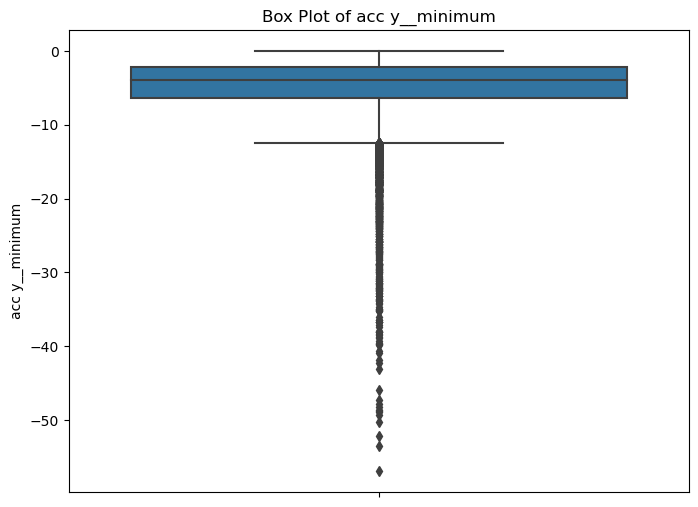

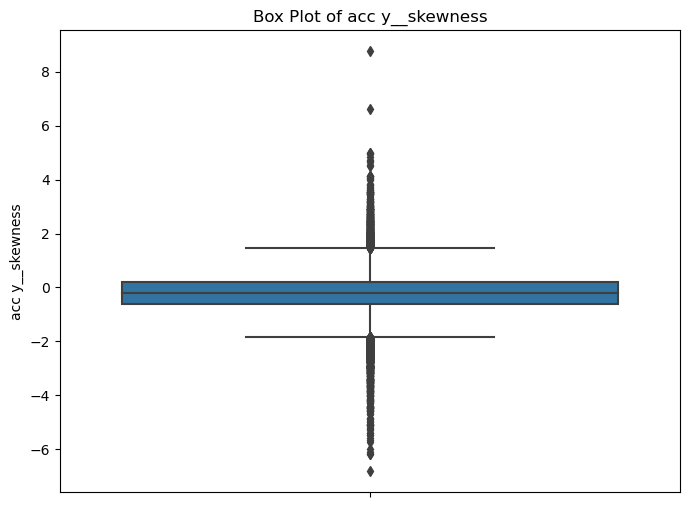

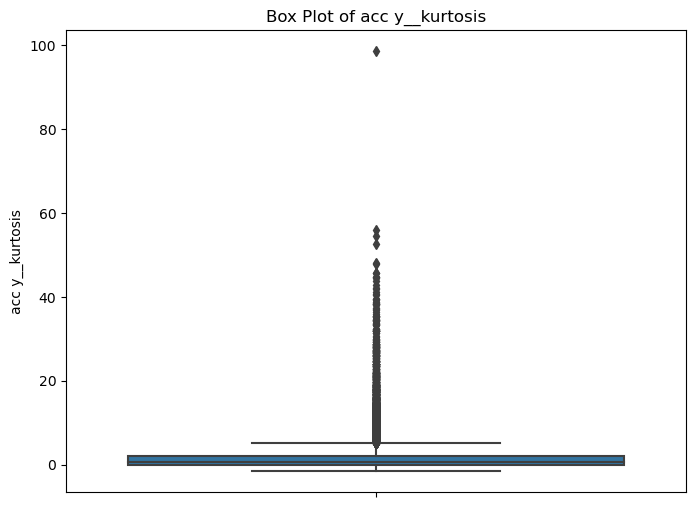

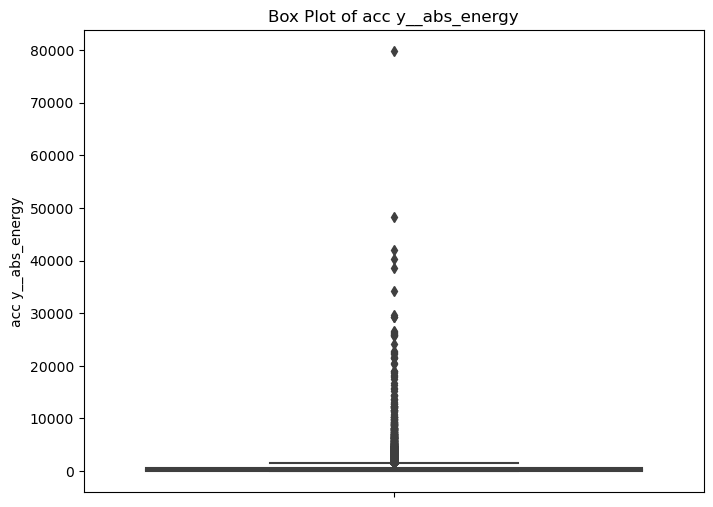

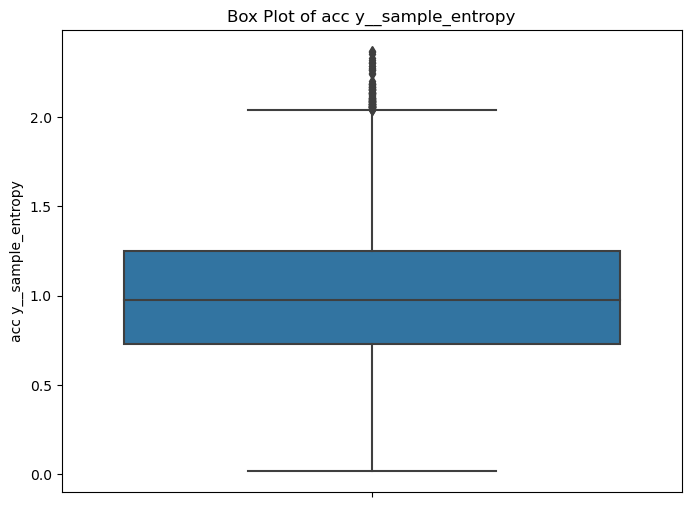

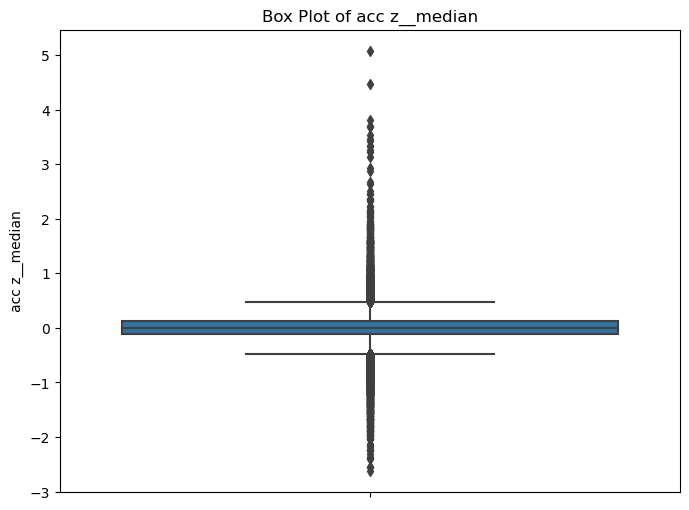

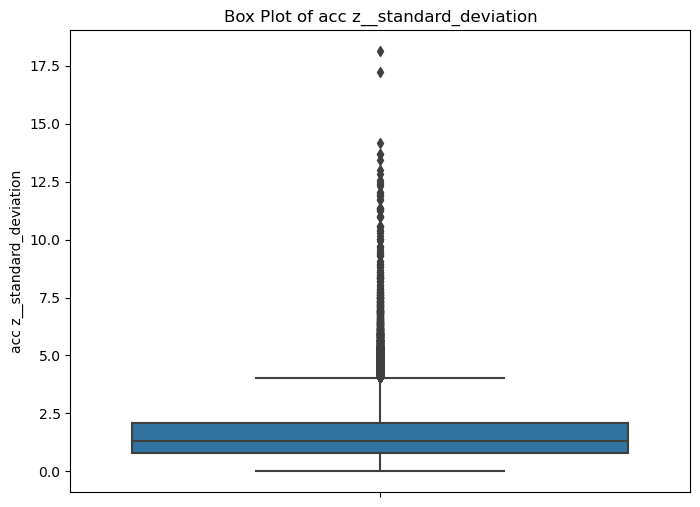

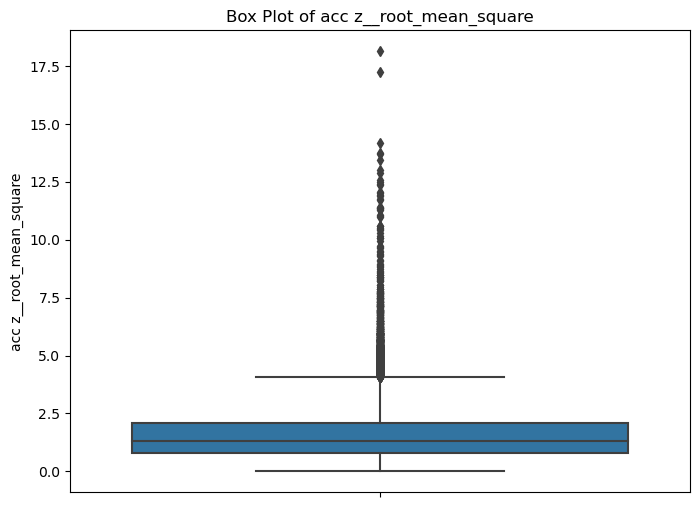

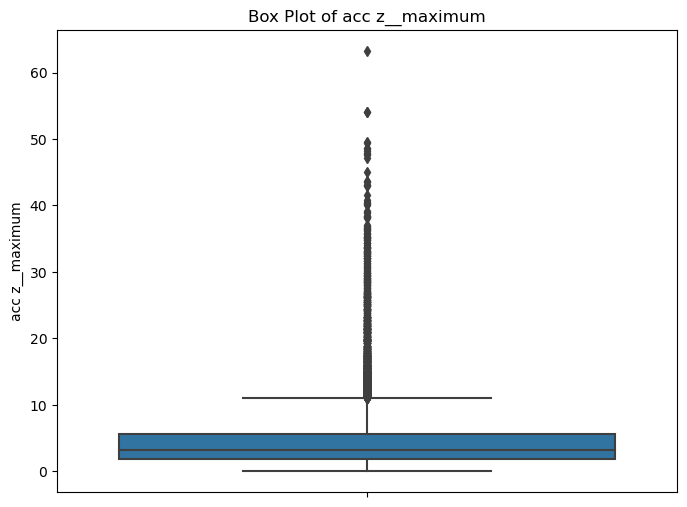

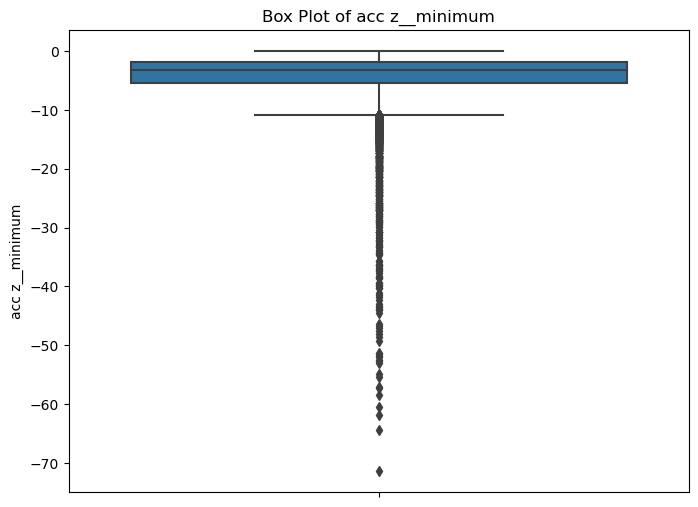

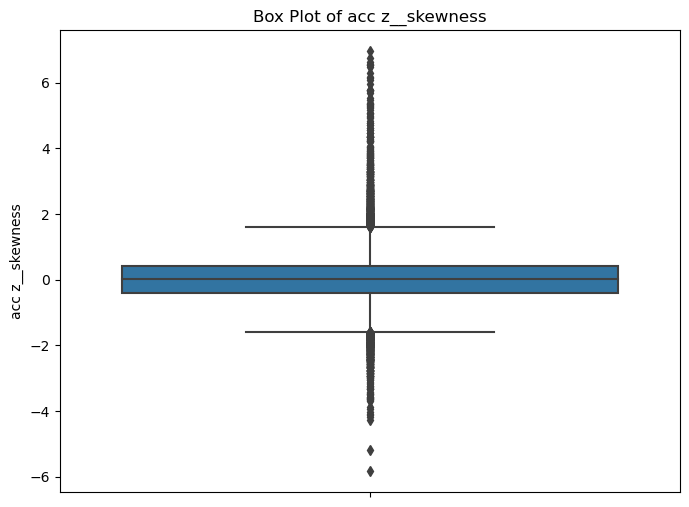

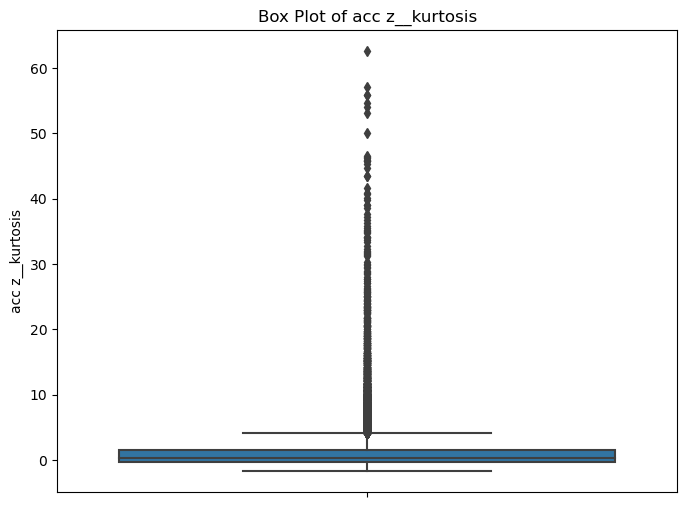

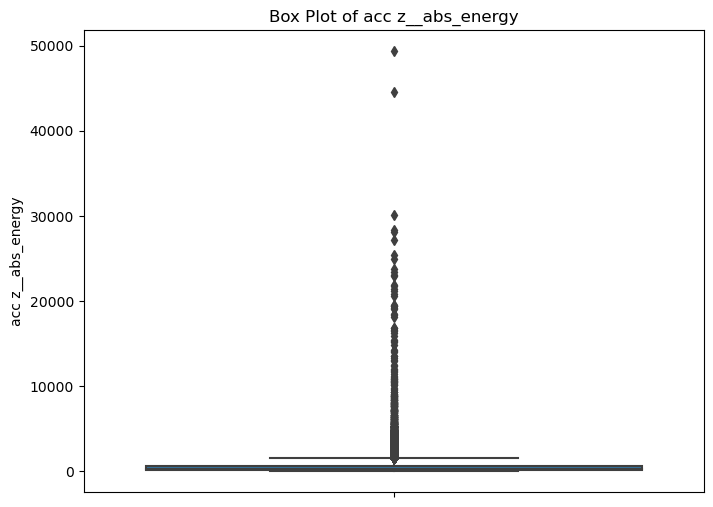

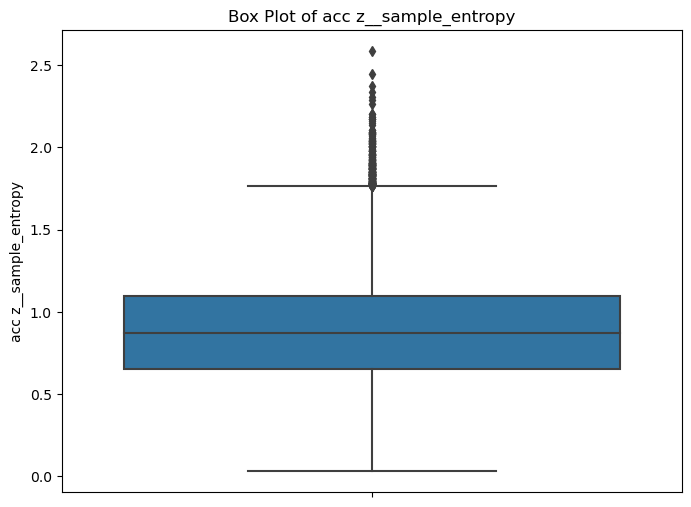

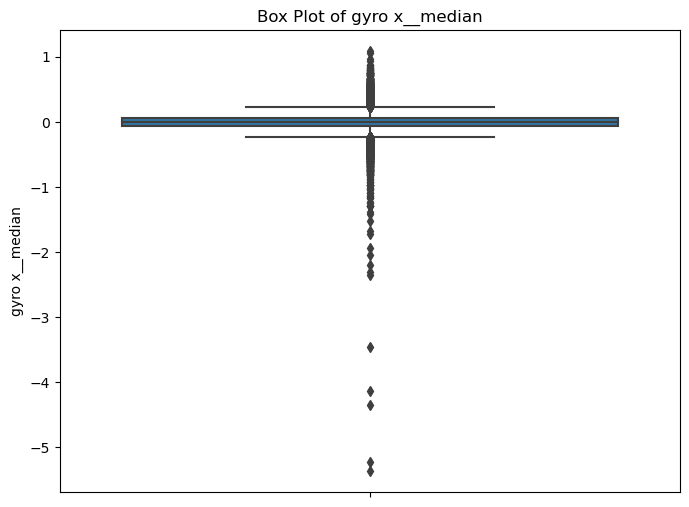

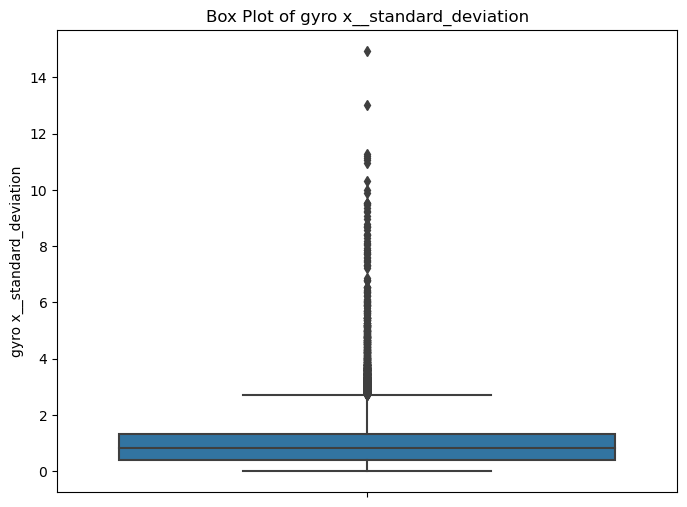

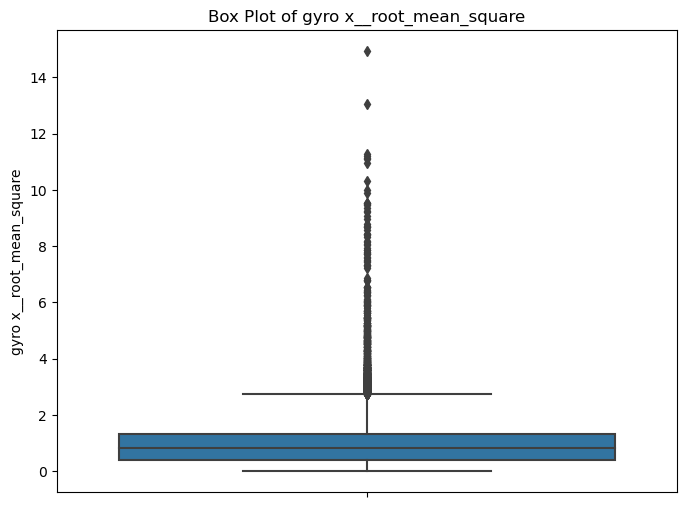

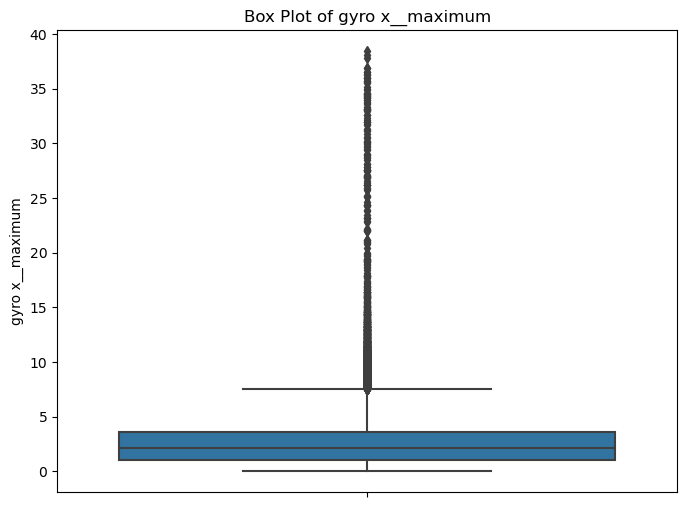

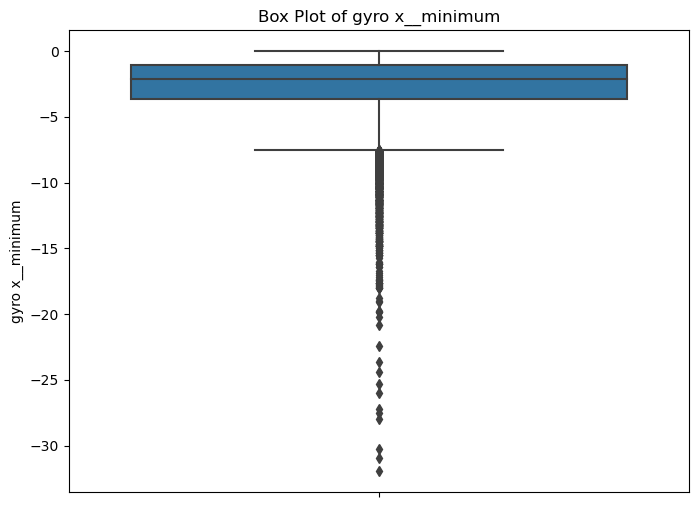

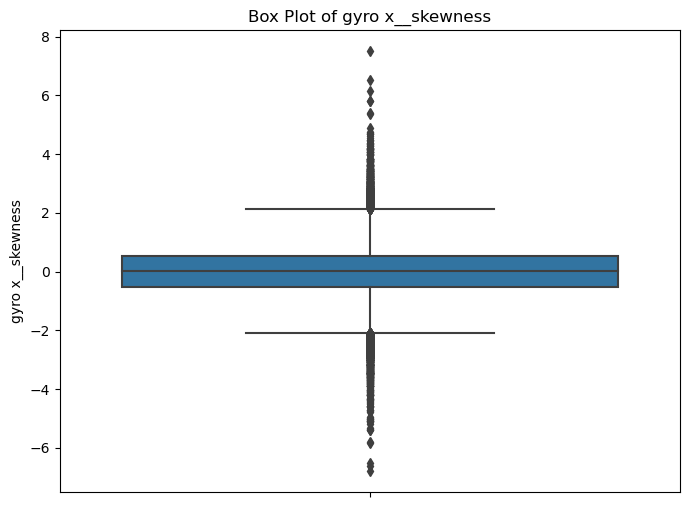

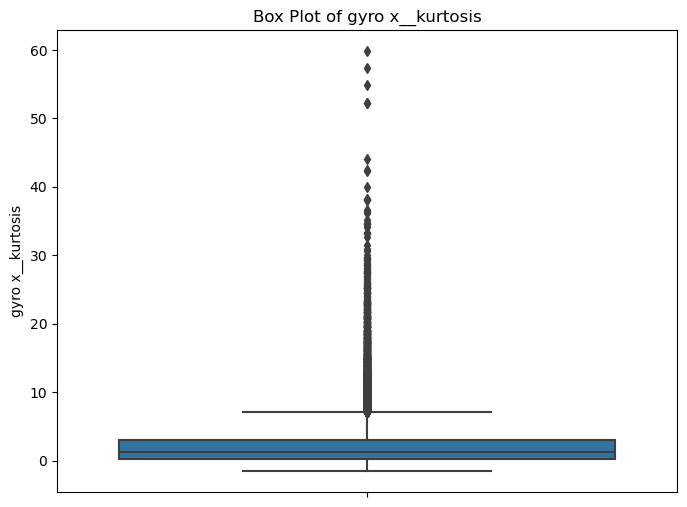

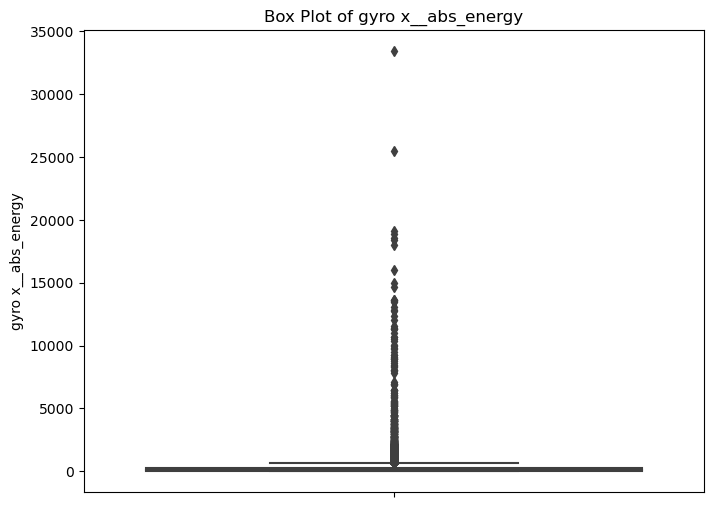

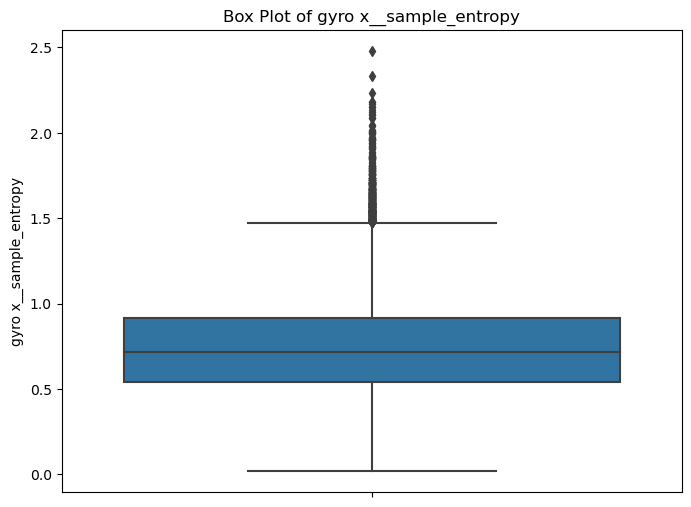

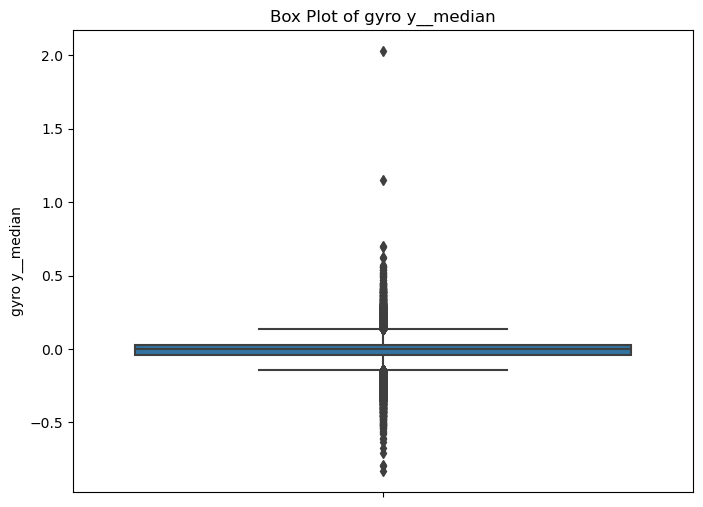

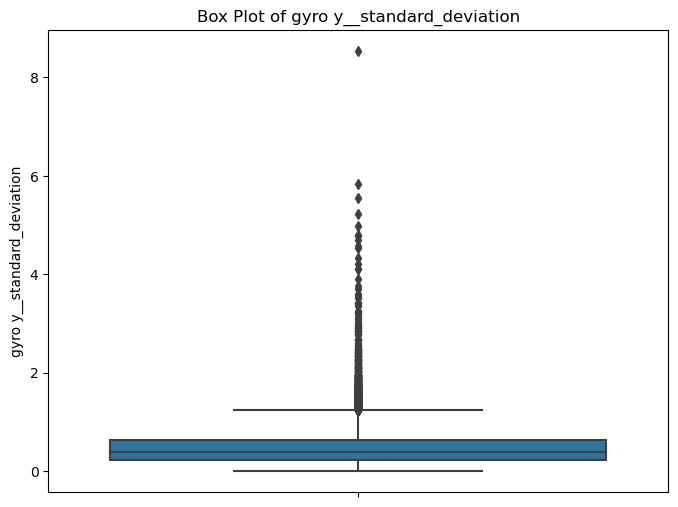

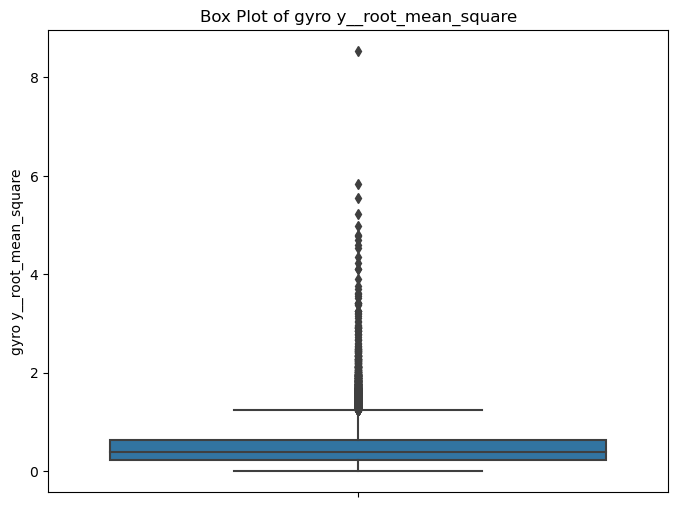

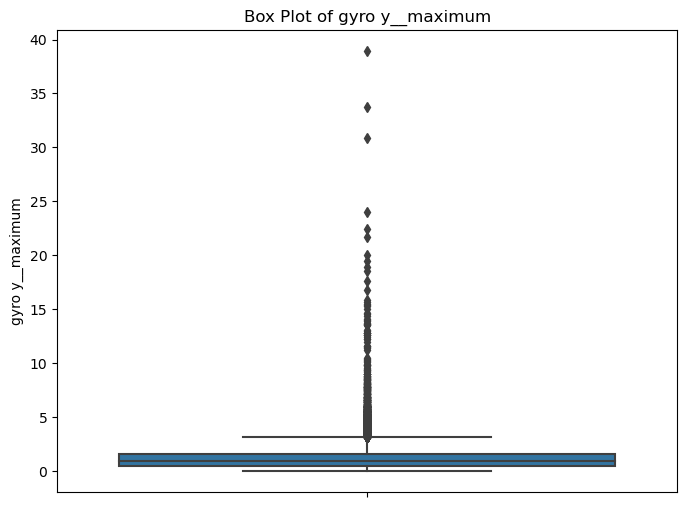

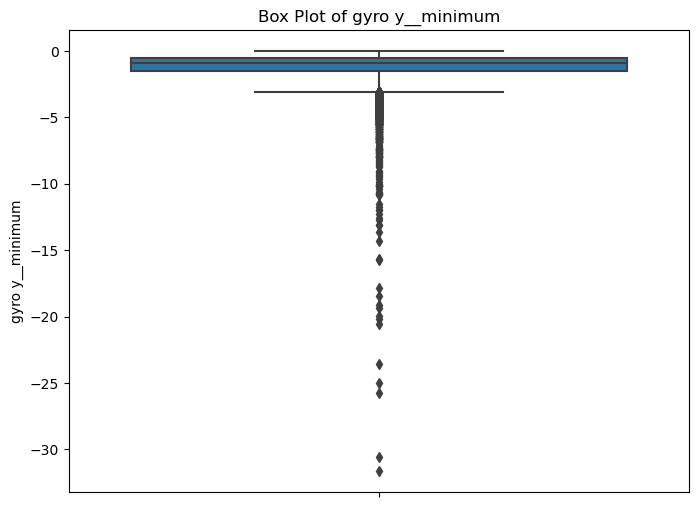

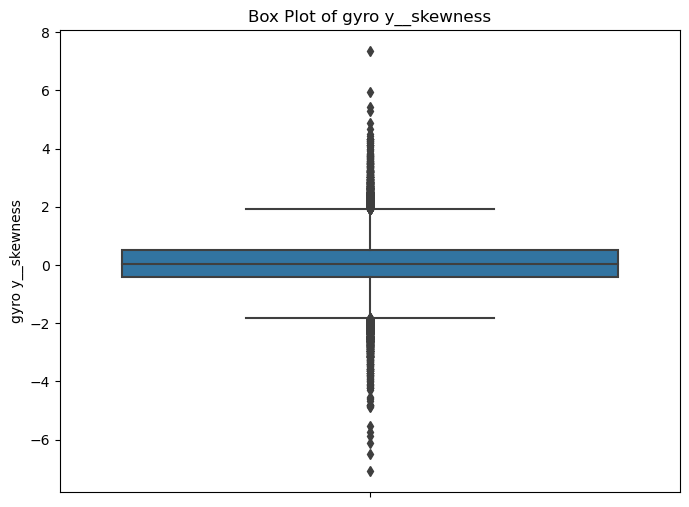

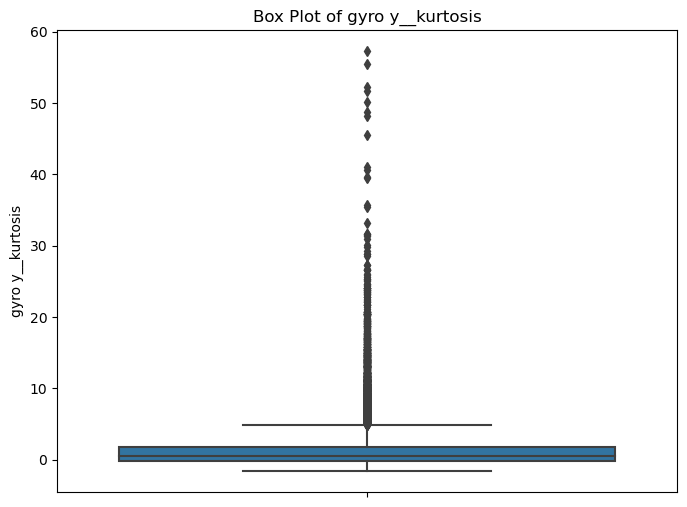

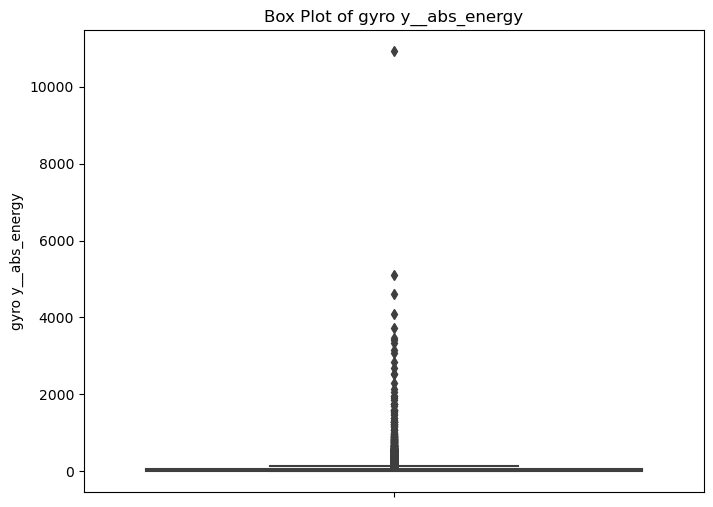

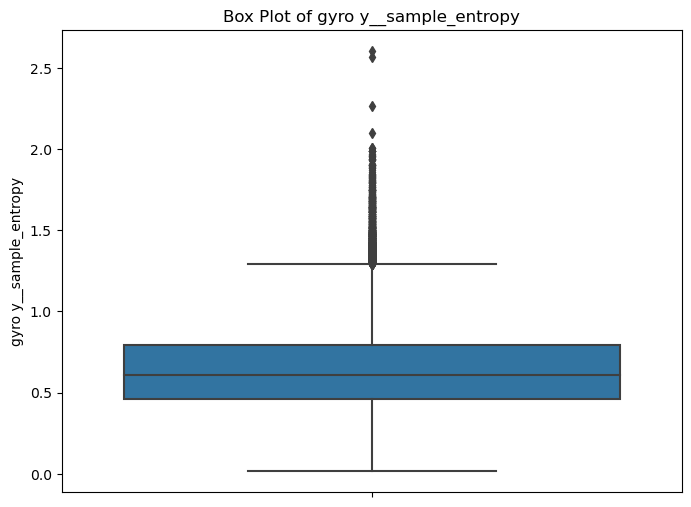

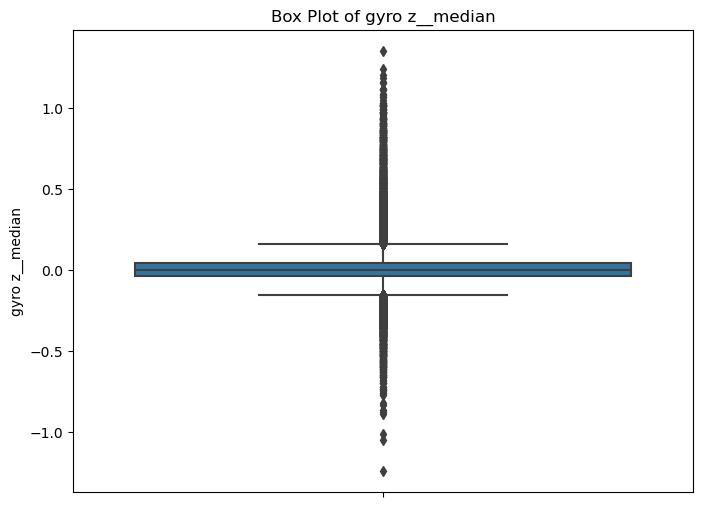

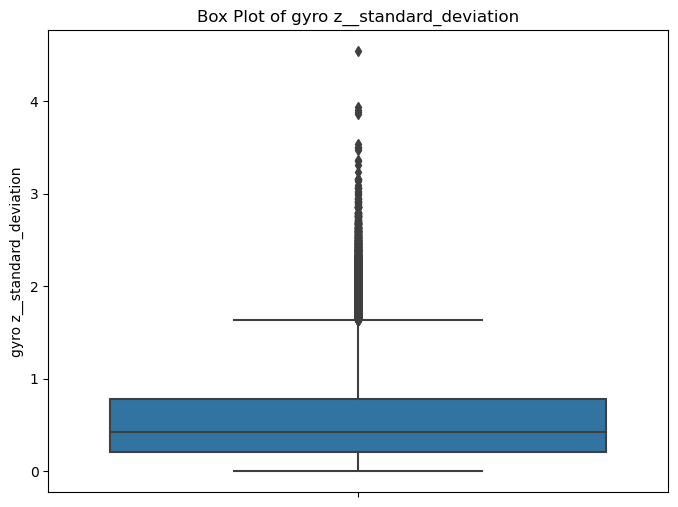

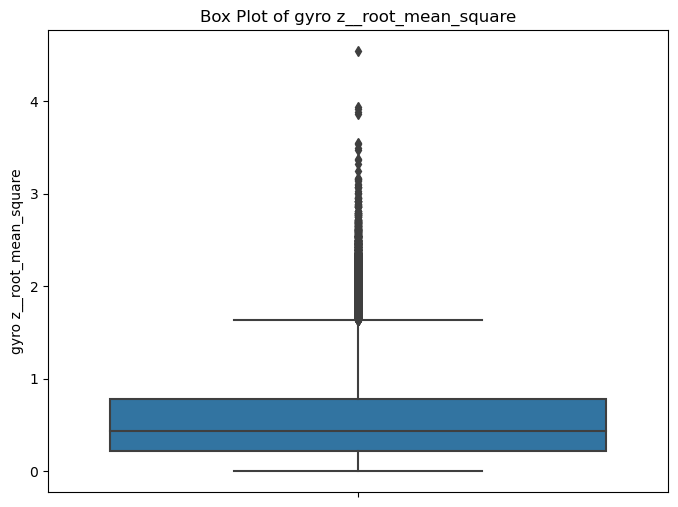

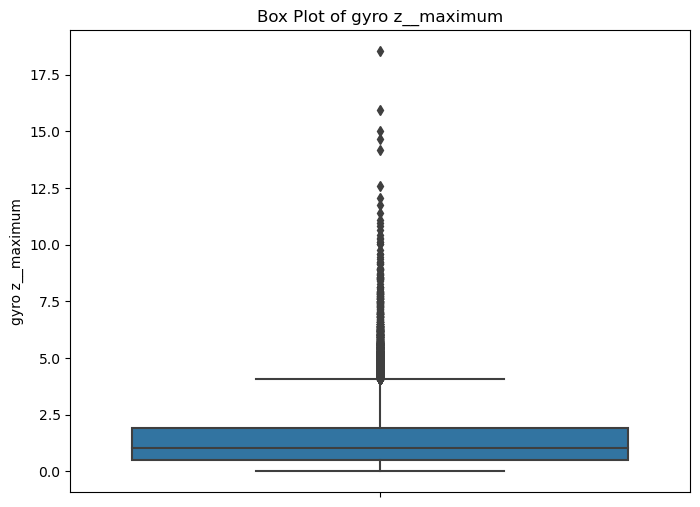

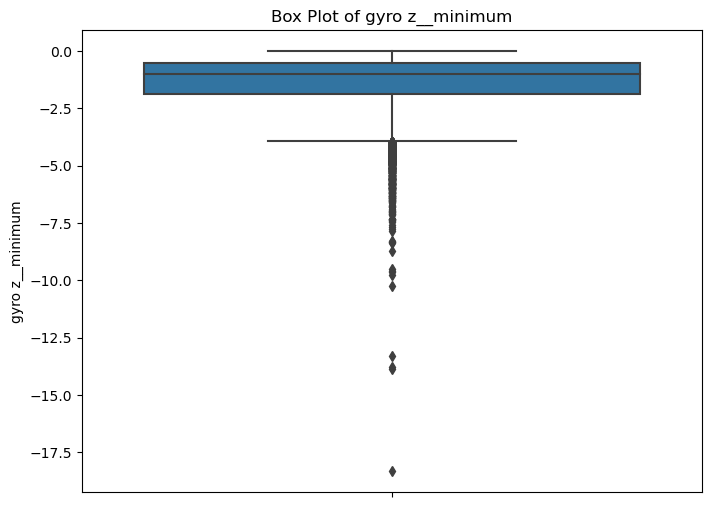

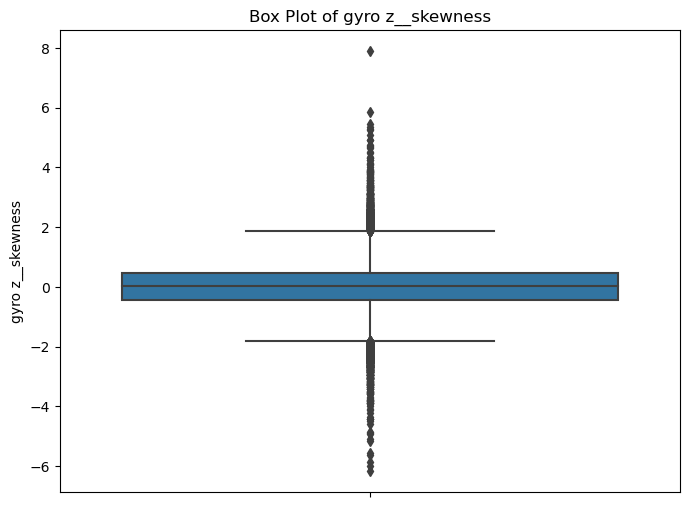

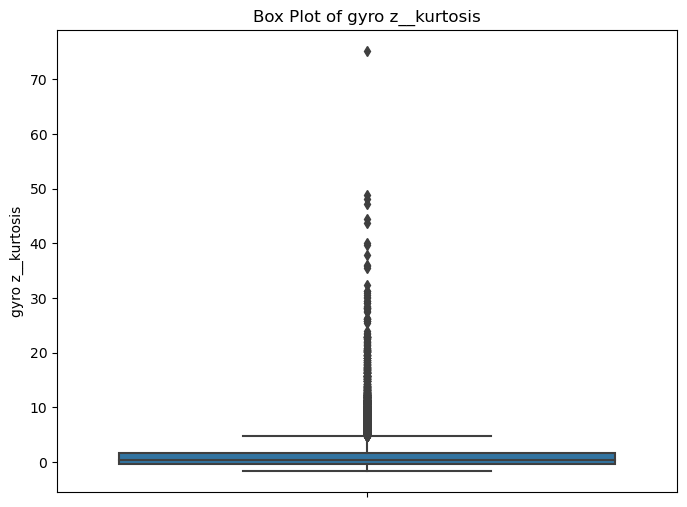

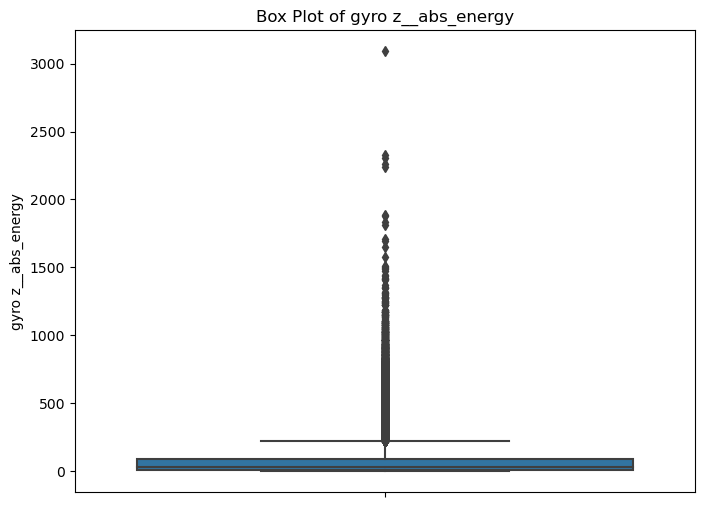

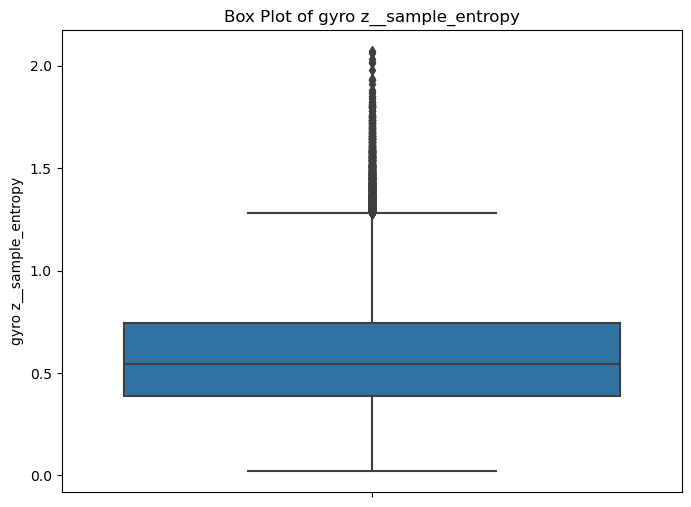

In [43]:
for feature in columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, y=feature)
    plt.title(f'Box Plot of {feature}')
    plt.show()

In [51]:
# Check for negative values and count them
(df < 0).sum().sum()

439825

In [52]:
(df_minmax<0).sum().sum()

0

In [53]:
(df_scaled<0).sum().sum()

850764

In [31]:
from sklearn.preprocessing import RobustScaler

# Create a RobustScaler instance
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(df.iloc[:,0:54])

# Scale test set using same mean and variance from training set.
#X_test_scaled = scaler.transform(X_test)


In [36]:
df_scaled= pd.DataFrame(X_train_scaled, columns = df.columns.tolist()[:-1])

In [49]:
minmax_scaler = MinMaxScaler()
minmax_scaled_data = minmax_scaler.fit_transform(df.iloc[:,0:54])
df_minmax= pd.DataFrame(minmax_scaled_data, columns = df.columns.tolist()[:-1])

### Assign Subjects for training and inference

In [12]:
# Personalized subject
personalized_subject = "03"

# All subjects
subjects = ['02', '05', '25', '30', '20', '03','19', '04', '21', '12', '01', '11', '29', '10', '09', '18', '13']

# Remove personalized subject
if personalized_subject in subjects:
    subjects.removed(personalized_subject)

#Random Shuffling
random.seed(RANDOM_SEED)
subjects = random.shuffle(subjects)

# Train subjects
train_subjects = subjects[:-5]

# Inference
inferences = subjects[-5:]

### Select classifier and normalization method

In [13]:
classifier = "SGDClassifier"#'Perceptron'#'PassiveAggressiveClassifier'#"MultinomialNB" #"SGDClassifier"
norm_method = 'standard'

## Classical ML

**Supported classifiers:**
- logistic_regression
- random_forest 
- gradient_boosting
- svm 
- kmeans
- neuralnetwork
- SGDClassifier
- MultinominalNB
- PassiveAggressiveClassifier
- Perceptron

In [14]:
def get_model(name, **kwargs):
    if name == 'logistic_regression':
        model = LogisticRegression(**kwargs)
    elif name == 'random_forest':
        model = RandomForestClassifier(**kwargs)
    elif name == 'gradient_boosting':
        model = GradientBoostingClassifier(**kwargs)
    elif name == 'svm':
        model = SVC(**kwargs)
    elif name == 'kmeans':
        model = KMeans(n_clusters=3, **kwargs)
    elif name == 'neuralnetwork':
        model = MLPClassifier(**kwargs)
    elif name == 'SGDClassifier':
        model = SGDClassifier(**kwargs)
    elif name == 'MultinomialNB':
        model = MultinomialNB()
    elif name == 'PassiveAggressiveClassifier':
        model = PassiveAggressiveClassifier()
    elif name ==  'Perceptron':
        model = Perceptron()
    else:
        error = "Invalid classifier choice.\
        Supported classifiers: logistic_regression, random_forest, \
        gradient_boosting, svm, kmeans, neuralnetwork, MultinomialNB, PassiveAggressiveClassifier."
        logger.critical(error)
        raise ValueError(error)
    
    logger.info(f"ML model {name} initialized.")
    return model

### Evaluation functions

In [15]:
# Evaluates model for given csv filesdata_folder,True, norm_method, features
def evalute_model_for(model, filenames:list, data_folder:str, normalize=True, norm_method='standard', features=[]):
    # Dictionary to store results of all csv files
    metrics = {
    key: []
    for key in [
        Metrics.Accuracy.value,
        Metrics.Precision.value,
        Metrics.Recall.value,
        Metrics.F1.value,
        Metrics.Sample.value,
        #Metrics.ROC.value,
        #Metrics.ROC_PR.value, #Not supported multi-class
        #Metrics.MCC.value
    ]
    }

    # Dictionary to store weighted avergae metrics
    weighted_avg_metrics = {}
    
    #Loop over csv files of each subject
    for file in filenames:
        #Load data
        x_test, y_test = dfm.load_data(file, data_folder, normalize, norm_method,features, sampling=False)
        # Evaluate the classifier on the current chunk
        y_pred = model.predict(x_test)
        
        # Get evaluation metrics
        result = evaluate_metrics(y_test,y_pred)
        
        # Concat values
        metrics.update(result)
    
    
    # Calculate total number of samples
    total_samples = sum(metrics[Metrics.Sample.value])
    
    # Calculate the weighted average metrics
    
    for key, values in metrics.items():
        if key != Metrics.Sample.value:
            weighted_key_sum =  sum(val * count for val, count in zip(values, metrics[Metrics.Sample.value]))
            weighted_avg_metrics[key]= weighted_key_sum / total_samples
            
    return weighted_avg_metrics

# Function to evaluate metrics on given test, pred
def evaluate_metrics(y_test, y_pred, average='macro'):
    #Default Weighted Averaging for imbalanced dataset
    
    # Dict to store metrics
    metrics = {}
    
    logger.info(f"Total y_test:{len(y_test)}")
    logger.info(f"Total y_pred:{len(y_pred)}")
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)
    sample = len(y_test)
    #roc_auc = roc_auc_score(y_test, y_pred)
    #pr_auc = average_precision_score(y_test, y_pred, average=average)
    ##mcc = matthews_corrcoef(y_test, y_pred)
    
    # Store to dict as array
    metrics[Metrics.Accuracy.value] = [accuracy]
    metrics[Metrics.Precision.value] = [precision]
    metrics[Metrics.Recall.value] = [recall]
    metrics[Metrics.F1.value] = [f1]
    metrics[Metrics.Sample.value] = [sample]
    #metrics[Metrics.ROC.value] = [roc_auc]
    #metrics[Metrics.ROC_PR.value] = [pr_auc]
    #metrics[Metrics.MCC.value] = [mcc]
    
    return metrics

### Training Function

In [16]:
# Perform training of classifier
def train_model(classifier:str, subjects:list, data_folder:str, **kwargs):
    #start time
    startTime = datetime.now()
    logger.info(f"Training has started at {startTime}")

    
    if not subjects:
        logger.critical("Subjects cannot be empty.")
        raise ValueError("Subjects cannot be empty.")
    
    logger.info("==="*20)    
    logger.info("Training Phase Initialized.")
    logger.info(f"ML Algorithm:{classifier}")
    logger.info(f"Data Folder:{data_folder}")
    
    # Empty list to store results of each iterations
    results = []
    
    # Empty list to store selected features
    features  = []
    
    # Get features to consider otherwise emtpy
    if 'features' in kwargs:        
        features = kwargs['features']
        logger.info(f"Selected features as : {features}")
    
    if 'normalize' in kwargs:
        normalize = kwargs['normalize']
        logger.info(f"Normalization : {normalize}")
    
    # Default normalization method
    norm_method = 'standard'

    # Get normalization method 
    if 'norm_method' in kwargs:
        norm_method = kwargs['norm_method']
    
    logger.info(f"Selected Normalization method : {norm_method}")
                
    # folder to save models
    folder = dm.generate_name()
    logger.info(f"Models folder:{folder}")
    logger.info("==="*20)

    total_subjects = len(subjects)
    
    logger.info(f"Performing LOSO-CV on {total_subjects}.")
    # Perform LOSO-CV
    for index, test_subject in enumerate(subjects):
        logger.info("==="*20)
        logger.info(f"{index+1}/{total_subjects}. Leaving Subject {test_subject}:")
        # Initialize the selected classifier
        model = get_model(classifier)
        
        # Phase I: Training Phase
        
        # Get training subjects
        train_subjects = subjects.copy()
        train_subjects.remove(test_subject)
        logger.info("***"*20)
        logger.info("Phase I. Training:")
        # Loop over train subjects
        for idx, train_subject in enumerate(train_subjects):
            logger.info(f"{idx+1}/{total_subjects - 1}. Training on subject {train_subject}")
            
            #x_temp, y_temp = pd.DataFrame([]), pd.DataFrame([])
            subject_files = grouped_csv_files[train_subject]
            #Loop over csv files of each subject
            for index, train_file in enumerate(subject_files):
                logger.info(f"{index+1}/{len(subject_files)}. Working in file {train_file}.")
                #Load training data
                x_train, y_train = dfm.load_data(train_file, data_folder, normalize, norm_method,features)
                
                if len(x_train)>0:
                    # Train the classifier on the current csv file
                    model.partial_fit(x_train, y_train, classes=[0., 1., 2.])
                else:
                    logger.warning(f"Skipping training {train_file}. The file has not important data.")
            logger.info(f"Training complete on subjects:{train_subject}.")
        logger.info("***"*20)
        logger.info(f"Phase II: Testing subject:{test_subject}")
        
        # Phase II: Testing Phase
        weighted_avg_metrics = evalute_model_for(model, grouped_csv_files[test_subject],data_folder,normalize, norm_method, features)
        logger.info("***"*20)
        logger.info(f"{index}/{total_subjects}. Results:")
        for k, v in weighted_avg_metrics.items():
            logger.info(f"{k}:{v:.2f}")

        # Append metrics to result of one complete phase
        results.append({test_subject:weighted_avg_metrics})
        
        # Save model
        msg = om.save_object(model,f"models/{folder}", f"{test_subject}.pt")
        logger.info(msg)
        logger.info("***"*20)
    
    # Save whole result
    msg = om.save_object(results,f"models/{folder}", "results.pt")
    logger.info(msg)
    logger.info("==="*20)
    logger.info("Complete")
    
    # EndTime
    endTime = datetime.now()
    logger.info(f"Total time elapsed for training : {endTime - startTime}")
    
    return folder, results

In [17]:
folder, results = train_model(classifier, subjects, data_folder, 
                      features=features, normalize=True, norm_method=norm_method, 
                      random_state =25, n_estimators=200, max_depth=10)

2023-08-26 18:10:35 - INFO - Training has started at 2023-08-26 18:10:35.897064
2023-08-26 18:10:35 - INFO - ============================================================
2023-08-26 18:10:35 - INFO - Training Phase Initialized.
2023-08-26 18:10:35 - INFO - ML Algorithm:SGDClassifier
2023-08-26 18:10:35 - INFO - Data Folder:stats
2023-08-26 18:10:35 - INFO - Selected features as : ['acc z_min', 'acc z_std', 'gyro x_25%', 'gyro x_75%', 'gyro x_max', 'gyro x_min', 'gyro x_std', 'gyro y_max', 'acc y_min', 'acc y_25%', 'acc y_mean', 'acc z_25%', 'gyro z_max', 'acc z_max', 'acc y_max']
2023-08-26 18:10:35 - INFO - Normalization : True
2023-08-26 18:10:35 - INFO - Selected Normalization method : standard
2023-08-26 18:10:35 - INFO - Models folder:2023-08-26_18-10-35
2023-08-26 18:10:35 - INFO - ============================================================
2023-08-26 18:10:35 - INFO - Performing LOSO-CV on 8.
2023-08-26 18:10:35 - INFO - ==========================================================

2023-08-26 18:10:36 - INFO - Class distribution after oversampling: Counter({0.0: 7986, 1.0: 370})
2023-08-26 18:10:36 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2662, 1.0: 370})
2023-08-26 18:10:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 370, 0.0: 222})
2023-08-26 18:10:36 - INFO - ---------------
2023-08-26 18:10:36 - INFO - 12/35. Working in file OCDetect_02_recording_11_0d07466e-797e-4663-9779-f16bc2b9ce86-stats.csv.
2023-08-26 18:10:36 - INFO - Loading CSV File: OCDetect_02_recording_11_0d07466e-797e-4663-9779-f16bc2b9ce86-stats.csv from stats.
2023-08-26 18:10:36 - INFO - Original distribution: Counter({0.0: 6012, 1.0: 88})
2023-08-26 18:10:36 - INFO - Class distribution after oversampling: Counter({0.0: 6012, 1.0: 286})
2023-08-26 18:10:36 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2004, 1.0: 286})
2023-08-26 18:10:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 286, 0.0:

2023-08-26 18:10:37 - INFO - ---------------
2023-08-26 18:10:37 - INFO - 24/35. Working in file OCDetect_02_recording_23_4c82aa1d-ed11-4d46-bde4-31f5b003ceab-stats.csv.
2023-08-26 18:10:37 - INFO - Loading CSV File: OCDetect_02_recording_23_4c82aa1d-ed11-4d46-bde4-31f5b003ceab-stats.csv from stats.
2023-08-26 18:10:37 - INFO - Original distribution: Counter({0.0: 10613, 1.0: 138})
2023-08-26 18:10:37 - INFO - Class distribution after oversampling: Counter({0.0: 10613, 1.0: 448})
2023-08-26 18:10:37 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3537, 1.0: 448})
2023-08-26 18:10:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 448, 0.0: 225})
2023-08-26 18:10:37 - INFO - ---------------
2023-08-26 18:10:37 - INFO - 25/35. Working in file OCDetect_02_recording_24_0c53f7b4-7aaa-4022-b3fb-acf7f523c30d-stats.csv.
2023-08-26 18:10:37 - INFO - Loading CSV File: OCDetect_02_recording_24_0c53f7b4-7aaa-4022-b3fb-acf7f523c30d-stats.csv from stats.
2

2023-08-26 18:10:39 - INFO - Loading CSV File: OCDetect_03_recording_00_c9aacb49-e9ac-473c-8884-470e8e259819-stats.csv from stats.
2023-08-26 18:10:39 - INFO - ---------------
2023-08-26 18:10:39 - INFO - 2/31. Working in file OCDetect_03_recording_01_922c33df-5363-49ec-890f-f9da9785cc76-stats.csv.
2023-08-26 18:10:39 - INFO - Loading CSV File: OCDetect_03_recording_01_922c33df-5363-49ec-890f-f9da9785cc76-stats.csv from stats.
2023-08-26 18:10:39 - INFO - ---------------
2023-08-26 18:10:39 - INFO - 3/31. Working in file OCDetect_03_recording_02_1e3760c3-ffc1-4ab3-ae03-9a0f1ae18f11-stats.csv.
2023-08-26 18:10:39 - INFO - Loading CSV File: OCDetect_03_recording_02_1e3760c3-ffc1-4ab3-ae03-9a0f1ae18f11-stats.csv from stats.
2023-08-26 18:10:39 - INFO - ---------------
2023-08-26 18:10:39 - INFO - 4/31. Working in file OCDetect_03_recording_03_43c50dfb-dded-4aa3-821b-1cd6df93b946-stats.csv.
2023-08-26 18:10:39 - INFO - Loading CSV File: OCDetect_03_recording_03_43c50dfb-dded-4aa3-821b-1cd6

2023-08-26 18:10:40 - INFO - ---------------
2023-08-26 18:10:40 - INFO - 15/31. Working in file OCDetect_03_recording_14_d37d0b86-feef-47b4-8668-3bd6966fafb9-stats.csv.
2023-08-26 18:10:40 - INFO - Loading CSV File: OCDetect_03_recording_14_d37d0b86-feef-47b4-8668-3bd6966fafb9-stats.csv from stats.
2023-08-26 18:10:40 - INFO - Original distribution: Counter({0.0: 7597, 1.0: 76, 2.0: 39})
2023-08-26 18:10:40 - INFO - Class distribution after oversampling: Counter({0.0: 7597, 2.0: 95, 1.0: 95})
2023-08-26 18:10:40 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2532, 1.0: 95, 2.0: 95})
2023-08-26 18:10:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 95, 1.0: 95, 2.0: 95})
2023-08-26 18:10:40 - INFO - ---------------
2023-08-26 18:10:40 - INFO - 16/31. Working in file OCDetect_03_recording_15_eabd4764-1914-430e-85a4-11fdc5e7d3e8-stats.csv.
2023-08-26 18:10:40 - INFO - Loading CSV File: OCDetect_03_recording_15_eabd4764-1914-430e-85a4-11fdc5e

2023-08-26 18:10:41 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 97, 1.0: 97, 2.0: 97})
2023-08-26 18:10:41 - INFO - ---------------
2023-08-26 18:10:41 - INFO - 30/31. Working in file OCDetect_03_recording_29_85587ee0-c568-450b-ae4c-b0eb0ba04879-stats.csv.
2023-08-26 18:10:41 - INFO - Loading CSV File: OCDetect_03_recording_29_85587ee0-c568-450b-ae4c-b0eb0ba04879-stats.csv from stats.
2023-08-26 18:10:41 - INFO - Original distribution: Counter({0.0: 10428, 2.0: 102, 1.0: 37})
2023-08-26 18:10:41 - INFO - Class distribution after oversampling: Counter({0.0: 10428, 2.0: 127, 1.0: 127})
2023-08-26 18:10:41 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3476, 1.0: 127, 2.0: 127})
2023-08-26 18:10:41 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 127, 1.0: 127, 2.0: 127})
2023-08-26 18:10:41 - INFO - ---------------
2023-08-26 18:10:41 - INFO - 31/31. Working in file OCDetect_03_recording_30_6d10b041-a391-4249-9cf0-80

2023-08-26 18:10:42 - INFO - ---------------
2023-08-26 18:10:42 - INFO - 11/42. Working in file OCDetect_04_recording_10_d1c9723d-7ca1-4636-aece-43bdec1eda60-stats.csv.
2023-08-26 18:10:42 - INFO - Loading CSV File: OCDetect_04_recording_10_d1c9723d-7ca1-4636-aece-43bdec1eda60-stats.csv from stats.
2023-08-26 18:10:42 - INFO - ---------------
2023-08-26 18:10:42 - INFO - 12/42. Working in file OCDetect_04_recording_11_62f2a681-613e-49d8-8f50-b9ef00988d5f-stats.csv.
2023-08-26 18:10:42 - INFO - Loading CSV File: OCDetect_04_recording_11_62f2a681-613e-49d8-8f50-b9ef00988d5f-stats.csv from stats.
2023-08-26 18:10:42 - INFO - Original distribution: Counter({0.0: 5900, 2.0: 51})
2023-08-26 18:10:42 - INFO - Class distribution after oversampling: Counter({0.0: 5900, 2.0: 165})
2023-08-26 18:10:42 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1966, 2.0: 165})
2023-08-26 18:10:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 165, 2.0: 165})
2023

2023-08-26 18:10:43 - INFO - ---------------
2023-08-26 18:10:43 - INFO - 24/42. Working in file OCDetect_04_recording_23_a154efcf-6708-478c-a1b2-bbbb99bd3cdc-stats.csv.
2023-08-26 18:10:43 - INFO - Loading CSV File: OCDetect_04_recording_23_a154efcf-6708-478c-a1b2-bbbb99bd3cdc-stats.csv from stats.
2023-08-26 18:10:43 - INFO - Original distribution: Counter({0.0: 3928, 2.0: 51})
2023-08-26 18:10:43 - INFO - Class distribution after oversampling: Counter({0.0: 3928, 2.0: 165})
2023-08-26 18:10:43 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1309, 2.0: 165})
2023-08-26 18:10:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 165, 2.0: 165})
2023-08-26 18:10:43 - INFO - ---------------
2023-08-26 18:10:43 - INFO - 25/42. Working in file OCDetect_04_recording_24_515cef58-02f9-4b22-a8ec-124c5fec8293-stats.csv.
2023-08-26 18:10:43 - INFO - Loading CSV File: OCDetect_04_recording_24_515cef58-02f9-4b22-a8ec-124c5fec8293-stats.csv from stats.
2023

2023-08-26 18:10:44 - INFO - ---------------
2023-08-26 18:10:44 - INFO - 41/42. Working in file OCDetect_04_recording_40_2f3bd516-c622-4d65-8524-16542d1043f5-stats.csv.
2023-08-26 18:10:44 - INFO - Loading CSV File: OCDetect_04_recording_40_2f3bd516-c622-4d65-8524-16542d1043f5-stats.csv from stats.
2023-08-26 18:10:44 - INFO - ---------------
2023-08-26 18:10:44 - INFO - 42/42. Working in file OCDetect_04_recording_41_7f15a6af-8cee-49ba-b417-344cefca449e-stats.csv.
2023-08-26 18:10:44 - INFO - Loading CSV File: OCDetect_04_recording_41_7f15a6af-8cee-49ba-b417-344cefca449e-stats.csv from stats.
2023-08-26 18:10:44 - INFO - Original distribution: Counter({1.0: 11, 0.0: 9})
2023-08-26 18:10:44 - INFO - Class distribution after oversampling: Counter({0.0: 29, 1.0: 11})
2023-08-26 18:10:44 - INFO - Class distribution after RandomUnderSampler: Counter({1.0: 11, 0.0: 9})
2023-08-26 18:10:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 9, 1.0: 7})
2023-08-26 18:10:4

2023-08-26 18:10:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 42, 1.0: 42})
2023-08-26 18:10:45 - INFO - ---------------
2023-08-26 18:10:45 - INFO - 13/47. Working in file OCDetect_05_recording_12_48fe22b2-bdf3-4d39-9309-55e1d37b40f5-stats.csv.
2023-08-26 18:10:45 - INFO - Loading CSV File: OCDetect_05_recording_12_48fe22b2-bdf3-4d39-9309-55e1d37b40f5-stats.csv from stats.
2023-08-26 18:10:45 - INFO - Original distribution: Counter({0.0: 2559, 1.0: 77})
2023-08-26 18:10:45 - INFO - Class distribution after oversampling: Counter({0.0: 2559, 1.0: 250})
2023-08-26 18:10:45 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 853, 1.0: 250})
2023-08-26 18:10:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 250, 0.0: 166})
2023-08-26 18:10:45 - INFO - ---------------
2023-08-26 18:10:45 - INFO - 14/47. Working in file OCDetect_05_recording_13_81207860-82a1-4e9b-9d77-471d9c124661-stats.csv.
2023-08-26 18:10:45 - INFO - L

2023-08-26 18:10:46 - INFO - ---------------
2023-08-26 18:10:46 - INFO - 27/47. Working in file OCDetect_05_recording_26_b750dab0-55bc-4089-9f9e-12e6e9cd4f0a-stats.csv.
2023-08-26 18:10:46 - INFO - Loading CSV File: OCDetect_05_recording_26_b750dab0-55bc-4089-9f9e-12e6e9cd4f0a-stats.csv from stats.
2023-08-26 18:10:46 - INFO - Original distribution: Counter({0.0: 11682, 1.0: 149})
2023-08-26 18:10:46 - INFO - Class distribution after oversampling: Counter({0.0: 11682, 1.0: 484})
2023-08-26 18:10:46 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3894, 1.0: 484})
2023-08-26 18:10:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 484, 0.0: 454})
2023-08-26 18:10:46 - INFO - ---------------
2023-08-26 18:10:46 - INFO - 28/47. Working in file OCDetect_05_recording_27_52ccc89d-0cbe-4714-b80a-4e3cf02cb741-stats.csv.
2023-08-26 18:10:46 - INFO - Loading CSV File: OCDetect_05_recording_27_52ccc89d-0cbe-4714-b80a-4e3cf02cb741-stats.csv from stats.
2

2023-08-26 18:10:48 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 4166, 1.0: 425})
2023-08-26 18:10:48 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 425, 1.0: 425})
2023-08-26 18:10:48 - INFO - ---------------
2023-08-26 18:10:48 - INFO - 39/47. Working in file OCDetect_05_recording_38_9e31b67f-d37e-470e-87fd-12bdaeff492f-stats.csv.
2023-08-26 18:10:48 - INFO - Loading CSV File: OCDetect_05_recording_38_9e31b67f-d37e-470e-87fd-12bdaeff492f-stats.csv from stats.
2023-08-26 18:10:48 - INFO - Original distribution: Counter({0.0: 5408, 1.0: 67})
2023-08-26 18:10:48 - INFO - Class distribution after oversampling: Counter({0.0: 5408, 1.0: 217})
2023-08-26 18:10:48 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1802, 1.0: 217})
2023-08-26 18:10:48 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 217, 1.0: 217})
2023-08-26 18:10:48 - INFO - ---------------
2023-08-26 18:10:48 - INFO - 40/47. Working in 

2023-08-26 18:10:49 - INFO - Loading CSV File: OCDetect_09_recording_05_040124c2-51d8-41a6-831b-6508c616619d-stats.csv from stats.
2023-08-26 18:10:49 - INFO - Original distribution: Counter({0.0: 4394, 1.0: 19})
2023-08-26 18:10:49 - INFO - Class distribution after oversampling: Counter({0.0: 4394, 1.0: 61})
2023-08-26 18:10:49 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1464, 1.0: 61})
2023-08-26 18:10:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 61, 1.0: 61})
2023-08-26 18:10:49 - INFO - ---------------
2023-08-26 18:10:49 - INFO - 7/31. Working in file OCDetect_09_recording_06_7417f8c8-1b76-4609-9767-d698196daac1-stats.csv.
2023-08-26 18:10:49 - INFO - Loading CSV File: OCDetect_09_recording_06_7417f8c8-1b76-4609-9767-d698196daac1-stats.csv from stats.
2023-08-26 18:10:49 - INFO - ---------------
2023-08-26 18:10:49 - INFO - 8/31. Working in file OCDetect_09_recording_07_92796346-4b98-4735-89ce-4e7d2d917ca5-stats.csv.
2023-08-26

2023-08-26 18:10:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 185, 1.0: 185})
2023-08-26 18:10:50 - INFO - ---------------
2023-08-26 18:10:50 - INFO - 21/31. Working in file OCDetect_09_recording_20_0eecdb10-f5ad-43a7-9e08-64515358d815-stats.csv.
2023-08-26 18:10:50 - INFO - Loading CSV File: OCDetect_09_recording_20_0eecdb10-f5ad-43a7-9e08-64515358d815-stats.csv from stats.
2023-08-26 18:10:50 - INFO - Original distribution: Counter({0.0: 8462, 1.0: 45, 2.0: 13})
2023-08-26 18:10:50 - INFO - Class distribution after oversampling: Counter({0.0: 8462, 1.0: 56, 2.0: 56})
2023-08-26 18:10:50 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2820, 1.0: 56, 2.0: 56})
2023-08-26 18:10:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 56, 1.0: 56, 2.0: 56})
2023-08-26 18:10:50 - INFO - ---------------
2023-08-26 18:10:50 - INFO - 22/31. Working in file OCDetect_09_recording_21_0ccaf391-2a0c-4947-bbd0-e59ffe6b68b3-stats.

2023-08-26 18:10:51 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 609, 1.0: 39})
2023-08-26 18:10:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 39, 1.0: 39})
2023-08-26 18:10:51 - INFO - ---------------
2023-08-26 18:10:51 - INFO - 9/46. Working in file OCDetect_11_recording_08_0da57a7e-9a51-49f7-832e-f264876318c7-stats.csv.
2023-08-26 18:10:51 - INFO - Loading CSV File: OCDetect_11_recording_08_0da57a7e-9a51-49f7-832e-f264876318c7-stats.csv from stats.
2023-08-26 18:10:51 - INFO - ---------------
2023-08-26 18:10:51 - INFO - 10/46. Working in file OCDetect_11_recording_09_7c29c839-5bc5-45c8-bd13-79a4b76a55bc-stats.csv.
2023-08-26 18:10:51 - INFO - Loading CSV File: OCDetect_11_recording_09_7c29c839-5bc5-45c8-bd13-79a4b76a55bc-stats.csv from stats.
2023-08-26 18:10:51 - INFO - ---------------
2023-08-26 18:10:51 - INFO - 11/46. Working in file OCDetect_11_recording_10_14359c10-cd2c-472e-bd5b-1a0a0e332dd4-stats.csv.
2023-08-26 18:10:51 

2023-08-26 18:10:52 - INFO - 27/46. Working in file OCDetect_11_recording_26_c6a3a33b-65bb-4f20-ae01-ccf23e282ef5-stats.csv.
2023-08-26 18:10:52 - INFO - Loading CSV File: OCDetect_11_recording_26_c6a3a33b-65bb-4f20-ae01-ccf23e282ef5-stats.csv from stats.
2023-08-26 18:10:52 - INFO - Original distribution: Counter({0.0: 11448, 1.0: 13, 2.0: 12})
2023-08-26 18:10:52 - INFO - Class distribution after oversampling: Counter({0.0: 11448, 2.0: 16, 1.0: 16})
2023-08-26 18:10:52 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3816, 1.0: 16, 2.0: 16})
2023-08-26 18:10:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 16, 1.0: 16, 2.0: 16})
2023-08-26 18:10:52 - INFO - ---------------
2023-08-26 18:10:52 - INFO - 28/46. Working in file OCDetect_11_recording_27_d894ec4f-993f-4126-8ec1-439d8c12a3ec-stats.csv.
2023-08-26 18:10:52 - INFO - Loading CSV File: OCDetect_11_recording_27_d894ec4f-993f-4126-8ec1-439d8c12a3ec-stats.csv from stats.
2023-08-26 18:1

2023-08-26 18:10:53 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 821, 1.0: 16, 2.0: 16})
2023-08-26 18:10:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 16, 1.0: 16, 2.0: 16})
2023-08-26 18:10:53 - INFO - ---------------
2023-08-26 18:10:53 - INFO - 40/46. Working in file OCDetect_11_recording_39_56cda679-12d0-40ec-a4c5-971c6db793a9-stats.csv.
2023-08-26 18:10:53 - INFO - Loading CSV File: OCDetect_11_recording_39_56cda679-12d0-40ec-a4c5-971c6db793a9-stats.csv from stats.
2023-08-26 18:10:53 - INFO - Original distribution: Counter({0.0: 9791, 1.0: 30})
2023-08-26 18:10:53 - INFO - Class distribution after oversampling: Counter({0.0: 9791, 1.0: 97})
2023-08-26 18:10:53 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3263, 1.0: 97})
2023-08-26 18:10:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 97, 1.0: 97})
2023-08-26 18:10:53 - INFO - ---------------
2023-08-26 18:10:53 - INFO - 41/46. W

2023-08-26 18:10:54 - INFO - Loading CSV File: OCDetect_18_recording_08_659f5155-4d9f-4919-988c-4ea4015ecf84-stats.csv from stats.
2023-08-26 18:10:54 - INFO - ---------------
2023-08-26 18:10:54 - INFO - 10/41. Working in file OCDetect_18_recording_09_754aa1e0-a657-4871-a39c-9af361e99275-stats.csv.
2023-08-26 18:10:54 - INFO - Loading CSV File: OCDetect_18_recording_09_754aa1e0-a657-4871-a39c-9af361e99275-stats.csv from stats.
2023-08-26 18:10:54 - INFO - ---------------
2023-08-26 18:10:54 - INFO - 11/41. Working in file OCDetect_18_recording_10_551a84e6-24ab-49b9-aebc-6dcfe43c39a2-stats.csv.
2023-08-26 18:10:54 - INFO - Loading CSV File: OCDetect_18_recording_10_551a84e6-24ab-49b9-aebc-6dcfe43c39a2-stats.csv from stats.
2023-08-26 18:10:54 - INFO - ---------------
2023-08-26 18:10:54 - INFO - 12/41. Working in file OCDetect_18_recording_11_96c2f6f5-546e-467b-bc93-9932dc050cdb-stats.csv.
2023-08-26 18:10:54 - INFO - Loading CSV File: OCDetect_18_recording_11_96c2f6f5-546e-467b-bc93-9

2023-08-26 18:10:55 - INFO - ---------------
2023-08-26 18:10:55 - INFO - 23/41. Working in file OCDetect_18_recording_22_68437535-fa45-4eed-b7cd-dfc16c845f74-stats.csv.
2023-08-26 18:10:55 - INFO - Loading CSV File: OCDetect_18_recording_22_68437535-fa45-4eed-b7cd-dfc16c845f74-stats.csv from stats.
2023-08-26 18:10:55 - INFO - Original distribution: Counter({0.0: 5105, 2.0: 194, 1.0: 24})
2023-08-26 18:10:55 - INFO - Class distribution after oversampling: Counter({0.0: 5105, 2.0: 242, 1.0: 242})
2023-08-26 18:10:55 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1701, 1.0: 242, 2.0: 242})
2023-08-26 18:10:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 242, 2.0: 242, 0.0: 92})
2023-08-26 18:10:55 - INFO - ---------------
2023-08-26 18:10:55 - INFO - 24/41. Working in file OCDetect_18_recording_23_086f431b-8522-4f2f-823f-7ba03f6513f1-stats.csv.
2023-08-26 18:10:55 - INFO - Loading CSV File: OCDetect_18_recording_23_086f431b-8522-4f2f-823f-

2023-08-26 18:10:56 - INFO - Original distribution: Counter({0.0: 2462, 2.0: 52, 1.0: 11})
2023-08-26 18:10:56 - INFO - Class distribution after oversampling: Counter({0.0: 2462, 1.0: 65, 2.0: 65})
2023-08-26 18:10:56 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 820, 1.0: 65, 2.0: 65})
2023-08-26 18:10:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 65, 2.0: 65, 0.0: 58})
2023-08-26 18:10:56 - INFO - ---------------
2023-08-26 18:10:56 - INFO - 35/41. Working in file OCDetect_18_recording_34_bf8d88a7-1f99-4c01-955f-194b6d083c33-stats.csv.
2023-08-26 18:10:56 - INFO - Loading CSV File: OCDetect_18_recording_34_bf8d88a7-1f99-4c01-955f-194b6d083c33-stats.csv from stats.
2023-08-26 18:10:56 - INFO - Original distribution: Counter({0.0: 12586, 2.0: 173, 1.0: 26})
2023-08-26 18:10:56 - INFO - Class distribution after oversampling: Counter({0.0: 12586, 2.0: 216, 1.0: 216})
2023-08-26 18:10:56 - INFO - Class distribution after RandomUnderSample

2023-08-26 18:10:58 - INFO - Total y_test:50
2023-08-26 18:10:58 - INFO - Total y_pred:50
2023-08-26 18:10:58 - INFO - Loading CSV File: OCDetect_01_recording_11_5cca782c-5706-4963-9682-fa9047e4a6a7-stats.csv from stats.
2023-08-26 18:10:58 - INFO - ---------------
2023-08-26 18:10:58 - INFO - Total y_test:44
2023-08-26 18:10:58 - INFO - Total y_pred:44
2023-08-26 18:10:58 - INFO - Loading CSV File: OCDetect_01_recording_12_dc492416-b349-49a2-8454-9b5c30c8a49c-stats.csv from stats.
2023-08-26 18:10:58 - INFO - ---------------
2023-08-26 18:10:58 - INFO - Total y_test:29
2023-08-26 18:10:58 - INFO - Total y_pred:29
2023-08-26 18:10:58 - INFO - Loading CSV File: OCDetect_01_recording_13_632d7391-7cb5-4b4f-ba4f-8bc1f62ce55c-stats.csv from stats.
2023-08-26 18:10:58 - INFO - ---------------
2023-08-26 18:10:58 - INFO - Total y_test:17
2023-08-26 18:10:58 - INFO - Total y_pred:17
2023-08-26 18:10:58 - INFO - Loading CSV File: OCDetect_01_recording_14_2ec33f65-76ff-49b6-98f2-7c7ac5c6402c-sta

2023-08-26 18:11:00 - INFO - At least one NaN is found in OCDetect_01_recording_41_1ee46709-81f8-4b02-b06a-aa82012d9399-stats.csv
2023-08-26 18:11:00 - INFO - ---------------
2023-08-26 18:11:00 - INFO - Total y_test:13629
2023-08-26 18:11:00 - INFO - Total y_pred:13629
2023-08-26 18:11:00 - INFO - ************************************************************
2023-08-26 18:11:00 - INFO - 40/8. Results:
2023-08-26 18:11:00 - INFO - accuracy:0.87
2023-08-26 18:11:00 - INFO - precision:0.33
2023-08-26 18:11:00 - INFO - recall:0.38
2023-08-26 18:11:00 - INFO - f1:0.31
2023-08-26 18:11:00 - INFO - Object has been successfully saved to file: /home/atm/Desktop/Thesis/code/data/models/2023-08-26_18-10-35/01.pt
2023-08-26 18:11:00 - INFO - ************************************************************
2023-08-26 18:11:00 - INFO - ============================================================
2023-08-26 18:11:00 - INFO - 2/8. Leaving Subject 02:
2023-08-26 18:11:00 - INFO - ML model SGDClassifier ini

/home/atm/Desktop/Thesis/code/data/models/2023-08-26_18-10-35  Directory created.


2023-08-26 18:11:00 - INFO - Original distribution: Counter({0.0: 11686, 2.0: 75})
2023-08-26 18:11:00 - INFO - Class distribution after oversampling: Counter({0.0: 11686, 2.0: 243})
2023-08-26 18:11:00 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3895, 2.0: 243})
2023-08-26 18:11:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 243, 2.0: 243})
2023-08-26 18:11:00 - INFO - ---------------
2023-08-26 18:11:00 - INFO - 5/42. Working in file OCDetect_01_recording_04_8d57a67f-4175-4238-abff-2ed28c10dc5d-stats.csv.
2023-08-26 18:11:00 - INFO - Loading CSV File: OCDetect_01_recording_04_8d57a67f-4175-4238-abff-2ed28c10dc5d-stats.csv from stats.
2023-08-26 18:11:00 - INFO - ---------------
2023-08-26 18:11:00 - INFO - 6/42. Working in file OCDetect_01_recording_05_03d0f5d8-eeee-40d4-ad75-5fefb70aa4f7-stats.csv.
2023-08-26 18:11:00 - INFO - Loading CSV File: OCDetect_01_recording_05_03d0f5d8-eeee-40d4-ad75-5fefb70aa4f7-stats.csv from stats.
2023

2023-08-26 18:11:01 - INFO - Class distribution after oversampling: Counter({0.0: 15440, 2.0: 156, 1.0: 156})
2023-08-26 18:11:01 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 5146, 1.0: 156, 2.0: 156})
2023-08-26 18:11:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 156, 2.0: 156, 0.0: 134})
2023-08-26 18:11:01 - INFO - ---------------
2023-08-26 18:11:01 - INFO - 24/42. Working in file OCDetect_01_recording_23_ca3338e3-5685-43fc-8917-28abafc1885a-stats.csv.
2023-08-26 18:11:01 - INFO - Loading CSV File: OCDetect_01_recording_23_ca3338e3-5685-43fc-8917-28abafc1885a-stats.csv from stats.
2023-08-26 18:11:01 - INFO - Original distribution: Counter({0.0: 11771, 2.0: 21, 1.0: 19})
2023-08-26 18:11:01 - INFO - Class distribution after oversampling: Counter({0.0: 11771, 2.0: 26, 1.0: 26})
2023-08-26 18:11:01 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3923, 1.0: 26, 2.0: 26})
2023-08-26 18:11:01 - INFO - Class distribu

2023-08-26 18:11:02 - INFO - Original distribution: Counter({0.0: 10339, 2.0: 38, 1.0: 13})
2023-08-26 18:11:02 - INFO - Class distribution after oversampling: Counter({0.0: 10339, 2.0: 47, 1.0: 47})
2023-08-26 18:11:02 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3446, 1.0: 47, 2.0: 47})
2023-08-26 18:11:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 47, 1.0: 47, 2.0: 47})
2023-08-26 18:11:02 - INFO - ---------------
2023-08-26 18:11:02 - INFO - 38/42. Working in file OCDetect_01_recording_37_714ffd77-a170-49ea-9179-1b9f8b26b933-stats.csv.
2023-08-26 18:11:02 - INFO - Loading CSV File: OCDetect_01_recording_37_714ffd77-a170-49ea-9179-1b9f8b26b933-stats.csv from stats.
2023-08-26 18:11:02 - INFO - Original distribution: Counter({0.0: 9418, 2.0: 53, 1.0: 12})
2023-08-26 18:11:02 - INFO - Class distribution after oversampling: Counter({0.0: 9418, 2.0: 66, 1.0: 66})
2023-08-26 18:11:02 - INFO - Class distribution after RandomUnderSampler:

2023-08-26 18:11:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 113, 1.0: 113, 2.0: 113})
2023-08-26 18:11:03 - INFO - ---------------
2023-08-26 18:11:03 - INFO - 9/31. Working in file OCDetect_03_recording_08_f08133be-a401-412e-bc35-d9a04d0d7744-stats.csv.
2023-08-26 18:11:03 - INFO - Loading CSV File: OCDetect_03_recording_08_f08133be-a401-412e-bc35-d9a04d0d7744-stats.csv from stats.
2023-08-26 18:11:04 - INFO - Original distribution: Counter({0.0: 6614, 2.0: 102, 1.0: 90})
2023-08-26 18:11:04 - INFO - Class distribution after oversampling: Counter({0.0: 6614, 2.0: 127, 1.0: 127})
2023-08-26 18:11:04 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2204, 1.0: 127, 2.0: 127})
2023-08-26 18:11:04 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 127, 1.0: 127, 2.0: 127})
2023-08-26 18:11:04 - INFO - ---------------
2023-08-26 18:11:04 - INFO - 10/31. Working in file OCDetect_03_recording_09_ca585847-6ab5-4121-a1bf-87

2023-08-26 18:11:04 - INFO - ---------------
2023-08-26 18:11:04 - INFO - 22/31. Working in file OCDetect_03_recording_21_2a3b811a-6d20-489d-9f10-f20e8d3f7fee-stats.csv.
2023-08-26 18:11:04 - INFO - Loading CSV File: OCDetect_03_recording_21_2a3b811a-6d20-489d-9f10-f20e8d3f7fee-stats.csv from stats.
2023-08-26 18:11:04 - INFO - ---------------
2023-08-26 18:11:04 - INFO - 23/31. Working in file OCDetect_03_recording_22_97be822d-5df9-4790-9a7d-5dbac9a2f3f4-stats.csv.
2023-08-26 18:11:04 - INFO - Loading CSV File: OCDetect_03_recording_22_97be822d-5df9-4790-9a7d-5dbac9a2f3f4-stats.csv from stats.
2023-08-26 18:11:04 - INFO - ---------------
2023-08-26 18:11:04 - INFO - 24/31. Working in file OCDetect_03_recording_23_ed347525-1727-46f4-90e2-62922cd38f9b-stats.csv.
2023-08-26 18:11:04 - INFO - Loading CSV File: OCDetect_03_recording_23_ed347525-1727-46f4-90e2-62922cd38f9b-stats.csv from stats.
2023-08-26 18:11:04 - INFO - ---------------
2023-08-26 18:11:04 - INFO - 25/31. Working in file 

2023-08-26 18:11:05 - INFO - ---------------
2023-08-26 18:11:05 - INFO - 4/42. Working in file OCDetect_04_recording_03_a1c3da48-42db-4d96-81d3-903089eeb10b-stats.csv.
2023-08-26 18:11:05 - INFO - Loading CSV File: OCDetect_04_recording_03_a1c3da48-42db-4d96-81d3-903089eeb10b-stats.csv from stats.
2023-08-26 18:11:05 - INFO - Original distribution: Counter({0.0: 2549, 2.0: 88})
2023-08-26 18:11:05 - INFO - Class distribution after oversampling: Counter({0.0: 2549, 2.0: 286})
2023-08-26 18:11:05 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 849, 2.0: 286})
2023-08-26 18:11:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 286, 0.0: 178})
2023-08-26 18:11:05 - INFO - ---------------
2023-08-26 18:11:05 - INFO - 5/42. Working in file OCDetect_04_recording_04_adce9324-8f76-41e7-b7b2-858cab757044-stats.csv.
2023-08-26 18:11:05 - INFO - Loading CSV File: OCDetect_04_recording_04_adce9324-8f76-41e7-b7b2-858cab757044-stats.csv from stats.
2023-08

2023-08-26 18:11:06 - INFO - ---------------
2023-08-26 18:11:06 - INFO - 17/42. Working in file OCDetect_04_recording_16_21046e28-bb43-48c0-acc8-60dd4099e647-stats.csv.
2023-08-26 18:11:06 - INFO - Loading CSV File: OCDetect_04_recording_16_21046e28-bb43-48c0-acc8-60dd4099e647-stats.csv from stats.
2023-08-26 18:11:07 - INFO - Original distribution: Counter({0.0: 11413, 2.0: 24})
2023-08-26 18:11:07 - INFO - Class distribution after oversampling: Counter({0.0: 11413, 2.0: 78})
2023-08-26 18:11:07 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3804, 2.0: 78})
2023-08-26 18:11:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 78, 2.0: 78})
2023-08-26 18:11:07 - INFO - ---------------
2023-08-26 18:11:07 - INFO - 18/42. Working in file OCDetect_04_recording_17_de9af27b-9ae5-46e3-bedd-242325d0d131-stats.csv.
2023-08-26 18:11:07 - INFO - Loading CSV File: OCDetect_04_recording_17_de9af27b-9ae5-46e3-bedd-242325d0d131-stats.csv from stats.
2023-0

2023-08-26 18:11:07 - INFO - ---------------
2023-08-26 18:11:07 - INFO - 30/42. Working in file OCDetect_04_recording_29_d42df46d-a782-4d6b-90e3-6ba5794adcb9-stats.csv.
2023-08-26 18:11:07 - INFO - Loading CSV File: OCDetect_04_recording_29_d42df46d-a782-4d6b-90e3-6ba5794adcb9-stats.csv from stats.
2023-08-26 18:11:07 - INFO - Original distribution: Counter({0.0: 24, 2.0: 13})
2023-08-26 18:11:07 - INFO - Class distribution after oversampling: Counter({2.0: 42, 0.0: 24})
2023-08-26 18:11:07 - INFO - Class distribution after RandomUnderSampler: Counter({2.0: 42, 0.0: 14})
2023-08-26 18:11:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 14, 2.0: 11})
2023-08-26 18:11:07 - INFO - ---------------
2023-08-26 18:11:07 - INFO - 31/42. Working in file OCDetect_04_recording_30_5adc7b57-77c3-4bae-b2f1-49e5e219361d-stats.csv.
2023-08-26 18:11:07 - INFO - Loading CSV File: OCDetect_04_recording_30_5adc7b57-77c3-4bae-b2f1-49e5e219361d-stats.csv from stats.
2023-08-26 18:

2023-08-26 18:11:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 832, 0.0: 694})
2023-08-26 18:11:08 - INFO - ---------------
2023-08-26 18:11:08 - INFO - 6/47. Working in file OCDetect_05_recording_05_e422ee71-5459-4876-ac96-116374bca110-stats.csv.
2023-08-26 18:11:08 - INFO - Loading CSV File: OCDetect_05_recording_05_e422ee71-5459-4876-ac96-116374bca110-stats.csv from stats.
2023-08-26 18:11:08 - INFO - Original distribution: Counter({0.0: 7978, 1.0: 201})
2023-08-26 18:11:08 - INFO - Class distribution after oversampling: Counter({0.0: 7978, 1.0: 653})
2023-08-26 18:11:08 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2659, 1.0: 653})
2023-08-26 18:11:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 653, 0.0: 475})
2023-08-26 18:11:08 - INFO - ---------------
2023-08-26 18:11:08 - INFO - 7/47. Working in file OCDetect_05_recording_06_f39276bb-993a-448e-b722-d5335805581c-stats.csv.
2023-08-26 18:11:08 - INFO -

2023-08-26 18:11:09 - INFO - ---------------
2023-08-26 18:11:09 - INFO - 20/47. Working in file OCDetect_05_recording_19_73f58faf-529f-4837-b159-b6eadfb66268-stats.csv.
2023-08-26 18:11:09 - INFO - Loading CSV File: OCDetect_05_recording_19_73f58faf-529f-4837-b159-b6eadfb66268-stats.csv from stats.
2023-08-26 18:11:09 - INFO - Original distribution: Counter({0.0: 3605, 1.0: 38})
2023-08-26 18:11:09 - INFO - Class distribution after oversampling: Counter({0.0: 3605, 1.0: 123})
2023-08-26 18:11:09 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1201, 1.0: 123})
2023-08-26 18:11:09 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 123, 1.0: 123})
2023-08-26 18:11:09 - INFO - ---------------
2023-08-26 18:11:09 - INFO - 21/47. Working in file OCDetect_05_recording_20_c1543050-eecf-426c-b5af-1a33108fadca-stats.csv.
2023-08-26 18:11:09 - INFO - Loading CSV File: OCDetect_05_recording_20_c1543050-eecf-426c-b5af-1a33108fadca-stats.csv from stats.
2023

2023-08-26 18:11:10 - INFO - Original distribution: Counter({0.0: 11763, 1.0: 181})
2023-08-26 18:11:10 - INFO - Class distribution after oversampling: Counter({0.0: 11763, 1.0: 588})
2023-08-26 18:11:10 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3921, 1.0: 588})
2023-08-26 18:11:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 588, 0.0: 538})
2023-08-26 18:11:10 - INFO - ---------------
2023-08-26 18:11:10 - INFO - 33/47. Working in file OCDetect_05_recording_32_f9457973-3f92-445b-a633-9522a80402f7-stats.csv.
2023-08-26 18:11:10 - INFO - Loading CSV File: OCDetect_05_recording_32_f9457973-3f92-445b-a633-9522a80402f7-stats.csv from stats.
2023-08-26 18:11:10 - INFO - At least one NaN is found in OCDetect_05_recording_32_f9457973-3f92-445b-a633-9522a80402f7-stats.csv
2023-08-26 18:11:10 - INFO - Original distribution: Counter({0.0: 56, 1.0: 13})
2023-08-26 18:11:10 - INFO - Class distribution after oversampling: Counter({0.0: 56, 1.0: 4

2023-08-26 18:11:12 - INFO - ---------------
2023-08-26 18:11:12 - INFO - 44/47. Working in file OCDetect_05_recording_43_5365b2c4-c2c1-45b5-9f2a-1419e565032e-stats.csv.
2023-08-26 18:11:12 - INFO - Loading CSV File: OCDetect_05_recording_43_5365b2c4-c2c1-45b5-9f2a-1419e565032e-stats.csv from stats.
2023-08-26 18:11:12 - INFO - Original distribution: Counter({0.0: 8523, 1.0: 138})
2023-08-26 18:11:12 - INFO - Class distribution after oversampling: Counter({0.0: 8523, 1.0: 448})
2023-08-26 18:11:12 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2841, 1.0: 448})
2023-08-26 18:11:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 448, 0.0: 419})
2023-08-26 18:11:12 - INFO - ---------------
2023-08-26 18:11:12 - INFO - 45/47. Working in file OCDetect_05_recording_44_5709f76a-e2d2-4b34-90fd-cff4140521ff-stats.csv.
2023-08-26 18:11:12 - INFO - Loading CSV File: OCDetect_05_recording_44_5709f76a-e2d2-4b34-90fd-cff4140521ff-stats.csv from stats.
202

2023-08-26 18:11:12 - INFO - Loading CSV File: OCDetect_09_recording_12_3210301c-c8a6-4126-b8c6-16d7621107ac-stats.csv from stats.
2023-08-26 18:11:12 - INFO - Original distribution: Counter({0.0: 10147, 1.0: 26})
2023-08-26 18:11:12 - INFO - Class distribution after oversampling: Counter({0.0: 10147, 1.0: 84})
2023-08-26 18:11:12 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3382, 1.0: 84})
2023-08-26 18:11:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 84, 1.0: 84})
2023-08-26 18:11:12 - INFO - ---------------
2023-08-26 18:11:12 - INFO - 14/31. Working in file OCDetect_09_recording_13_30cbbbdb-d738-45ca-8dcf-71da4aa00a60-stats.csv.
2023-08-26 18:11:12 - INFO - Loading CSV File: OCDetect_09_recording_13_30cbbbdb-d738-45ca-8dcf-71da4aa00a60-stats.csv from stats.
2023-08-26 18:11:12 - INFO - ---------------
2023-08-26 18:11:12 - INFO - 15/31. Working in file OCDetect_09_recording_14_b3da2c98-aabe-4deb-95c0-57ddd0902c3e-stats.csv.
2023-0

2023-08-26 18:11:13 - INFO - Loading CSV File: OCDetect_09_recording_30_1df3ce63-e294-47ac-9a36-5025e3945d15-stats.csv from stats.
2023-08-26 18:11:13 - INFO - ---------------
2023-08-26 18:11:13 - INFO - Training complete on subjects:09.
2023-08-26 18:11:13 - INFO - 6/7. Training on subject 11
2023-08-26 18:11:13 - INFO - 1/46. Working in file OCDetect_11_recording_00_0db65a4b-75ac-4534-bd5b-bfd8890c61e1-stats.csv.
2023-08-26 18:11:13 - INFO - Loading CSV File: OCDetect_11_recording_00_0db65a4b-75ac-4534-bd5b-bfd8890c61e1-stats.csv from stats.
2023-08-26 18:11:13 - INFO - ---------------
2023-08-26 18:11:13 - INFO - 2/46. Working in file OCDetect_11_recording_01_ed0af0b4-17c7-47e6-a105-17ca69023b0d-stats.csv.
2023-08-26 18:11:13 - INFO - Loading CSV File: OCDetect_11_recording_01_ed0af0b4-17c7-47e6-a105-17ca69023b0d-stats.csv from stats.
2023-08-26 18:11:13 - INFO - ---------------
2023-08-26 18:11:13 - INFO - 3/46. Working in file OCDetect_11_recording_02_27cf102a-a45b-4777-934e-7721

2023-08-26 18:11:14 - INFO - 19/46. Working in file OCDetect_11_recording_18_fb3d71e7-dae1-4eb8-9466-8a27fedf4dc7-stats.csv.
2023-08-26 18:11:14 - INFO - Loading CSV File: OCDetect_11_recording_18_fb3d71e7-dae1-4eb8-9466-8a27fedf4dc7-stats.csv from stats.
2023-08-26 18:11:14 - INFO - ---------------
2023-08-26 18:11:14 - INFO - 20/46. Working in file OCDetect_11_recording_19_9b0bf6ee-ca77-43b0-ba0d-da2d46c0858c-stats.csv.
2023-08-26 18:11:14 - INFO - Loading CSV File: OCDetect_11_recording_19_9b0bf6ee-ca77-43b0-ba0d-da2d46c0858c-stats.csv from stats.
2023-08-26 18:11:14 - INFO - ---------------
2023-08-26 18:11:14 - INFO - 21/46. Working in file OCDetect_11_recording_20_7ed923dd-c38a-4075-b1a6-b08ce08def8c-stats.csv.
2023-08-26 18:11:14 - INFO - Loading CSV File: OCDetect_11_recording_20_7ed923dd-c38a-4075-b1a6-b08ce08def8c-stats.csv from stats.
2023-08-26 18:11:14 - INFO - Original distribution: Counter({0.0: 11696, 1.0: 75, 2.0: 12})
2023-08-26 18:11:14 - INFO - Class distribution af

2023-08-26 18:11:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 63, 1.0: 63, 2.0: 63})
2023-08-26 18:11:15 - INFO - ---------------
2023-08-26 18:11:15 - INFO - 33/46. Working in file OCDetect_11_recording_32_50bddc2e-dd44-478a-89b9-b2368d8f90de-stats.csv.
2023-08-26 18:11:15 - INFO - Loading CSV File: OCDetect_11_recording_32_50bddc2e-dd44-478a-89b9-b2368d8f90de-stats.csv from stats.
2023-08-26 18:11:15 - INFO - Original distribution: Counter({0.0: 5257, 1.0: 7})
2023-08-26 18:11:15 - INFO - Class distribution after oversampling: Counter({0.0: 5257, 1.0: 22})
2023-08-26 18:11:15 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1752, 1.0: 22})
2023-08-26 18:11:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 22, 1.0: 22})
2023-08-26 18:11:15 - INFO - ---------------
2023-08-26 18:11:15 - INFO - 34/46. Working in file OCDetect_11_recording_33_e4d397e2-855b-4706-8fee-f57fe99b0c21-stats.csv.
2023-08-26 18:11:15 - INF

2023-08-26 18:11:16 - INFO - Class distribution after RandomUnderSampler: Counter({1.0: 35, 0.0: 11})
2023-08-26 18:11:16 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 11, 1.0: 7})
2023-08-26 18:11:16 - INFO - ---------------
2023-08-26 18:11:16 - INFO - Training complete on subjects:11.
2023-08-26 18:11:16 - INFO - 7/7. Training on subject 18
2023-08-26 18:11:16 - INFO - 1/41. Working in file OCDetect_18_recording_00_409cdbf1-dea7-4aec-9076-8bde3f0ec0d1-stats.csv.
2023-08-26 18:11:16 - INFO - Loading CSV File: OCDetect_18_recording_00_409cdbf1-dea7-4aec-9076-8bde3f0ec0d1-stats.csv from stats.
2023-08-26 18:11:16 - INFO - ---------------
2023-08-26 18:11:16 - INFO - 2/41. Working in file OCDetect_18_recording_01_4fc28aa8-ccdc-4122-a24f-8e6eb6c9367c-stats.csv.
2023-08-26 18:11:16 - INFO - Loading CSV File: OCDetect_18_recording_01_4fc28aa8-ccdc-4122-a24f-8e6eb6c9367c-stats.csv from stats.
2023-08-26 18:11:16 - INFO - ---------------
2023-08-26 18:11:16 - INFO -

2023-08-26 18:11:16 - INFO - ---------------
2023-08-26 18:11:16 - INFO - 16/41. Working in file OCDetect_18_recording_15_83a90430-8163-4839-a0e2-6d969b2703de-stats.csv.
2023-08-26 18:11:16 - INFO - Loading CSV File: OCDetect_18_recording_15_83a90430-8163-4839-a0e2-6d969b2703de-stats.csv from stats.
2023-08-26 18:11:17 - INFO - ---------------
2023-08-26 18:11:17 - INFO - 17/41. Working in file OCDetect_18_recording_16_2f7b283a-62ea-4aab-aa30-ff0d79abdb01-stats.csv.
2023-08-26 18:11:17 - INFO - Loading CSV File: OCDetect_18_recording_16_2f7b283a-62ea-4aab-aa30-ff0d79abdb01-stats.csv from stats.
2023-08-26 18:11:17 - INFO - Original distribution: Counter({0.0: 4151, 2.0: 189, 1.0: 62})
2023-08-26 18:11:17 - INFO - Class distribution after oversampling: Counter({0.0: 4151, 2.0: 236, 1.0: 236})
2023-08-26 18:11:17 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1383, 1.0: 236, 2.0: 236})
2023-08-26 18:11:17 - INFO - Class distribution after NearMiss UnderSampling: Coun

2023-08-26 18:11:17 - INFO - ---------------
2023-08-26 18:11:17 - INFO - 28/41. Working in file OCDetect_18_recording_27_9520db7f-5316-4778-9e81-ae67621f5a72-stats.csv.
2023-08-26 18:11:17 - INFO - Loading CSV File: OCDetect_18_recording_27_9520db7f-5316-4778-9e81-ae67621f5a72-stats.csv from stats.
2023-08-26 18:11:17 - INFO - Original distribution: Counter({0.0: 9105, 2.0: 121, 1.0: 39})
2023-08-26 18:11:18 - INFO - Class distribution after oversampling: Counter({0.0: 9105, 1.0: 151, 2.0: 151})
2023-08-26 18:11:18 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3035, 1.0: 151, 2.0: 151})
2023-08-26 18:11:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 151, 2.0: 151, 0.0: 115})
2023-08-26 18:11:18 - INFO - ---------------
2023-08-26 18:11:18 - INFO - 29/41. Working in file OCDetect_18_recording_28_78a5b8a4-96f3-48e0-b047-fdd416665772-stats.csv.
2023-08-26 18:11:18 - INFO - Loading CSV File: OCDetect_18_recording_28_78a5b8a4-96f3-48e0-b047

2023-08-26 18:11:18 - INFO - ---------------
2023-08-26 18:11:19 - INFO - 40/41. Working in file OCDetect_18_recording_39_d413cbbe-abb8-4c69-9ab8-aa9878578af4-stats.csv.
2023-08-26 18:11:19 - INFO - Loading CSV File: OCDetect_18_recording_39_d413cbbe-abb8-4c69-9ab8-aa9878578af4-stats.csv from stats.
2023-08-26 18:11:19 - INFO - Original distribution: Counter({0.0: 9917, 2.0: 202, 1.0: 13})
2023-08-26 18:11:19 - INFO - Class distribution after oversampling: Counter({0.0: 9917, 2.0: 252, 1.0: 252})
2023-08-26 18:11:19 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3305, 1.0: 252, 2.0: 252})
2023-08-26 18:11:19 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 252, 2.0: 252, 0.0: 67})
2023-08-26 18:11:19 - INFO - ---------------
2023-08-26 18:11:19 - INFO - 41/41. Working in file OCDetect_18_recording_40_9ff3bede-c477-43e6-96ec-7997fa106f92-stats.csv.
2023-08-26 18:11:19 - INFO - Loading CSV File: OCDetect_18_recording_40_9ff3bede-c477-43e6-96ec-

2023-08-26 18:11:20 - INFO - ---------------
2023-08-26 18:11:20 - INFO - Total y_test:6836
2023-08-26 18:11:20 - INFO - Total y_pred:6836
2023-08-26 18:11:20 - INFO - Loading CSV File: OCDetect_02_recording_25_57c3e2b9-ed9e-4140-9d13-ef31a6911b42-stats.csv from stats.
2023-08-26 18:11:20 - INFO - ---------------
2023-08-26 18:11:20 - INFO - Total y_test:3351
2023-08-26 18:11:20 - INFO - Total y_pred:3351
2023-08-26 18:11:20 - INFO - Loading CSV File: OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a-stats.csv from stats.
2023-08-26 18:11:21 - INFO - ---------------
2023-08-26 18:11:21 - INFO - Total y_test:10591
2023-08-26 18:11:21 - INFO - Total y_pred:10591
2023-08-26 18:11:21 - INFO - Loading CSV File: OCDetect_02_recording_27_b038efd9-cfad-497d-82e9-045567ea0b13-stats.csv from stats.
2023-08-26 18:11:21 - INFO - ---------------
2023-08-26 18:11:21 - INFO - Total y_test:3612
2023-08-26 18:11:21 - INFO - Total y_pred:3612
2023-08-26 18:11:21 - INFO - Loading CSV File: OC

2023-08-26 18:11:22 - INFO - ---------------
2023-08-26 18:11:22 - INFO - 9/42. Working in file OCDetect_01_recording_08_4631fb24-4762-4da6-80a9-7ad72624230d-stats.csv.
2023-08-26 18:11:22 - INFO - Loading CSV File: OCDetect_01_recording_08_4631fb24-4762-4da6-80a9-7ad72624230d-stats.csv from stats.
2023-08-26 18:11:22 - INFO - Original distribution: Counter({0.0: 25, 2.0: 10})
2023-08-26 18:11:22 - INFO - Class distribution after oversampling: Counter({2.0: 32, 0.0: 25})
2023-08-26 18:11:22 - INFO - Class distribution after RandomUnderSampler: Counter({2.0: 32, 0.0: 10})
2023-08-26 18:11:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 10, 2.0: 10})
2023-08-26 18:11:22 - INFO - ---------------
2023-08-26 18:11:22 - INFO - 10/42. Working in file OCDetect_01_recording_09_851bcb34-b2ba-44bb-8d09-8e5316110569-stats.csv.
2023-08-26 18:11:22 - INFO - Loading CSV File: OCDetect_01_recording_09_851bcb34-b2ba-44bb-8d09-8e5316110569-stats.csv from stats.
2023-08-26 18:1

2023-08-26 18:11:23 - INFO - 28/42. Working in file OCDetect_01_recording_27_f6a61863-c480-401d-b8ab-2b8917e82e52-stats.csv.
2023-08-26 18:11:23 - INFO - Loading CSV File: OCDetect_01_recording_27_f6a61863-c480-401d-b8ab-2b8917e82e52-stats.csv from stats.
2023-08-26 18:11:23 - INFO - Original distribution: Counter({0.0: 2106, 2.0: 25})
2023-08-26 18:11:23 - INFO - Class distribution after oversampling: Counter({0.0: 2106, 2.0: 81})
2023-08-26 18:11:23 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 702, 2.0: 81})
2023-08-26 18:11:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 81, 2.0: 81})
2023-08-26 18:11:23 - INFO - ---------------
2023-08-26 18:11:23 - INFO - 29/42. Working in file OCDetect_01_recording_28_3adaaeeb-e73d-4b98-aba6-5a79746cda4f-stats.csv.
2023-08-26 18:11:23 - INFO - Loading CSV File: OCDetect_01_recording_28_3adaaeeb-e73d-4b98-aba6-5a79746cda4f-stats.csv from stats.
2023-08-26 18:11:23 - INFO - ---------------
2023-08-2

2023-08-26 18:11:24 - INFO - Original distribution: Counter({0.0: 4002, 2.0: 40})
2023-08-26 18:11:24 - INFO - Class distribution after oversampling: Counter({0.0: 4002, 2.0: 130})
2023-08-26 18:11:24 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1334, 2.0: 130})
2023-08-26 18:11:24 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 130, 2.0: 130})
2023-08-26 18:11:24 - INFO - ---------------
2023-08-26 18:11:24 - INFO - 42/42. Working in file OCDetect_01_recording_41_1ee46709-81f8-4b02-b06a-aa82012d9399-stats.csv.
2023-08-26 18:11:24 - INFO - Loading CSV File: OCDetect_01_recording_41_1ee46709-81f8-4b02-b06a-aa82012d9399-stats.csv from stats.
2023-08-26 18:11:24 - INFO - At least one NaN is found in OCDetect_01_recording_41_1ee46709-81f8-4b02-b06a-aa82012d9399-stats.csv
2023-08-26 18:11:24 - INFO - Original distribution: Counter({0.0: 13548, 2.0: 50, 1.0: 31})
2023-08-26 18:11:24 - INFO - Class distribution after oversampling: Counter({0.0: 1

2023-08-26 18:11:25 - INFO - Original distribution: Counter({0.0: 7986, 1.0: 114})
2023-08-26 18:11:25 - INFO - Class distribution after oversampling: Counter({0.0: 7986, 1.0: 370})
2023-08-26 18:11:25 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2662, 1.0: 370})
2023-08-26 18:11:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 370, 0.0: 222})
2023-08-26 18:11:25 - INFO - ---------------
2023-08-26 18:11:25 - INFO - 12/35. Working in file OCDetect_02_recording_11_0d07466e-797e-4663-9779-f16bc2b9ce86-stats.csv.
2023-08-26 18:11:25 - INFO - Loading CSV File: OCDetect_02_recording_11_0d07466e-797e-4663-9779-f16bc2b9ce86-stats.csv from stats.
2023-08-26 18:11:25 - INFO - Original distribution: Counter({0.0: 6012, 1.0: 88})
2023-08-26 18:11:25 - INFO - Class distribution after oversampling: Counter({0.0: 6012, 1.0: 286})
2023-08-26 18:11:25 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2004, 1.0: 286})
2023-08-26 18:11:2

2023-08-26 18:11:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 334, 0.0: 251})
2023-08-26 18:11:26 - INFO - ---------------
2023-08-26 18:11:26 - INFO - 24/35. Working in file OCDetect_02_recording_23_4c82aa1d-ed11-4d46-bde4-31f5b003ceab-stats.csv.
2023-08-26 18:11:26 - INFO - Loading CSV File: OCDetect_02_recording_23_4c82aa1d-ed11-4d46-bde4-31f5b003ceab-stats.csv from stats.
2023-08-26 18:11:26 - INFO - Original distribution: Counter({0.0: 10613, 1.0: 138})
2023-08-26 18:11:26 - INFO - Class distribution after oversampling: Counter({0.0: 10613, 1.0: 448})
2023-08-26 18:11:26 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3537, 1.0: 448})
2023-08-26 18:11:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 448, 0.0: 225})
2023-08-26 18:11:26 - INFO - ---------------
2023-08-26 18:11:26 - INFO - 25/35. Working in file OCDetect_02_recording_24_0c53f7b4-7aaa-4022-b3fb-acf7f523c30d-stats.csv.
2023-08-26 18:11:26 - IN

2023-08-26 18:11:27 - INFO - 1/42. Working in file OCDetect_04_recording_00_ce132d42-40a3-4a63-8a55-984879a2b7be-stats.csv.
2023-08-26 18:11:27 - INFO - Loading CSV File: OCDetect_04_recording_00_ce132d42-40a3-4a63-8a55-984879a2b7be-stats.csv from stats.
2023-08-26 18:11:27 - INFO - Original distribution: Counter({0.0: 926, 1.0: 6})
2023-08-26 18:11:27 - INFO - Class distribution after oversampling: Counter({0.0: 926, 1.0: 19})
2023-08-26 18:11:27 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 308, 1.0: 19})
2023-08-26 18:11:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 19, 0.0: 17})
2023-08-26 18:11:27 - INFO - ---------------
2023-08-26 18:11:27 - INFO - 2/42. Working in file OCDetect_04_recording_01_2f8dd22c-5e51-4ff2-97ab-f6d466040853-stats.csv.
2023-08-26 18:11:27 - INFO - Loading CSV File: OCDetect_04_recording_01_2f8dd22c-5e51-4ff2-97ab-f6d466040853-stats.csv from stats.
2023-08-26 18:11:27 - INFO - Original distribution: Counter

2023-08-26 18:11:28 - INFO - 14/42. Working in file OCDetect_04_recording_13_d5aaef6a-85ca-44ee-aa0a-3aa2cb0ec2e3-stats.csv.
2023-08-26 18:11:28 - INFO - Loading CSV File: OCDetect_04_recording_13_d5aaef6a-85ca-44ee-aa0a-3aa2cb0ec2e3-stats.csv from stats.
2023-08-26 18:11:28 - INFO - Original distribution: Counter({0.0: 7767, 2.0: 89})
2023-08-26 18:11:28 - INFO - Class distribution after oversampling: Counter({0.0: 7767, 2.0: 289})
2023-08-26 18:11:28 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2589, 2.0: 289})
2023-08-26 18:11:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 289, 0.0: 257})
2023-08-26 18:11:28 - INFO - ---------------
2023-08-26 18:11:28 - INFO - 15/42. Working in file OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93-stats.csv.
2023-08-26 18:11:28 - INFO - Loading CSV File: OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93-stats.csv from stats.
2023-08-26 18:11:28 - INFO - Original distributio

2023-08-26 18:11:29 - INFO - Original distribution: Counter({0.0: 9826, 2.0: 25})
2023-08-26 18:11:29 - INFO - Class distribution after oversampling: Counter({0.0: 9826, 2.0: 81})
2023-08-26 18:11:29 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3275, 2.0: 81})
2023-08-26 18:11:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 81, 2.0: 81})
2023-08-26 18:11:29 - INFO - ---------------
2023-08-26 18:11:29 - INFO - 27/42. Working in file OCDetect_04_recording_26_ff05aa2e-56da-4282-953b-351e65079710-stats.csv.
2023-08-26 18:11:29 - INFO - Loading CSV File: OCDetect_04_recording_26_ff05aa2e-56da-4282-953b-351e65079710-stats.csv from stats.
2023-08-26 18:11:29 - INFO - Original distribution: Counter({0.0: 8744, 2.0: 31})
2023-08-26 18:11:29 - INFO - Class distribution after oversampling: Counter({0.0: 8744, 2.0: 100})
2023-08-26 18:11:29 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2914, 2.0: 100})
2023-08-26 18:11:29 - I

2023-08-26 18:11:29 - INFO - Original distribution: Counter({0.0: 4159, 1.0: 50})
2023-08-26 18:11:29 - INFO - Class distribution after oversampling: Counter({0.0: 4159, 1.0: 162})
2023-08-26 18:11:29 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1386, 1.0: 162})
2023-08-26 18:11:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 162, 0.0: 129})
2023-08-26 18:11:29 - INFO - ---------------
2023-08-26 18:11:29 - INFO - 3/47. Working in file OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40-stats.csv.
2023-08-26 18:11:29 - INFO - Loading CSV File: OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40-stats.csv from stats.
2023-08-26 18:11:29 - INFO - At least one NaN is found in OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40-stats.csv
2023-08-26 18:11:29 - INFO - ---------------
2023-08-26 18:11:29 - INFO - 4/47. Working in file OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee-stats.csv.
2023-08

2023-08-26 18:11:30 - INFO - ---------------
2023-08-26 18:11:30 - INFO - 17/47. Working in file OCDetect_05_recording_16_18362adc-b295-4a9d-93bf-f30c6a1a739b-stats.csv.
2023-08-26 18:11:30 - INFO - Loading CSV File: OCDetect_05_recording_16_18362adc-b295-4a9d-93bf-f30c6a1a739b-stats.csv from stats.
2023-08-26 18:11:30 - INFO - Original distribution: Counter({0.0: 4138, 1.0: 26})
2023-08-26 18:11:30 - INFO - Class distribution after oversampling: Counter({0.0: 4138, 1.0: 84})
2023-08-26 18:11:30 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1379, 1.0: 84})
2023-08-26 18:11:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 84, 0.0: 81})
2023-08-26 18:11:30 - INFO - ---------------
2023-08-26 18:11:30 - INFO - 18/47. Working in file OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1-stats.csv.
2023-08-26 18:11:30 - INFO - Loading CSV File: OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1-stats.csv from stats.
2023-08-

2023-08-26 18:11:31 - INFO - Original distribution: Counter({0.0: 9664, 1.0: 151})
2023-08-26 18:11:31 - INFO - Class distribution after oversampling: Counter({0.0: 9664, 1.0: 490})
2023-08-26 18:11:31 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3221, 1.0: 490})
2023-08-26 18:11:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 490, 1.0: 490})
2023-08-26 18:11:31 - INFO - ---------------
2023-08-26 18:11:31 - INFO - 30/47. Working in file OCDetect_05_recording_29_ef8a4cc3-3e1b-4ec2-924a-879d72ca2dd7-stats.csv.
2023-08-26 18:11:31 - INFO - Loading CSV File: OCDetect_05_recording_29_ef8a4cc3-3e1b-4ec2-924a-879d72ca2dd7-stats.csv from stats.
2023-08-26 18:11:31 - INFO - Original distribution: Counter({0.0: 12366, 1.0: 140})
2023-08-26 18:11:31 - INFO - Class distribution after oversampling: Counter({0.0: 12366, 1.0: 455})
2023-08-26 18:11:31 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 4122, 1.0: 455})
2023-08-26 18:1

2023-08-26 18:11:33 - INFO - ---------------
2023-08-26 18:11:33 - INFO - 41/47. Working in file OCDetect_05_recording_40_20022d53-5ea3-4c3e-aa75-1f7878e0d823-stats.csv.
2023-08-26 18:11:33 - INFO - Loading CSV File: OCDetect_05_recording_40_20022d53-5ea3-4c3e-aa75-1f7878e0d823-stats.csv from stats.
2023-08-26 18:11:33 - INFO - Original distribution: Counter({0.0: 9614, 1.0: 40})
2023-08-26 18:11:33 - INFO - Class distribution after oversampling: Counter({0.0: 9614, 1.0: 130})
2023-08-26 18:11:33 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3204, 1.0: 130})
2023-08-26 18:11:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 130, 1.0: 130})
2023-08-26 18:11:33 - INFO - ---------------
2023-08-26 18:11:33 - INFO - 42/47. Working in file OCDetect_05_recording_41_691e7daf-eb37-4bcb-aaf3-45b023298bea-stats.csv.
2023-08-26 18:11:33 - INFO - Loading CSV File: OCDetect_05_recording_41_691e7daf-eb37-4bcb-aaf3-45b023298bea-stats.csv from stats.
2023

2023-08-26 18:11:33 - INFO - Loading CSV File: OCDetect_09_recording_09_b77301b4-2c82-43cc-895b-90865a07a2df-stats.csv from stats.
2023-08-26 18:11:34 - INFO - Original distribution: Counter({0.0: 10367, 1.0: 62, 2.0: 25})
2023-08-26 18:11:34 - INFO - Class distribution after oversampling: Counter({0.0: 10367, 1.0: 77, 2.0: 77})
2023-08-26 18:11:34 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3455, 1.0: 77, 2.0: 77})
2023-08-26 18:11:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 77, 1.0: 77, 2.0: 77})
2023-08-26 18:11:34 - INFO - ---------------
2023-08-26 18:11:34 - INFO - 11/31. Working in file OCDetect_09_recording_10_93c8577d-980b-437e-b01b-2afd6df46ed6-stats.csv.
2023-08-26 18:11:34 - INFO - Loading CSV File: OCDetect_09_recording_10_93c8577d-980b-437e-b01b-2afd6df46ed6-stats.csv from stats.
2023-08-26 18:11:34 - INFO - Original distribution: Counter({0.0: 6314, 2.0: 39})
2023-08-26 18:11:34 - INFO - Class distribution after over

2023-08-26 18:11:34 - INFO - Loading CSV File: OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5-stats.csv from stats.
2023-08-26 18:11:34 - INFO - ---------------
2023-08-26 18:11:34 - INFO - 25/31. Working in file OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21-stats.csv.
2023-08-26 18:11:34 - INFO - Loading CSV File: OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21-stats.csv from stats.
2023-08-26 18:11:34 - INFO - ---------------
2023-08-26 18:11:34 - INFO - 26/31. Working in file OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71-stats.csv.
2023-08-26 18:11:34 - INFO - Loading CSV File: OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71-stats.csv from stats.
2023-08-26 18:11:34 - INFO - ---------------
2023-08-26 18:11:34 - INFO - 27/31. Working in file OCDetect_09_recording_26_2b927ea4-377b-4023-af91-73831a0ffd5c-stats.csv.
2023-08-26 18:11:34 - INFO - Loading CSV File: OCDetect_09_recording_26_2b927ea4-377b-4023-af91-7

2023-08-26 18:11:35 - INFO - Loading CSV File: OCDetect_11_recording_12_38088311-d35f-4818-bb77-c8d77772751c-stats.csv from stats.
2023-08-26 18:11:35 - INFO - ---------------
2023-08-26 18:11:35 - INFO - 14/46. Working in file OCDetect_11_recording_13_7b001995-4f74-40fd-8e64-514a39c24825-stats.csv.
2023-08-26 18:11:35 - INFO - Loading CSV File: OCDetect_11_recording_13_7b001995-4f74-40fd-8e64-514a39c24825-stats.csv from stats.
2023-08-26 18:11:35 - INFO - ---------------
2023-08-26 18:11:35 - INFO - 15/46. Working in file OCDetect_11_recording_14_8c211fd6-cf0b-42f4-887e-e97c8a5f649b-stats.csv.
2023-08-26 18:11:35 - INFO - Loading CSV File: OCDetect_11_recording_14_8c211fd6-cf0b-42f4-887e-e97c8a5f649b-stats.csv from stats.
2023-08-26 18:11:35 - INFO - ---------------
2023-08-26 18:11:35 - INFO - 16/46. Working in file OCDetect_11_recording_15_b84f0f7a-46a9-4206-8daf-31da0126426f-stats.csv.
2023-08-26 18:11:35 - INFO - Loading CSV File: OCDetect_11_recording_15_b84f0f7a-46a9-4206-8daf-3

2023-08-26 18:11:36 - INFO - Loading CSV File: OCDetect_11_recording_28_d35a9585-840e-497d-a488-3ebc09548345-stats.csv from stats.
2023-08-26 18:11:36 - INFO - Original distribution: Counter({0.0: 15306, 2.0: 25})
2023-08-26 18:11:36 - INFO - Class distribution after oversampling: Counter({0.0: 15306, 2.0: 81})
2023-08-26 18:11:36 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 5102, 2.0: 81})
2023-08-26 18:11:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 81, 2.0: 81})
2023-08-26 18:11:36 - INFO - ---------------
2023-08-26 18:11:36 - INFO - 30/46. Working in file OCDetect_11_recording_29_886763ff-2cc4-41bd-a2ed-fafed7a75579-stats.csv.
2023-08-26 18:11:36 - INFO - Loading CSV File: OCDetect_11_recording_29_886763ff-2cc4-41bd-a2ed-fafed7a75579-stats.csv from stats.
2023-08-26 18:11:36 - INFO - ---------------
2023-08-26 18:11:36 - INFO - 31/46. Working in file OCDetect_11_recording_30_cb43ebbc-874f-4bd7-9601-a2fe5d986027-stats.csv.
2023-0

2023-08-26 18:11:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 46, 1.0: 46, 2.0: 46})
2023-08-26 18:11:37 - INFO - ---------------
2023-08-26 18:11:37 - INFO - 42/46. Working in file OCDetect_11_recording_41_675dfd2b-0b70-451b-ac21-73b6700678e3-stats.csv.
2023-08-26 18:11:37 - INFO - Loading CSV File: OCDetect_11_recording_41_675dfd2b-0b70-451b-ac21-73b6700678e3-stats.csv from stats.
2023-08-26 18:11:37 - INFO - ---------------
2023-08-26 18:11:37 - INFO - 43/46. Working in file OCDetect_11_recording_42_ac721e46-64cb-4a64-9933-280316e11d4d-stats.csv.
2023-08-26 18:11:37 - INFO - Loading CSV File: OCDetect_11_recording_42_ac721e46-64cb-4a64-9933-280316e11d4d-stats.csv from stats.
2023-08-26 18:11:37 - INFO - ---------------
2023-08-26 18:11:37 - INFO - 44/46. Working in file OCDetect_11_recording_43_3b35c62f-241f-4e1c-afea-2fd4c53c07aa-stats.csv.
2023-08-26 18:11:37 - INFO - Loading CSV File: OCDetect_11_recording_43_3b35c62f-241f-4e1c-afea-2fd4c53c07aa-stat

2023-08-26 18:11:37 - INFO - ---------------
2023-08-26 18:11:37 - INFO - 13/41. Working in file OCDetect_18_recording_12_5d4248c2-3e00-45b4-8509-752615967f45-stats.csv.
2023-08-26 18:11:37 - INFO - Loading CSV File: OCDetect_18_recording_12_5d4248c2-3e00-45b4-8509-752615967f45-stats.csv from stats.
2023-08-26 18:11:37 - INFO - Original distribution: Counter({0.0: 6506, 2.0: 224, 1.0: 38})
2023-08-26 18:11:38 - INFO - Class distribution after oversampling: Counter({0.0: 6506, 2.0: 280, 1.0: 280})
2023-08-26 18:11:38 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2168, 1.0: 280, 2.0: 280})
2023-08-26 18:11:38 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 280, 2.0: 280, 0.0: 174})
2023-08-26 18:11:38 - INFO - ---------------
2023-08-26 18:11:38 - INFO - 14/41. Working in file OCDetect_18_recording_13_05f9e69e-750b-4ae8-9721-831cbe767471-stats.csv.
2023-08-26 18:11:38 - INFO - Loading CSV File: OCDetect_18_recording_13_05f9e69e-750b-4ae8-9721

2023-08-26 18:11:38 - INFO - ---------------
2023-08-26 18:11:38 - INFO - 25/41. Working in file OCDetect_18_recording_24_3f1cc0a3-2133-4b95-9694-5f4708e09c61-stats.csv.
2023-08-26 18:11:38 - INFO - Loading CSV File: OCDetect_18_recording_24_3f1cc0a3-2133-4b95-9694-5f4708e09c61-stats.csv from stats.
2023-08-26 18:11:38 - INFO - Original distribution: Counter({0.0: 6787, 2.0: 168, 1.0: 39})
2023-08-26 18:11:38 - INFO - Class distribution after oversampling: Counter({0.0: 6787, 2.0: 210, 1.0: 210})
2023-08-26 18:11:38 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2262, 1.0: 210, 2.0: 210})
2023-08-26 18:11:38 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 210, 2.0: 210, 0.0: 180})
2023-08-26 18:11:38 - INFO - ---------------
2023-08-26 18:11:38 - INFO - 26/41. Working in file OCDetect_18_recording_25_1d039e7e-13a0-4cf6-b877-fe60d87f7ee0-stats.csv.
2023-08-26 18:11:38 - INFO - Loading CSV File: OCDetect_18_recording_25_1d039e7e-13a0-4cf6-b877

2023-08-26 18:11:39 - INFO - ---------------
2023-08-26 18:11:39 - INFO - 37/41. Working in file OCDetect_18_recording_36_f2834a7b-5a33-4040-a59a-225ab430c7c5-stats.csv.
2023-08-26 18:11:39 - INFO - Loading CSV File: OCDetect_18_recording_36_f2834a7b-5a33-4040-a59a-225ab430c7c5-stats.csv from stats.
2023-08-26 18:11:39 - INFO - Original distribution: Counter({0.0: 8937, 2.0: 215, 1.0: 24})
2023-08-26 18:11:39 - INFO - Class distribution after oversampling: Counter({0.0: 8937, 2.0: 268, 1.0: 268})
2023-08-26 18:11:39 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2979, 1.0: 268, 2.0: 268})
2023-08-26 18:11:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 268, 2.0: 268, 0.0: 117})
2023-08-26 18:11:39 - INFO - ---------------
2023-08-26 18:11:39 - INFO - 38/41. Working in file OCDetect_18_recording_37_8fc898a9-6658-493c-a8d2-4c757fff50dc-stats.csv.
2023-08-26 18:11:39 - INFO - Loading CSV File: OCDetect_18_recording_37_8fc898a9-6658-493c-a8d2

2023-08-26 18:11:41 - INFO - ---------------
2023-08-26 18:11:41 - INFO - Total y_test:7887
2023-08-26 18:11:41 - INFO - Total y_pred:7887
2023-08-26 18:11:41 - INFO - Loading CSV File: OCDetect_03_recording_17_781f543f-d4eb-4198-9b2e-18fd53834d5e-stats.csv from stats.
2023-08-26 18:11:41 - INFO - ---------------
2023-08-26 18:11:41 - INFO - Total y_test:83
2023-08-26 18:11:41 - INFO - Total y_pred:83
2023-08-26 18:11:41 - INFO - Loading CSV File: OCDetect_03_recording_18_1feb0868-e3e7-4c79-899f-1b4ee4285eeb-stats.csv from stats.
2023-08-26 18:11:41 - INFO - ---------------
2023-08-26 18:11:41 - INFO - Total y_test:9
2023-08-26 18:11:41 - INFO - Total y_pred:9
2023-08-26 18:11:41 - INFO - Loading CSV File: OCDetect_03_recording_19_af5a7631-7245-461c-a94c-1cd44ad7b203-stats.csv from stats.
2023-08-26 18:11:41 - INFO - ---------------
2023-08-26 18:11:41 - INFO - Total y_test:4748
2023-08-26 18:11:41 - INFO - Total y_pred:4748
2023-08-26 18:11:41 - INFO - Loading CSV File: OCDetect_03_re

2023-08-26 18:11:42 - INFO - Class distribution after oversampling: Counter({0.0: 11682, 2.0: 305})
2023-08-26 18:11:42 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3894, 2.0: 305})
2023-08-26 18:11:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 305, 2.0: 305})
2023-08-26 18:11:42 - INFO - ---------------
2023-08-26 18:11:42 - INFO - 8/42. Working in file OCDetect_01_recording_07_2bd04f5f-7069-4f92-964e-59075a36d8fe-stats.csv.
2023-08-26 18:11:42 - INFO - Loading CSV File: OCDetect_01_recording_07_2bd04f5f-7069-4f92-964e-59075a36d8fe-stats.csv from stats.
2023-08-26 18:11:42 - INFO - Original distribution: Counter({0.0: 11616, 2.0: 73, 1.0: 25})
2023-08-26 18:11:42 - INFO - Class distribution after oversampling: Counter({0.0: 11616, 2.0: 91, 1.0: 91})
2023-08-26 18:11:42 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3872, 1.0: 91, 2.0: 91})
2023-08-26 18:11:42 - INFO - Class distribution after NearMiss UnderSampli

2023-08-26 18:11:43 - INFO - ---------------
2023-08-26 18:11:43 - INFO - 26/42. Working in file OCDetect_01_recording_25_3466cafe-9c5e-4e2e-a858-0d8cd97b8ecb-stats.csv.
2023-08-26 18:11:43 - INFO - Loading CSV File: OCDetect_01_recording_25_3466cafe-9c5e-4e2e-a858-0d8cd97b8ecb-stats.csv from stats.
2023-08-26 18:11:43 - INFO - ---------------
2023-08-26 18:11:43 - INFO - 27/42. Working in file OCDetect_01_recording_26_ef76bc5c-5e15-4577-9d2a-2c51022c9577-stats.csv.
2023-08-26 18:11:43 - INFO - Loading CSV File: OCDetect_01_recording_26_ef76bc5c-5e15-4577-9d2a-2c51022c9577-stats.csv from stats.
2023-08-26 18:11:43 - INFO - Original distribution: Counter({0.0: 2471, 2.0: 77})
2023-08-26 18:11:43 - INFO - Class distribution after oversampling: Counter({0.0: 2471, 2.0: 250})
2023-08-26 18:11:43 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 823, 2.0: 250})
2023-08-26 18:11:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 250, 0.0: 222})
2023-

2023-08-26 18:11:44 - INFO - ---------------
2023-08-26 18:11:44 - INFO - 40/42. Working in file OCDetect_01_recording_39_75e1831c-7928-4d86-9f87-82a38e4ceec7-stats.csv.
2023-08-26 18:11:44 - INFO - Loading CSV File: OCDetect_01_recording_39_75e1831c-7928-4d86-9f87-82a38e4ceec7-stats.csv from stats.
2023-08-26 18:11:44 - INFO - Original distribution: Counter({0.0: 3566, 2.0: 34, 1.0: 7})
2023-08-26 18:11:44 - INFO - Class distribution after oversampling: Counter({0.0: 3566, 1.0: 42, 2.0: 42})
2023-08-26 18:11:44 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1188, 1.0: 42, 2.0: 42})
2023-08-26 18:11:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 42, 1.0: 42, 2.0: 42})
2023-08-26 18:11:44 - INFO - ---------------
2023-08-26 18:11:44 - INFO - 41/42. Working in file OCDetect_01_recording_40_e3bd52ac-5a27-4d83-905d-c9d6eac228f7-stats.csv.
2023-08-26 18:11:44 - INFO - Loading CSV File: OCDetect_01_recording_40_e3bd52ac-5a27-4d83-905d-c9d6eac2

2023-08-26 18:11:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 42, 0.0: 17})
2023-08-26 18:11:44 - INFO - ---------------
2023-08-26 18:11:44 - INFO - 10/35. Working in file OCDetect_02_recording_09_515119ee-f323-4654-a872-b0026061453e-stats.csv.
2023-08-26 18:11:44 - INFO - Loading CSV File: OCDetect_02_recording_09_515119ee-f323-4654-a872-b0026061453e-stats.csv from stats.
2023-08-26 18:11:44 - INFO - Original distribution: Counter({0.0: 7530, 1.0: 90})
2023-08-26 18:11:44 - INFO - Class distribution after oversampling: Counter({0.0: 7530, 1.0: 292})
2023-08-26 18:11:44 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2510, 1.0: 292})
2023-08-26 18:11:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 292, 0.0: 143})
2023-08-26 18:11:44 - INFO - ---------------
2023-08-26 18:11:44 - INFO - 11/35. Working in file OCDetect_02_recording_10_7aee12f3-94a9-4731-baa8-5705f021713d-stats.csv.
2023-08-26 18:11:44 - INFO - 

2023-08-26 18:11:45 - INFO - Loading CSV File: OCDetect_02_recording_21_0be9f1e5-99b4-4b57-82f2-670420a7278c-stats.csv from stats.
2023-08-26 18:11:45 - INFO - Original distribution: Counter({0.0: 6861, 1.0: 129})
2023-08-26 18:11:45 - INFO - Class distribution after oversampling: Counter({0.0: 6861, 1.0: 419})
2023-08-26 18:11:45 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2287, 1.0: 419})
2023-08-26 18:11:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 419, 0.0: 217})
2023-08-26 18:11:45 - INFO - ---------------
2023-08-26 18:11:45 - INFO - 23/35. Working in file OCDetect_02_recording_22_a732f46d-9d32-450c-b726-390dd0620206-stats.csv.
2023-08-26 18:11:45 - INFO - Loading CSV File: OCDetect_02_recording_22_a732f46d-9d32-450c-b726-390dd0620206-stats.csv from stats.
2023-08-26 18:11:45 - INFO - Original distribution: Counter({0.0: 9463, 1.0: 103})
2023-08-26 18:11:45 - INFO - Class distribution after oversampling: Counter({0.0: 9463, 1.

2023-08-26 18:11:46 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3863, 1.0: 373})
2023-08-26 18:11:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 373, 0.0: 203})
2023-08-26 18:11:46 - INFO - ---------------
2023-08-26 18:11:46 - INFO - 35/35. Working in file OCDetect_02_recording_34_9485d9c0-e3eb-4d31-8ae3-c843bca1ab7c-stats.csv.
2023-08-26 18:11:46 - INFO - Loading CSV File: OCDetect_02_recording_34_9485d9c0-e3eb-4d31-8ae3-c843bca1ab7c-stats.csv from stats.
2023-08-26 18:11:46 - INFO - Original distribution: Counter({0.0: 8160, 1.0: 64})
2023-08-26 18:11:46 - INFO - Class distribution after oversampling: Counter({0.0: 8160, 1.0: 208})
2023-08-26 18:11:46 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2720, 1.0: 208})
2023-08-26 18:11:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 208, 0.0: 185})
2023-08-26 18:11:46 - INFO - ---------------
2023-08-26 18:11:46 - INFO - Training complete 

2023-08-26 18:11:47 - INFO - Loading CSV File: OCDetect_03_recording_12_8f9ed46f-184e-4f42-8224-2d37b34d7acd-stats.csv from stats.
2023-08-26 18:11:47 - INFO - Original distribution: Counter({0.0: 8823, 1.0: 102, 2.0: 64})
2023-08-26 18:11:47 - INFO - Class distribution after oversampling: Counter({0.0: 8823, 2.0: 127, 1.0: 127})
2023-08-26 18:11:47 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2941, 1.0: 127, 2.0: 127})
2023-08-26 18:11:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 127, 1.0: 127, 2.0: 127})
2023-08-26 18:11:47 - INFO - ---------------
2023-08-26 18:11:47 - INFO - 14/31. Working in file OCDetect_03_recording_13_4b27c776-7013-4adb-8710-0fedc5b5104a-stats.csv.
2023-08-26 18:11:47 - INFO - Loading CSV File: OCDetect_03_recording_13_4b27c776-7013-4adb-8710-0fedc5b5104a-stats.csv from stats.
2023-08-26 18:11:47 - INFO - Original distribution: Counter({0.0: 8027, 2.0: 78, 1.0: 50})
2023-08-26 18:11:47 - INFO - Class distribu

2023-08-26 18:11:48 - INFO - ---------------
2023-08-26 18:11:48 - INFO - 28/31. Working in file OCDetect_03_recording_27_cd5b4fbb-23a1-44e5-8901-50362e0d7ff8-stats.csv.
2023-08-26 18:11:48 - INFO - Loading CSV File: OCDetect_03_recording_27_cd5b4fbb-23a1-44e5-8901-50362e0d7ff8-stats.csv from stats.
2023-08-26 18:11:48 - INFO - Original distribution: Counter({0.0: 6829, 2.0: 76, 1.0: 25})
2023-08-26 18:11:48 - INFO - Class distribution after oversampling: Counter({0.0: 6829, 2.0: 95, 1.0: 95})
2023-08-26 18:11:48 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2276, 1.0: 95, 2.0: 95})
2023-08-26 18:11:48 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 95, 1.0: 95, 2.0: 95})
2023-08-26 18:11:48 - INFO - ---------------
2023-08-26 18:11:48 - INFO - 29/31. Working in file OCDetect_03_recording_28_acbcfa15-0f21-45ec-aeeb-40beefa8ce19-stats.csv.
2023-08-26 18:11:48 - INFO - Loading CSV File: OCDetect_03_recording_28_acbcfa15-0f21-45ec-aeeb-40beefa

2023-08-26 18:11:49 - INFO - ---------------
2023-08-26 18:11:49 - INFO - 10/47. Working in file OCDetect_05_recording_09_299a1895-ee80-4ac8-aa6b-8c52149ee283-stats.csv.
2023-08-26 18:11:49 - INFO - Loading CSV File: OCDetect_05_recording_09_299a1895-ee80-4ac8-aa6b-8c52149ee283-stats.csv from stats.
2023-08-26 18:11:49 - INFO - Original distribution: Counter({0.0: 5747, 1.0: 227})
2023-08-26 18:11:49 - INFO - Class distribution after oversampling: Counter({0.0: 5747, 1.0: 737})
2023-08-26 18:11:49 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1915, 1.0: 737})
2023-08-26 18:11:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 737, 0.0: 463})
2023-08-26 18:11:49 - INFO - ---------------
2023-08-26 18:11:49 - INFO - 11/47. Working in file OCDetect_05_recording_10_43ffde6b-8abf-4e8a-b0aa-00516d9a71a0-stats.csv.
2023-08-26 18:11:49 - INFO - Loading CSV File: OCDetect_05_recording_10_43ffde6b-8abf-4e8a-b0aa-00516d9a71a0-stats.csv from stats.
202

2023-08-26 18:11:50 - INFO - Loading CSV File: OCDetect_05_recording_23_8bb51bc6-6a21-4429-b39d-8a7014839ae4-stats.csv from stats.
2023-08-26 18:11:50 - INFO - Original distribution: Counter({0.0: 2807, 1.0: 78})
2023-08-26 18:11:50 - INFO - Class distribution after oversampling: Counter({0.0: 2807, 1.0: 253})
2023-08-26 18:11:50 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 935, 1.0: 253})
2023-08-26 18:11:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 253, 0.0: 179})
2023-08-26 18:11:50 - INFO - ---------------
2023-08-26 18:11:50 - INFO - 25/47. Working in file OCDetect_05_recording_24_e400557d-c0d6-48a2-b000-b5c708818633-stats.csv.
2023-08-26 18:11:50 - INFO - Loading CSV File: OCDetect_05_recording_24_e400557d-c0d6-48a2-b000-b5c708818633-stats.csv from stats.
2023-08-26 18:11:50 - INFO - Original distribution: Counter({0.0: 8807, 1.0: 63})
2023-08-26 18:11:50 - INFO - Class distribution after oversampling: Counter({0.0: 8807, 1.0: 

2023-08-26 18:11:51 - INFO - ---------------
2023-08-26 18:11:51 - INFO - 36/47. Working in file OCDetect_05_recording_35_3fddf7c9-e986-4784-ac2a-9a434f3815bc-stats.csv.
2023-08-26 18:11:51 - INFO - Loading CSV File: OCDetect_05_recording_35_3fddf7c9-e986-4784-ac2a-9a434f3815bc-stats.csv from stats.
2023-08-26 18:11:51 - INFO - Original distribution: Counter({0.0: 11446, 1.0: 75})
2023-08-26 18:11:51 - INFO - Class distribution after oversampling: Counter({0.0: 11446, 1.0: 243})
2023-08-26 18:11:51 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3815, 1.0: 243})
2023-08-26 18:11:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 243, 1.0: 243})
2023-08-26 18:11:51 - INFO - ---------------
2023-08-26 18:11:51 - INFO - 37/47. Working in file OCDetect_05_recording_36_a33f4ecf-9a39-472a-844d-30412611963c-stats.csv.
2023-08-26 18:11:51 - INFO - Loading CSV File: OCDetect_05_recording_36_a33f4ecf-9a39-472a-844d-30412611963c-stats.csv from stats.
20

2023-08-26 18:11:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 10, 1.0: 10})
2023-08-26 18:11:52 - INFO - ---------------
2023-08-26 18:11:52 - INFO - Training complete on subjects:05.
2023-08-26 18:11:52 - INFO - 5/7. Training on subject 09
2023-08-26 18:11:52 - INFO - 1/31. Working in file OCDetect_09_recording_00_6d763c0b-f636-452c-90af-e605060335e3-stats.csv.
2023-08-26 18:11:52 - INFO - Loading CSV File: OCDetect_09_recording_00_6d763c0b-f636-452c-90af-e605060335e3-stats.csv from stats.
2023-08-26 18:11:52 - INFO - ---------------
2023-08-26 18:11:52 - INFO - 2/31. Working in file OCDetect_09_recording_01_03abbb9a-147e-4d90-a91a-216bf939b985-stats.csv.
2023-08-26 18:11:52 - INFO - Loading CSV File: OCDetect_09_recording_01_03abbb9a-147e-4d90-a91a-216bf939b985-stats.csv from stats.
2023-08-26 18:11:52 - INFO - ---------------
2023-08-26 18:11:52 - INFO - 3/31. Working in file OCDetect_09_recording_02_6347cefa-dd68-4d14-a5d3-13ad95a08003-stats.csv.
2023-

2023-08-26 18:11:53 - INFO - 18/31. Working in file OCDetect_09_recording_17_198b9e5d-0a51-4ec1-9060-e58633292f64-stats.csv.
2023-08-26 18:11:53 - INFO - Loading CSV File: OCDetect_09_recording_17_198b9e5d-0a51-4ec1-9060-e58633292f64-stats.csv from stats.
2023-08-26 18:11:53 - INFO - Original distribution: Counter({0.0: 5500, 1.0: 68})
2023-08-26 18:11:53 - INFO - Class distribution after oversampling: Counter({0.0: 5500, 1.0: 221})
2023-08-26 18:11:53 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1833, 1.0: 221})
2023-08-26 18:11:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 221, 0.0: 217})
2023-08-26 18:11:53 - INFO - ---------------
2023-08-26 18:11:53 - INFO - 19/31. Working in file OCDetect_09_recording_18_8c249737-cd58-444a-a22d-a2b49bef1a0c-stats.csv.
2023-08-26 18:11:53 - INFO - Loading CSV File: OCDetect_09_recording_18_8c249737-cd58-444a-a22d-a2b49bef1a0c-stats.csv from stats.
2023-08-26 18:11:53 - INFO - Original distributio

2023-08-26 18:11:54 - INFO - ---------------
2023-08-26 18:11:54 - INFO - 6/46. Working in file OCDetect_11_recording_05_c21ec158-946f-4296-9168-aaf0c0f1db67-stats.csv.
2023-08-26 18:11:54 - INFO - Loading CSV File: OCDetect_11_recording_05_c21ec158-946f-4296-9168-aaf0c0f1db67-stats.csv from stats.
2023-08-26 18:11:54 - INFO - Original distribution: Counter({0.0: 5025, 2.0: 26, 1.0: 13})
2023-08-26 18:11:54 - INFO - Class distribution after oversampling: Counter({0.0: 5025, 2.0: 32, 1.0: 32})
2023-08-26 18:11:54 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1675, 1.0: 32, 2.0: 32})
2023-08-26 18:11:54 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 32, 1.0: 32, 2.0: 32})
2023-08-26 18:11:54 - INFO - ---------------
2023-08-26 18:11:54 - INFO - 7/46. Working in file OCDetect_11_recording_06_5c48f5b2-fddd-4376-bb1c-bda85151ccc6-stats.csv.
2023-08-26 18:11:54 - INFO - Loading CSV File: OCDetect_11_recording_06_5c48f5b2-fddd-4376-bb1c-bda85151c

2023-08-26 18:11:54 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 63, 1.0: 63, 2.0: 63})
2023-08-26 18:11:54 - INFO - ---------------
2023-08-26 18:11:54 - INFO - 24/46. Working in file OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8-stats.csv.
2023-08-26 18:11:54 - INFO - Loading CSV File: OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8-stats.csv from stats.
2023-08-26 18:11:54 - INFO - Original distribution: Counter({0.0: 5147, 1.0: 26, 2.0: 26})
2023-08-26 18:11:54 - INFO - Class distribution after oversampling: Counter({0.0: 5147, 1.0: 32, 2.0: 32})
2023-08-26 18:11:54 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1715, 1.0: 32, 2.0: 32})
2023-08-26 18:11:54 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 32, 1.0: 32, 2.0: 32})
2023-08-26 18:11:54 - INFO - ---------------
2023-08-26 18:11:54 - INFO - 25/46. Working in file OCDetect_11_recording_24_8cf850eb-b886-4524-9547-b5c2732412ad

2023-08-26 18:11:55 - INFO - 37/46. Working in file OCDetect_11_recording_36_f5b3ce90-799c-4c4d-8030-7eaab7c0b372-stats.csv.
2023-08-26 18:11:55 - INFO - Loading CSV File: OCDetect_11_recording_36_f5b3ce90-799c-4c4d-8030-7eaab7c0b372-stats.csv from stats.
2023-08-26 18:11:55 - INFO - Original distribution: Counter({0.0: 13155, 1.0: 38, 2.0: 25})
2023-08-26 18:11:55 - INFO - Class distribution after oversampling: Counter({0.0: 13155, 1.0: 47, 2.0: 47})
2023-08-26 18:11:55 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 4385, 1.0: 47, 2.0: 47})
2023-08-26 18:11:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 47, 1.0: 47, 2.0: 47})
2023-08-26 18:11:55 - INFO - ---------------
2023-08-26 18:11:55 - INFO - 38/46. Working in file OCDetect_11_recording_37_2c46773d-52ba-4705-b9bf-4fc98f4eccc0-stats.csv.
2023-08-26 18:11:55 - INFO - Loading CSV File: OCDetect_11_recording_37_2c46773d-52ba-4705-b9bf-4fc98f4eccc0-stats.csv from stats.
2023-08-26 18:1

2023-08-26 18:11:56 - INFO - Class distribution after oversampling: Counter({0.0: 11830, 2.0: 140, 1.0: 140})
2023-08-26 18:11:56 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3943, 1.0: 140, 2.0: 140})
2023-08-26 18:11:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 140, 1.0: 140, 2.0: 140})
2023-08-26 18:11:56 - INFO - ---------------
2023-08-26 18:11:56 - INFO - 7/41. Working in file OCDetect_18_recording_06_fe6a08d9-e630-47aa-8413-7e02b4d84831-stats.csv.
2023-08-26 18:11:56 - INFO - Loading CSV File: OCDetect_18_recording_06_fe6a08d9-e630-47aa-8413-7e02b4d84831-stats.csv from stats.
2023-08-26 18:11:56 - INFO - Original distribution: Counter({0.0: 9802, 2.0: 178, 1.0: 113})
2023-08-26 18:11:56 - INFO - Class distribution after oversampling: Counter({0.0: 9802, 1.0: 222, 2.0: 222})
2023-08-26 18:11:56 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3267, 1.0: 222, 2.0: 222})
2023-08-26 18:11:56 - INFO - Class distr

2023-08-26 18:11:57 - INFO - Loading CSV File: OCDetect_18_recording_19_86578a1f-740e-4a62-b6f0-43ba758b678f-stats.csv from stats.
2023-08-26 18:11:57 - INFO - Original distribution: Counter({0.0: 425, 2.0: 25, 1.0: 13})
2023-08-26 18:11:57 - INFO - Class distribution after oversampling: Counter({0.0: 425, 1.0: 31, 2.0: 31})
2023-08-26 18:11:57 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 141, 1.0: 31, 2.0: 31})
2023-08-26 18:11:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 31, 1.0: 31, 2.0: 31})
2023-08-26 18:11:57 - INFO - ---------------
2023-08-26 18:11:57 - INFO - 21/41. Working in file OCDetect_18_recording_20_89700eba-925f-4f4e-86c4-7d6fdc00f2d0-stats.csv.
2023-08-26 18:11:57 - INFO - Loading CSV File: OCDetect_18_recording_20_89700eba-925f-4f4e-86c4-7d6fdc00f2d0-stats.csv from stats.
2023-08-26 18:11:57 - INFO - Original distribution: Counter({0.0: 9213, 1.0: 26, 2.0: 26})
2023-08-26 18:11:57 - INFO - Class distribution after 

2023-08-26 18:11:58 - INFO - Class distribution after oversampling: Counter({0.0: 6432, 2.0: 682})
2023-08-26 18:11:58 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2144, 2.0: 682})
2023-08-26 18:11:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 682, 0.0: 458})
2023-08-26 18:11:58 - INFO - ---------------
2023-08-26 18:11:58 - INFO - 32/41. Working in file OCDetect_18_recording_31_83905f68-e878-450b-ac0f-0bda5146a180-stats.csv.
2023-08-26 18:11:58 - INFO - Loading CSV File: OCDetect_18_recording_31_83905f68-e878-450b-ac0f-0bda5146a180-stats.csv from stats.
2023-08-26 18:11:58 - INFO - Original distribution: Counter({0.0: 9026, 2.0: 63, 1.0: 25})
2023-08-26 18:11:58 - INFO - Class distribution after oversampling: Counter({0.0: 9026, 2.0: 78, 1.0: 78})
2023-08-26 18:11:58 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3008, 1.0: 78, 2.0: 78})
2023-08-26 18:11:58 - INFO - Class distribution after NearMiss UnderSampling

2023-08-26 18:11:59 - INFO - ---------------
2023-08-26 18:11:59 - INFO - Total y_test:2637
2023-08-26 18:11:59 - INFO - Total y_pred:2637
2023-08-26 18:11:59 - INFO - Loading CSV File: OCDetect_04_recording_04_adce9324-8f76-41e7-b7b2-858cab757044-stats.csv from stats.
2023-08-26 18:11:59 - INFO - ---------------
2023-08-26 18:11:59 - INFO - Total y_test:7859
2023-08-26 18:11:59 - INFO - Total y_pred:7859
2023-08-26 18:11:59 - INFO - Loading CSV File: OCDetect_04_recording_05_aaf4ecd3-e309-4031-9d00-35f5e7bd5a63-stats.csv from stats.
2023-08-26 18:11:59 - INFO - ---------------
2023-08-26 18:11:59 - INFO - Total y_test:4206
2023-08-26 18:11:59 - INFO - Total y_pred:4206
2023-08-26 18:11:59 - INFO - Loading CSV File: OCDetect_04_recording_06_b6afb16c-b560-48aa-9a01-9a568d2994bc-stats.csv from stats.
2023-08-26 18:11:59 - INFO - ---------------
2023-08-26 18:11:59 - INFO - Total y_test:7759
2023-08-26 18:11:59 - INFO - Total y_pred:7759
2023-08-26 18:11:59 - INFO - Loading CSV File: OCDe

2023-08-26 18:12:00 - INFO - Loading CSV File: OCDetect_04_recording_34_af213b54-7c86-4f6b-bb38-9ef3414e385f-stats.csv from stats.
2023-08-26 18:12:00 - INFO - ---------------
2023-08-26 18:12:00 - INFO - Total y_test:16
2023-08-26 18:12:00 - INFO - Total y_pred:16
2023-08-26 18:12:00 - INFO - Loading CSV File: OCDetect_04_recording_35_b71386b4-7fee-404c-88eb-1863297c3c20-stats.csv from stats.
2023-08-26 18:12:00 - INFO - ---------------
2023-08-26 18:12:00 - INFO - Total y_test:28
2023-08-26 18:12:00 - INFO - Total y_pred:28
2023-08-26 18:12:00 - INFO - Loading CSV File: OCDetect_04_recording_36_1afc90e5-94db-4876-9960-d95d9fa1aedf-stats.csv from stats.
2023-08-26 18:12:00 - INFO - ---------------
2023-08-26 18:12:00 - INFO - Total y_test:19
2023-08-26 18:12:00 - INFO - Total y_pred:19
2023-08-26 18:12:00 - INFO - Loading CSV File: OCDetect_04_recording_37_25d7eebc-4324-4600-ac19-65149a511ae3-stats.csv from stats.
2023-08-26 18:12:00 - INFO - ---------------
2023-08-26 18:12:00 - INFO

2023-08-26 18:12:01 - INFO - 10/42. Working in file OCDetect_01_recording_09_851bcb34-b2ba-44bb-8d09-8e5316110569-stats.csv.
2023-08-26 18:12:01 - INFO - Loading CSV File: OCDetect_01_recording_09_851bcb34-b2ba-44bb-8d09-8e5316110569-stats.csv from stats.
2023-08-26 18:12:01 - INFO - ---------------
2023-08-26 18:12:01 - INFO - 11/42. Working in file OCDetect_01_recording_10_5b1f6bba-485e-4c1c-8af5-e80000767c78-stats.csv.
2023-08-26 18:12:01 - INFO - Loading CSV File: OCDetect_01_recording_10_5b1f6bba-485e-4c1c-8af5-e80000767c78-stats.csv from stats.
2023-08-26 18:12:01 - INFO - ---------------
2023-08-26 18:12:01 - INFO - 12/42. Working in file OCDetect_01_recording_11_5cca782c-5706-4963-9682-fa9047e4a6a7-stats.csv.
2023-08-26 18:12:01 - INFO - Loading CSV File: OCDetect_01_recording_11_5cca782c-5706-4963-9682-fa9047e4a6a7-stats.csv from stats.
2023-08-26 18:12:01 - INFO - ---------------
2023-08-26 18:12:01 - INFO - 13/42. Working in file OCDetect_01_recording_12_dc492416-b349-49a2-8

2023-08-26 18:12:02 - INFO - Loading CSV File: OCDetect_01_recording_28_3adaaeeb-e73d-4b98-aba6-5a79746cda4f-stats.csv from stats.
2023-08-26 18:12:02 - INFO - ---------------
2023-08-26 18:12:02 - INFO - 30/42. Working in file OCDetect_01_recording_29_d1373b6e-6f83-4f42-b986-51cce30a58fe-stats.csv.
2023-08-26 18:12:02 - INFO - Loading CSV File: OCDetect_01_recording_29_d1373b6e-6f83-4f42-b986-51cce30a58fe-stats.csv from stats.
2023-08-26 18:12:02 - INFO - Original distribution: Counter({0.0: 3740, 2.0: 118})
2023-08-26 18:12:02 - INFO - Class distribution after oversampling: Counter({0.0: 3740, 2.0: 383})
2023-08-26 18:12:02 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1246, 2.0: 383})
2023-08-26 18:12:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 383, 0.0: 306})
2023-08-26 18:12:02 - INFO - ---------------
2023-08-26 18:12:02 - INFO - 31/42. Working in file OCDetect_01_recording_30_9afa60fc-f2d2-4fc6-90cc-f00b019467e3-stats.csv.
202

2023-08-26 18:12:03 - INFO - Original distribution: Counter({0.0: 13548, 2.0: 50, 1.0: 31})
2023-08-26 18:12:03 - INFO - Class distribution after oversampling: Counter({0.0: 13548, 2.0: 62, 1.0: 62})
2023-08-26 18:12:03 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 4516, 1.0: 62, 2.0: 62})
2023-08-26 18:12:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 62, 1.0: 62, 2.0: 62})
2023-08-26 18:12:03 - INFO - ---------------
2023-08-26 18:12:03 - INFO - Training complete on subjects:01.
2023-08-26 18:12:03 - INFO - 2/7. Training on subject 02
2023-08-26 18:12:03 - INFO - 1/35. Working in file OCDetect_02_recording_00_a8ca0766-1d2f-40e1-9ae4-28a64291ac30-stats.csv.
2023-08-26 18:12:03 - INFO - Loading CSV File: OCDetect_02_recording_00_a8ca0766-1d2f-40e1-9ae4-28a64291ac30-stats.csv from stats.
2023-08-26 18:12:03 - INFO - Original distribution: Counter({0.0: 3491, 1.0: 36})
2023-08-26 18:12:03 - INFO - Class distribution after oversampling: Co

2023-08-26 18:12:03 - INFO - Class distribution after oversampling: Counter({0.0: 6012, 1.0: 286})
2023-08-26 18:12:04 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2004, 1.0: 286})
2023-08-26 18:12:04 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 286, 0.0: 194})
2023-08-26 18:12:04 - INFO - ---------------
2023-08-26 18:12:04 - INFO - 13/35. Working in file OCDetect_02_recording_12_1868f1a3-603e-4c3a-9ae8-8e9e4121d3d0-stats.csv.
2023-08-26 18:12:04 - INFO - Loading CSV File: OCDetect_02_recording_12_1868f1a3-603e-4c3a-9ae8-8e9e4121d3d0-stats.csv from stats.
2023-08-26 18:12:04 - INFO - Original distribution: Counter({0.0: 4582, 1.0: 25})
2023-08-26 18:12:04 - INFO - Class distribution after oversampling: Counter({0.0: 4582, 1.0: 81})
2023-08-26 18:12:04 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1527, 1.0: 81})
2023-08-26 18:12:04 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 81, 0.0: 68

2023-08-26 18:12:04 - INFO - ---------------
2023-08-26 18:12:04 - INFO - 25/35. Working in file OCDetect_02_recording_24_0c53f7b4-7aaa-4022-b3fb-acf7f523c30d-stats.csv.
2023-08-26 18:12:04 - INFO - Loading CSV File: OCDetect_02_recording_24_0c53f7b4-7aaa-4022-b3fb-acf7f523c30d-stats.csv from stats.
2023-08-26 18:12:05 - INFO - Original distribution: Counter({0.0: 6773, 1.0: 63})
2023-08-26 18:12:05 - INFO - Class distribution after oversampling: Counter({0.0: 6773, 1.0: 204})
2023-08-26 18:12:05 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2257, 1.0: 204})
2023-08-26 18:12:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 204, 0.0: 139})
2023-08-26 18:12:05 - INFO - ---------------
2023-08-26 18:12:05 - INFO - 26/35. Working in file OCDetect_02_recording_25_57c3e2b9-ed9e-4140-9d13-ef31a6911b42-stats.csv.
2023-08-26 18:12:05 - INFO - Loading CSV File: OCDetect_02_recording_25_57c3e2b9-ed9e-4140-9d13-ef31a6911b42-stats.csv from stats.
2023

2023-08-26 18:12:05 - INFO - ---------------
2023-08-26 18:12:05 - INFO - 4/31. Working in file OCDetect_03_recording_03_43c50dfb-dded-4aa3-821b-1cd6df93b946-stats.csv.
2023-08-26 18:12:05 - INFO - Loading CSV File: OCDetect_03_recording_03_43c50dfb-dded-4aa3-821b-1cd6df93b946-stats.csv from stats.
2023-08-26 18:12:05 - INFO - ---------------
2023-08-26 18:12:05 - INFO - 5/31. Working in file OCDetect_03_recording_04_0a48395d-614f-497c-ab71-0d579d74ce27-stats.csv.
2023-08-26 18:12:05 - INFO - Loading CSV File: OCDetect_03_recording_04_0a48395d-614f-497c-ab71-0d579d74ce27-stats.csv from stats.
2023-08-26 18:12:05 - INFO - Original distribution: Counter({0.0: 115, 2.0: 12})
2023-08-26 18:12:05 - INFO - Class distribution after oversampling: Counter({0.0: 115, 2.0: 39})
2023-08-26 18:12:05 - INFO - Class distribution after RandomUnderSampler: Counter({2.0: 39, 0.0: 38})
2023-08-26 18:12:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 38, 2.0: 25})
2023-08-26 18:

2023-08-26 18:12:06 - INFO - ---------------
2023-08-26 18:12:06 - INFO - 16/31. Working in file OCDetect_03_recording_15_eabd4764-1914-430e-85a4-11fdc5e7d3e8-stats.csv.
2023-08-26 18:12:06 - INFO - Loading CSV File: OCDetect_03_recording_15_eabd4764-1914-430e-85a4-11fdc5e7d3e8-stats.csv from stats.
2023-08-26 18:12:06 - INFO - Original distribution: Counter({0.0: 8730, 2.0: 77, 1.0: 64})
2023-08-26 18:12:06 - INFO - Class distribution after oversampling: Counter({0.0: 8730, 2.0: 96, 1.0: 96})
2023-08-26 18:12:06 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2910, 1.0: 96, 2.0: 96})
2023-08-26 18:12:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 96, 1.0: 96, 2.0: 96})
2023-08-26 18:12:06 - INFO - ---------------
2023-08-26 18:12:06 - INFO - 17/31. Working in file OCDetect_03_recording_16_ef53c0f1-0043-446a-a484-0bb20ae8f6c5-stats.csv.
2023-08-26 18:12:06 - INFO - Loading CSV File: OCDetect_03_recording_16_ef53c0f1-0043-446a-a484-0bb20ae

2023-08-26 18:12:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 127, 1.0: 127, 2.0: 127})
2023-08-26 18:12:07 - INFO - ---------------
2023-08-26 18:12:07 - INFO - 31/31. Working in file OCDetect_03_recording_30_6d10b041-a391-4249-9cf0-808c914da2a9-stats.csv.
2023-08-26 18:12:07 - INFO - Loading CSV File: OCDetect_03_recording_30_6d10b041-a391-4249-9cf0-808c914da2a9-stats.csv from stats.
2023-08-26 18:12:07 - INFO - Original distribution: Counter({0.0: 8036, 2.0: 76, 1.0: 50})
2023-08-26 18:12:07 - INFO - Class distribution after oversampling: Counter({0.0: 8036, 2.0: 95, 1.0: 95})
2023-08-26 18:12:07 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2678, 1.0: 95, 2.0: 95})
2023-08-26 18:12:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 95, 1.0: 95, 2.0: 95})
2023-08-26 18:12:07 - INFO - ---------------
2023-08-26 18:12:07 - INFO - Training complete on subjects:03.
2023-08-26 18:12:07 - INFO - 4/7. Training on s

2023-08-26 18:12:08 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1966, 2.0: 165})
2023-08-26 18:12:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 165, 2.0: 165})
2023-08-26 18:12:08 - INFO - ---------------
2023-08-26 18:12:08 - INFO - 13/42. Working in file OCDetect_04_recording_12_6e36e252-4dbf-473c-88b7-c09b8670eaaf-stats.csv.
2023-08-26 18:12:08 - INFO - Loading CSV File: OCDetect_04_recording_12_6e36e252-4dbf-473c-88b7-c09b8670eaaf-stats.csv from stats.
2023-08-26 18:12:08 - INFO - Original distribution: Counter({0.0: 7577, 2.0: 60})
2023-08-26 18:12:08 - INFO - Class distribution after oversampling: Counter({0.0: 7577, 2.0: 195})
2023-08-26 18:12:08 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2525, 2.0: 195})
2023-08-26 18:12:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 195, 2.0: 195})
2023-08-26 18:12:08 - INFO - ---------------
2023-08-26 18:12:08 - INFO - 14/42. Working in 

2023-08-26 18:12:09 - INFO - 25/42. Working in file OCDetect_04_recording_24_515cef58-02f9-4b22-a8ec-124c5fec8293-stats.csv.
2023-08-26 18:12:09 - INFO - Loading CSV File: OCDetect_04_recording_24_515cef58-02f9-4b22-a8ec-124c5fec8293-stats.csv from stats.
2023-08-26 18:12:09 - INFO - Original distribution: Counter({0.0: 5144, 2.0: 38})
2023-08-26 18:12:09 - INFO - Class distribution after oversampling: Counter({0.0: 5144, 2.0: 123})
2023-08-26 18:12:09 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1714, 2.0: 123})
2023-08-26 18:12:09 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 123, 0.0: 122})
2023-08-26 18:12:09 - INFO - ---------------
2023-08-26 18:12:09 - INFO - 26/42. Working in file OCDetect_04_recording_25_6fda832b-a38a-4cda-93c6-e3b279f6ee59-stats.csv.
2023-08-26 18:12:09 - INFO - Loading CSV File: OCDetect_04_recording_25_6fda832b-a38a-4cda-93c6-e3b279f6ee59-stats.csv from stats.
2023-08-26 18:12:09 - INFO - Original distributio

2023-08-26 18:12:09 - INFO - Class distribution after RandomUnderSampler: Counter({1.0: 11, 0.0: 9})
2023-08-26 18:12:09 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 9, 1.0: 7})
2023-08-26 18:12:09 - INFO - ---------------
2023-08-26 18:12:09 - INFO - Training complete on subjects:04.
2023-08-26 18:12:09 - INFO - 5/7. Training on subject 09
2023-08-26 18:12:09 - INFO - 1/31. Working in file OCDetect_09_recording_00_6d763c0b-f636-452c-90af-e605060335e3-stats.csv.
2023-08-26 18:12:09 - INFO - Loading CSV File: OCDetect_09_recording_00_6d763c0b-f636-452c-90af-e605060335e3-stats.csv from stats.
2023-08-26 18:12:10 - INFO - ---------------
2023-08-26 18:12:10 - INFO - 2/31. Working in file OCDetect_09_recording_01_03abbb9a-147e-4d90-a91a-216bf939b985-stats.csv.
2023-08-26 18:12:10 - INFO - Loading CSV File: OCDetect_09_recording_01_03abbb9a-147e-4d90-a91a-216bf939b985-stats.csv from stats.
2023-08-26 18:12:10 - INFO - ---------------
2023-08-26 18:12:10 - INFO - 3

2023-08-26 18:12:10 - INFO - ---------------
2023-08-26 18:12:10 - INFO - 18/31. Working in file OCDetect_09_recording_17_198b9e5d-0a51-4ec1-9060-e58633292f64-stats.csv.
2023-08-26 18:12:10 - INFO - Loading CSV File: OCDetect_09_recording_17_198b9e5d-0a51-4ec1-9060-e58633292f64-stats.csv from stats.
2023-08-26 18:12:10 - INFO - Original distribution: Counter({0.0: 5500, 1.0: 68})
2023-08-26 18:12:10 - INFO - Class distribution after oversampling: Counter({0.0: 5500, 1.0: 221})
2023-08-26 18:12:10 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1833, 1.0: 221})
2023-08-26 18:12:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 221, 0.0: 217})
2023-08-26 18:12:10 - INFO - ---------------
2023-08-26 18:12:10 - INFO - 19/31. Working in file OCDetect_09_recording_18_8c249737-cd58-444a-a22d-a2b49bef1a0c-stats.csv.
2023-08-26 18:12:10 - INFO - Loading CSV File: OCDetect_09_recording_18_8c249737-cd58-444a-a22d-a2b49bef1a0c-stats.csv from stats.
2023

2023-08-26 18:12:11 - INFO - ---------------
2023-08-26 18:12:11 - INFO - 6/46. Working in file OCDetect_11_recording_05_c21ec158-946f-4296-9168-aaf0c0f1db67-stats.csv.
2023-08-26 18:12:11 - INFO - Loading CSV File: OCDetect_11_recording_05_c21ec158-946f-4296-9168-aaf0c0f1db67-stats.csv from stats.
2023-08-26 18:12:11 - INFO - Original distribution: Counter({0.0: 5025, 2.0: 26, 1.0: 13})
2023-08-26 18:12:11 - INFO - Class distribution after oversampling: Counter({0.0: 5025, 2.0: 32, 1.0: 32})
2023-08-26 18:12:11 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1675, 1.0: 32, 2.0: 32})
2023-08-26 18:12:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 32, 1.0: 32, 2.0: 32})
2023-08-26 18:12:11 - INFO - ---------------
2023-08-26 18:12:11 - INFO - 7/46. Working in file OCDetect_11_recording_06_5c48f5b2-fddd-4376-bb1c-bda85151ccc6-stats.csv.
2023-08-26 18:12:11 - INFO - Loading CSV File: OCDetect_11_recording_06_5c48f5b2-fddd-4376-bb1c-bda85151c

2023-08-26 18:12:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 63, 1.0: 63, 2.0: 63})
2023-08-26 18:12:12 - INFO - ---------------
2023-08-26 18:12:12 - INFO - 24/46. Working in file OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8-stats.csv.
2023-08-26 18:12:12 - INFO - Loading CSV File: OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8-stats.csv from stats.
2023-08-26 18:12:12 - INFO - Original distribution: Counter({0.0: 5147, 1.0: 26, 2.0: 26})
2023-08-26 18:12:12 - INFO - Class distribution after oversampling: Counter({0.0: 5147, 1.0: 32, 2.0: 32})
2023-08-26 18:12:12 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1715, 1.0: 32, 2.0: 32})
2023-08-26 18:12:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 32, 1.0: 32, 2.0: 32})
2023-08-26 18:12:12 - INFO - ---------------
2023-08-26 18:12:12 - INFO - 25/46. Working in file OCDetect_11_recording_24_8cf850eb-b886-4524-9547-b5c2732412ad

2023-08-26 18:12:12 - INFO - 37/46. Working in file OCDetect_11_recording_36_f5b3ce90-799c-4c4d-8030-7eaab7c0b372-stats.csv.
2023-08-26 18:12:12 - INFO - Loading CSV File: OCDetect_11_recording_36_f5b3ce90-799c-4c4d-8030-7eaab7c0b372-stats.csv from stats.
2023-08-26 18:12:13 - INFO - Original distribution: Counter({0.0: 13155, 1.0: 38, 2.0: 25})
2023-08-26 18:12:13 - INFO - Class distribution after oversampling: Counter({0.0: 13155, 1.0: 47, 2.0: 47})
2023-08-26 18:12:13 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 4385, 1.0: 47, 2.0: 47})
2023-08-26 18:12:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 47, 1.0: 47, 2.0: 47})
2023-08-26 18:12:13 - INFO - ---------------
2023-08-26 18:12:13 - INFO - 38/46. Working in file OCDetect_11_recording_37_2c46773d-52ba-4705-b9bf-4fc98f4eccc0-stats.csv.
2023-08-26 18:12:13 - INFO - Loading CSV File: OCDetect_11_recording_37_2c46773d-52ba-4705-b9bf-4fc98f4eccc0-stats.csv from stats.
2023-08-26 18:1

2023-08-26 18:12:13 - INFO - Class distribution after oversampling: Counter({0.0: 11830, 2.0: 140, 1.0: 140})
2023-08-26 18:12:13 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3943, 1.0: 140, 2.0: 140})
2023-08-26 18:12:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 140, 1.0: 140, 2.0: 140})
2023-08-26 18:12:13 - INFO - ---------------
2023-08-26 18:12:13 - INFO - 7/41. Working in file OCDetect_18_recording_06_fe6a08d9-e630-47aa-8413-7e02b4d84831-stats.csv.
2023-08-26 18:12:13 - INFO - Loading CSV File: OCDetect_18_recording_06_fe6a08d9-e630-47aa-8413-7e02b4d84831-stats.csv from stats.
2023-08-26 18:12:13 - INFO - Original distribution: Counter({0.0: 9802, 2.0: 178, 1.0: 113})
2023-08-26 18:12:13 - INFO - Class distribution after oversampling: Counter({0.0: 9802, 1.0: 222, 2.0: 222})
2023-08-26 18:12:13 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3267, 1.0: 222, 2.0: 222})
2023-08-26 18:12:13 - INFO - Class distr

2023-08-26 18:12:14 - INFO - Loading CSV File: OCDetect_18_recording_19_86578a1f-740e-4a62-b6f0-43ba758b678f-stats.csv from stats.
2023-08-26 18:12:14 - INFO - Original distribution: Counter({0.0: 425, 2.0: 25, 1.0: 13})
2023-08-26 18:12:14 - INFO - Class distribution after oversampling: Counter({0.0: 425, 1.0: 31, 2.0: 31})
2023-08-26 18:12:14 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 141, 1.0: 31, 2.0: 31})
2023-08-26 18:12:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 31, 1.0: 31, 2.0: 31})
2023-08-26 18:12:14 - INFO - ---------------
2023-08-26 18:12:14 - INFO - 21/41. Working in file OCDetect_18_recording_20_89700eba-925f-4f4e-86c4-7d6fdc00f2d0-stats.csv.
2023-08-26 18:12:14 - INFO - Loading CSV File: OCDetect_18_recording_20_89700eba-925f-4f4e-86c4-7d6fdc00f2d0-stats.csv from stats.
2023-08-26 18:12:14 - INFO - Original distribution: Counter({0.0: 9213, 1.0: 26, 2.0: 26})
2023-08-26 18:12:14 - INFO - Class distribution after 

2023-08-26 18:12:15 - INFO - Class distribution after oversampling: Counter({0.0: 6432, 2.0: 682})
2023-08-26 18:12:15 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2144, 2.0: 682})
2023-08-26 18:12:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 682, 0.0: 458})
2023-08-26 18:12:15 - INFO - ---------------
2023-08-26 18:12:15 - INFO - 32/41. Working in file OCDetect_18_recording_31_83905f68-e878-450b-ac0f-0bda5146a180-stats.csv.
2023-08-26 18:12:15 - INFO - Loading CSV File: OCDetect_18_recording_31_83905f68-e878-450b-ac0f-0bda5146a180-stats.csv from stats.
2023-08-26 18:12:15 - INFO - Original distribution: Counter({0.0: 9026, 2.0: 63, 1.0: 25})
2023-08-26 18:12:15 - INFO - Class distribution after oversampling: Counter({0.0: 9026, 2.0: 78, 1.0: 78})
2023-08-26 18:12:15 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3008, 1.0: 78, 2.0: 78})
2023-08-26 18:12:15 - INFO - Class distribution after NearMiss UnderSampling

2023-08-26 18:12:16 - INFO - Total y_test:20
2023-08-26 18:12:16 - INFO - Total y_pred:20
2023-08-26 18:12:16 - INFO - Loading CSV File: OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee-stats.csv from stats.
2023-08-26 18:12:16 - INFO - ---------------
2023-08-26 18:12:16 - INFO - Total y_test:2637
2023-08-26 18:12:16 - INFO - Total y_pred:2637
2023-08-26 18:12:16 - INFO - Loading CSV File: OCDetect_05_recording_04_a6e76529-eb51-4817-a50d-c79effad7e6f-stats.csv from stats.
2023-08-26 18:12:16 - INFO - ---------------
2023-08-26 18:12:16 - INFO - Total y_test:11522
2023-08-26 18:12:16 - INFO - Total y_pred:11522
2023-08-26 18:12:16 - INFO - Loading CSV File: OCDetect_05_recording_05_e422ee71-5459-4876-ac96-116374bca110-stats.csv from stats.
2023-08-26 18:12:16 - INFO - ---------------
2023-08-26 18:12:16 - INFO - Total y_test:8179
2023-08-26 18:12:16 - INFO - Total y_pred:8179
2023-08-26 18:12:16 - INFO - Loading CSV File: OCDetect_05_recording_06_f39276bb-993a-448e-b722-d5

2023-08-26 18:12:18 - INFO - Total y_test:69
2023-08-26 18:12:18 - INFO - Total y_pred:69
2023-08-26 18:12:18 - INFO - Loading CSV File: OCDetect_05_recording_33_779ee7c5-fb75-499f-b92b-7db474b36c18-stats.csv from stats.
2023-08-26 18:12:18 - INFO - ---------------
2023-08-26 18:12:18 - INFO - Total y_test:15603
2023-08-26 18:12:18 - INFO - Total y_pred:15603
2023-08-26 18:12:18 - INFO - Loading CSV File: OCDetect_05_recording_34_4fd13f02-6628-4d7c-bf27-fe1deb3b0640-stats.csv from stats.
2023-08-26 18:12:18 - INFO - ---------------
2023-08-26 18:12:18 - INFO - Total y_test:11276
2023-08-26 18:12:18 - INFO - Total y_pred:11276
2023-08-26 18:12:18 - INFO - Loading CSV File: OCDetect_05_recording_35_3fddf7c9-e986-4784-ac2a-9a434f3815bc-stats.csv from stats.
2023-08-26 18:12:18 - INFO - ---------------
2023-08-26 18:12:18 - INFO - Total y_test:11521
2023-08-26 18:12:18 - INFO - Total y_pred:11521
2023-08-26 18:12:18 - INFO - Loading CSV File: OCDetect_05_recording_36_a33f4ecf-9a39-472a-844

2023-08-26 18:12:19 - INFO - Class distribution after oversampling: Counter({0.0: 11682, 2.0: 305})
2023-08-26 18:12:19 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3894, 2.0: 305})
2023-08-26 18:12:19 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 305, 2.0: 305})
2023-08-26 18:12:19 - INFO - ---------------
2023-08-26 18:12:19 - INFO - 8/42. Working in file OCDetect_01_recording_07_2bd04f5f-7069-4f92-964e-59075a36d8fe-stats.csv.
2023-08-26 18:12:19 - INFO - Loading CSV File: OCDetect_01_recording_07_2bd04f5f-7069-4f92-964e-59075a36d8fe-stats.csv from stats.
2023-08-26 18:12:19 - INFO - Original distribution: Counter({0.0: 11616, 2.0: 73, 1.0: 25})
2023-08-26 18:12:19 - INFO - Class distribution after oversampling: Counter({0.0: 11616, 2.0: 91, 1.0: 91})
2023-08-26 18:12:19 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3872, 1.0: 91, 2.0: 91})
2023-08-26 18:12:19 - INFO - Class distribution after NearMiss UnderSampli

2023-08-26 18:12:20 - INFO - ---------------
2023-08-26 18:12:20 - INFO - 26/42. Working in file OCDetect_01_recording_25_3466cafe-9c5e-4e2e-a858-0d8cd97b8ecb-stats.csv.
2023-08-26 18:12:20 - INFO - Loading CSV File: OCDetect_01_recording_25_3466cafe-9c5e-4e2e-a858-0d8cd97b8ecb-stats.csv from stats.
2023-08-26 18:12:20 - INFO - ---------------
2023-08-26 18:12:20 - INFO - 27/42. Working in file OCDetect_01_recording_26_ef76bc5c-5e15-4577-9d2a-2c51022c9577-stats.csv.
2023-08-26 18:12:20 - INFO - Loading CSV File: OCDetect_01_recording_26_ef76bc5c-5e15-4577-9d2a-2c51022c9577-stats.csv from stats.
2023-08-26 18:12:20 - INFO - Original distribution: Counter({0.0: 2471, 2.0: 77})
2023-08-26 18:12:20 - INFO - Class distribution after oversampling: Counter({0.0: 2471, 2.0: 250})
2023-08-26 18:12:20 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 823, 2.0: 250})
2023-08-26 18:12:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 250, 0.0: 222})
2023-

2023-08-26 18:12:21 - INFO - ---------------
2023-08-26 18:12:21 - INFO - 40/42. Working in file OCDetect_01_recording_39_75e1831c-7928-4d86-9f87-82a38e4ceec7-stats.csv.
2023-08-26 18:12:21 - INFO - Loading CSV File: OCDetect_01_recording_39_75e1831c-7928-4d86-9f87-82a38e4ceec7-stats.csv from stats.
2023-08-26 18:12:21 - INFO - Original distribution: Counter({0.0: 3566, 2.0: 34, 1.0: 7})
2023-08-26 18:12:21 - INFO - Class distribution after oversampling: Counter({0.0: 3566, 1.0: 42, 2.0: 42})
2023-08-26 18:12:21 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1188, 1.0: 42, 2.0: 42})
2023-08-26 18:12:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 42, 1.0: 42, 2.0: 42})
2023-08-26 18:12:21 - INFO - ---------------
2023-08-26 18:12:21 - INFO - 41/42. Working in file OCDetect_01_recording_40_e3bd52ac-5a27-4d83-905d-c9d6eac228f7-stats.csv.
2023-08-26 18:12:21 - INFO - Loading CSV File: OCDetect_01_recording_40_e3bd52ac-5a27-4d83-905d-c9d6eac2

2023-08-26 18:12:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 42, 0.0: 17})
2023-08-26 18:12:21 - INFO - ---------------
2023-08-26 18:12:21 - INFO - 10/35. Working in file OCDetect_02_recording_09_515119ee-f323-4654-a872-b0026061453e-stats.csv.
2023-08-26 18:12:21 - INFO - Loading CSV File: OCDetect_02_recording_09_515119ee-f323-4654-a872-b0026061453e-stats.csv from stats.
2023-08-26 18:12:21 - INFO - Original distribution: Counter({0.0: 7530, 1.0: 90})
2023-08-26 18:12:21 - INFO - Class distribution after oversampling: Counter({0.0: 7530, 1.0: 292})
2023-08-26 18:12:21 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2510, 1.0: 292})
2023-08-26 18:12:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 292, 0.0: 143})
2023-08-26 18:12:21 - INFO - ---------------
2023-08-26 18:12:22 - INFO - 11/35. Working in file OCDetect_02_recording_10_7aee12f3-94a9-4731-baa8-5705f021713d-stats.csv.
2023-08-26 18:12:22 - INFO - 

2023-08-26 18:12:22 - INFO - Loading CSV File: OCDetect_02_recording_21_0be9f1e5-99b4-4b57-82f2-670420a7278c-stats.csv from stats.
2023-08-26 18:12:22 - INFO - Original distribution: Counter({0.0: 6861, 1.0: 129})
2023-08-26 18:12:22 - INFO - Class distribution after oversampling: Counter({0.0: 6861, 1.0: 419})
2023-08-26 18:12:22 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2287, 1.0: 419})
2023-08-26 18:12:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 419, 0.0: 217})
2023-08-26 18:12:22 - INFO - ---------------
2023-08-26 18:12:22 - INFO - 23/35. Working in file OCDetect_02_recording_22_a732f46d-9d32-450c-b726-390dd0620206-stats.csv.
2023-08-26 18:12:22 - INFO - Loading CSV File: OCDetect_02_recording_22_a732f46d-9d32-450c-b726-390dd0620206-stats.csv from stats.
2023-08-26 18:12:22 - INFO - Original distribution: Counter({0.0: 9463, 1.0: 103})
2023-08-26 18:12:22 - INFO - Class distribution after oversampling: Counter({0.0: 9463, 1.

2023-08-26 18:12:23 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3863, 1.0: 373})
2023-08-26 18:12:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 373, 0.0: 203})
2023-08-26 18:12:23 - INFO - ---------------
2023-08-26 18:12:23 - INFO - 35/35. Working in file OCDetect_02_recording_34_9485d9c0-e3eb-4d31-8ae3-c843bca1ab7c-stats.csv.
2023-08-26 18:12:23 - INFO - Loading CSV File: OCDetect_02_recording_34_9485d9c0-e3eb-4d31-8ae3-c843bca1ab7c-stats.csv from stats.
2023-08-26 18:12:23 - INFO - Original distribution: Counter({0.0: 8160, 1.0: 64})
2023-08-26 18:12:23 - INFO - Class distribution after oversampling: Counter({0.0: 8160, 1.0: 208})
2023-08-26 18:12:23 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2720, 1.0: 208})
2023-08-26 18:12:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 208, 0.0: 185})
2023-08-26 18:12:23 - INFO - ---------------
2023-08-26 18:12:23 - INFO - Training complete 

2023-08-26 18:12:24 - INFO - Loading CSV File: OCDetect_03_recording_12_8f9ed46f-184e-4f42-8224-2d37b34d7acd-stats.csv from stats.
2023-08-26 18:12:24 - INFO - Original distribution: Counter({0.0: 8823, 1.0: 102, 2.0: 64})
2023-08-26 18:12:24 - INFO - Class distribution after oversampling: Counter({0.0: 8823, 2.0: 127, 1.0: 127})
2023-08-26 18:12:24 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2941, 1.0: 127, 2.0: 127})
2023-08-26 18:12:24 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 127, 1.0: 127, 2.0: 127})
2023-08-26 18:12:24 - INFO - ---------------
2023-08-26 18:12:24 - INFO - 14/31. Working in file OCDetect_03_recording_13_4b27c776-7013-4adb-8710-0fedc5b5104a-stats.csv.
2023-08-26 18:12:24 - INFO - Loading CSV File: OCDetect_03_recording_13_4b27c776-7013-4adb-8710-0fedc5b5104a-stats.csv from stats.
2023-08-26 18:12:24 - INFO - Original distribution: Counter({0.0: 8027, 2.0: 78, 1.0: 50})
2023-08-26 18:12:24 - INFO - Class distribu

2023-08-26 18:12:25 - INFO - ---------------
2023-08-26 18:12:25 - INFO - 28/31. Working in file OCDetect_03_recording_27_cd5b4fbb-23a1-44e5-8901-50362e0d7ff8-stats.csv.
2023-08-26 18:12:25 - INFO - Loading CSV File: OCDetect_03_recording_27_cd5b4fbb-23a1-44e5-8901-50362e0d7ff8-stats.csv from stats.
2023-08-26 18:12:25 - INFO - Original distribution: Counter({0.0: 6829, 2.0: 76, 1.0: 25})
2023-08-26 18:12:25 - INFO - Class distribution after oversampling: Counter({0.0: 6829, 2.0: 95, 1.0: 95})
2023-08-26 18:12:25 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2276, 1.0: 95, 2.0: 95})
2023-08-26 18:12:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 95, 1.0: 95, 2.0: 95})
2023-08-26 18:12:25 - INFO - ---------------
2023-08-26 18:12:25 - INFO - 29/31. Working in file OCDetect_03_recording_28_acbcfa15-0f21-45ec-aeeb-40beefa8ce19-stats.csv.
2023-08-26 18:12:25 - INFO - Loading CSV File: OCDetect_03_recording_28_acbcfa15-0f21-45ec-aeeb-40beefa

2023-08-26 18:12:26 - INFO - 9/42. Working in file OCDetect_04_recording_08_65de0fa9-4c11-4b06-bc97-18a9b33a5d40-stats.csv.
2023-08-26 18:12:26 - INFO - Loading CSV File: OCDetect_04_recording_08_65de0fa9-4c11-4b06-bc97-18a9b33a5d40-stats.csv from stats.
2023-08-26 18:12:26 - INFO - Original distribution: Counter({0.0: 8161, 2.0: 89})
2023-08-26 18:12:26 - INFO - Class distribution after oversampling: Counter({0.0: 8161, 2.0: 289})
2023-08-26 18:12:26 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2720, 2.0: 289})
2023-08-26 18:12:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 289, 0.0: 232})
2023-08-26 18:12:26 - INFO - ---------------
2023-08-26 18:12:26 - INFO - 10/42. Working in file OCDetect_04_recording_09_e8f95f99-671b-40b9-bc69-c3190fdafe27-stats.csv.
2023-08-26 18:12:26 - INFO - Loading CSV File: OCDetect_04_recording_09_e8f95f99-671b-40b9-bc69-c3190fdafe27-stats.csv from stats.
2023-08-26 18:12:26 - INFO - Original distribution

2023-08-26 18:12:27 - INFO - ---------------
2023-08-26 18:12:27 - INFO - 22/42. Working in file OCDetect_04_recording_21_8a30d71a-2863-432b-a7ca-c2938316a00f-stats.csv.
2023-08-26 18:12:27 - INFO - Loading CSV File: OCDetect_04_recording_21_8a30d71a-2863-432b-a7ca-c2938316a00f-stats.csv from stats.
2023-08-26 18:12:27 - INFO - Original distribution: Counter({0.0: 4052, 2.0: 38})
2023-08-26 18:12:27 - INFO - Class distribution after oversampling: Counter({0.0: 4052, 2.0: 123})
2023-08-26 18:12:27 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1350, 2.0: 123})
2023-08-26 18:12:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 123, 2.0: 123})
2023-08-26 18:12:27 - INFO - ---------------
2023-08-26 18:12:27 - INFO - 23/42. Working in file OCDetect_04_recording_22_ca574d2d-feee-4c10-a477-557c70fe4ad4-stats.csv.
2023-08-26 18:12:27 - INFO - Loading CSV File: OCDetect_04_recording_22_ca574d2d-feee-4c10-a477-557c70fe4ad4-stats.csv from stats.
2023

2023-08-26 18:12:28 - INFO - Class distribution after RandomUnderSampler: Counter({1.0: 42, 0.0: 14})
2023-08-26 18:12:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 14, 1.0: 14})
2023-08-26 18:12:28 - INFO - ---------------
2023-08-26 18:12:28 - INFO - 37/42. Working in file OCDetect_04_recording_36_1afc90e5-94db-4876-9960-d95d9fa1aedf-stats.csv.
2023-08-26 18:12:28 - INFO - Loading CSV File: OCDetect_04_recording_36_1afc90e5-94db-4876-9960-d95d9fa1aedf-stats.csv from stats.
2023-08-26 18:12:28 - INFO - ---------------
2023-08-26 18:12:28 - INFO - 38/42. Working in file OCDetect_04_recording_37_25d7eebc-4324-4600-ac19-65149a511ae3-stats.csv.
2023-08-26 18:12:28 - INFO - Loading CSV File: OCDetect_04_recording_37_25d7eebc-4324-4600-ac19-65149a511ae3-stats.csv from stats.
2023-08-26 18:12:28 - INFO - ---------------
2023-08-26 18:12:28 - INFO - 39/42. Working in file OCDetect_04_recording_38_2b1d958f-efa4-43a1-b6bf-c43d26546d58-stats.csv.
2023-08-26 18:12:28 

2023-08-26 18:12:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 737, 0.0: 463})
2023-08-26 18:12:28 - INFO - ---------------
2023-08-26 18:12:28 - INFO - 11/47. Working in file OCDetect_05_recording_10_43ffde6b-8abf-4e8a-b0aa-00516d9a71a0-stats.csv.
2023-08-26 18:12:28 - INFO - Loading CSV File: OCDetect_05_recording_10_43ffde6b-8abf-4e8a-b0aa-00516d9a71a0-stats.csv from stats.
2023-08-26 18:12:28 - INFO - Original distribution: Counter({0.0: 8641, 1.0: 239})
2023-08-26 18:12:28 - INFO - Class distribution after oversampling: Counter({0.0: 8641, 1.0: 776})
2023-08-26 18:12:28 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2880, 1.0: 776})
2023-08-26 18:12:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 776, 0.0: 582})
2023-08-26 18:12:28 - INFO - ---------------
2023-08-26 18:12:28 - INFO - 12/47. Working in file OCDetect_05_recording_11_83af51cf-f58d-4710-8793-71c78c1ed302-stats.csv.
2023-08-26 18:12:28 - INFO

2023-08-26 18:12:29 - INFO - ---------------
2023-08-26 18:12:29 - INFO - 25/47. Working in file OCDetect_05_recording_24_e400557d-c0d6-48a2-b000-b5c708818633-stats.csv.
2023-08-26 18:12:29 - INFO - Loading CSV File: OCDetect_05_recording_24_e400557d-c0d6-48a2-b000-b5c708818633-stats.csv from stats.
2023-08-26 18:12:29 - INFO - Original distribution: Counter({0.0: 8807, 1.0: 63})
2023-08-26 18:12:29 - INFO - Class distribution after oversampling: Counter({0.0: 8807, 1.0: 204})
2023-08-26 18:12:29 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2935, 1.0: 204})
2023-08-26 18:12:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 204, 1.0: 204})
2023-08-26 18:12:29 - INFO - ---------------
2023-08-26 18:12:29 - INFO - 26/47. Working in file OCDetect_05_recording_25_7b41c120-4f5d-4451-ac9a-c04efd199c64-stats.csv.
2023-08-26 18:12:29 - INFO - Loading CSV File: OCDetect_05_recording_25_7b41c120-4f5d-4451-ac9a-c04efd199c64-stats.csv from stats.
2023

2023-08-26 18:12:30 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3815, 1.0: 243})
2023-08-26 18:12:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 243, 1.0: 243})
2023-08-26 18:12:30 - INFO - ---------------
2023-08-26 18:12:30 - INFO - 37/47. Working in file OCDetect_05_recording_36_a33f4ecf-9a39-472a-844d-30412611963c-stats.csv.
2023-08-26 18:12:30 - INFO - Loading CSV File: OCDetect_05_recording_36_a33f4ecf-9a39-472a-844d-30412611963c-stats.csv from stats.
2023-08-26 18:12:30 - INFO - Original distribution: Counter({0.0: 4624, 1.0: 127})
2023-08-26 18:12:30 - INFO - Class distribution after oversampling: Counter({0.0: 4624, 1.0: 412})
2023-08-26 18:12:30 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1541, 1.0: 412})
2023-08-26 18:12:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 412, 0.0: 325})
2023-08-26 18:12:30 - INFO - ---------------
2023-08-26 18:12:30 - INFO - 38/47. Working in

2023-08-26 18:12:31 - INFO - ---------------
2023-08-26 18:12:31 - INFO - 2/46. Working in file OCDetect_11_recording_01_ed0af0b4-17c7-47e6-a105-17ca69023b0d-stats.csv.
2023-08-26 18:12:31 - INFO - Loading CSV File: OCDetect_11_recording_01_ed0af0b4-17c7-47e6-a105-17ca69023b0d-stats.csv from stats.
2023-08-26 18:12:31 - INFO - ---------------
2023-08-26 18:12:31 - INFO - 3/46. Working in file OCDetect_11_recording_02_27cf102a-a45b-4777-934e-772143cb5d86-stats.csv.
2023-08-26 18:12:31 - INFO - Loading CSV File: OCDetect_11_recording_02_27cf102a-a45b-4777-934e-772143cb5d86-stats.csv from stats.
2023-08-26 18:12:31 - INFO - ---------------
2023-08-26 18:12:31 - INFO - 4/46. Working in file OCDetect_11_recording_03_b8fb5db0-1833-471b-808b-277b840dc11d-stats.csv.
2023-08-26 18:12:31 - INFO - Loading CSV File: OCDetect_11_recording_03_b8fb5db0-1833-471b-808b-277b840dc11d-stats.csv from stats.
2023-08-26 18:12:31 - INFO - Original distribution: Counter({0.0: 5980, 1.0: 13, 2.0: 6})
2023-08-26

2023-08-26 18:12:32 - INFO - ---------------
2023-08-26 18:12:32 - INFO - 21/46. Working in file OCDetect_11_recording_20_7ed923dd-c38a-4075-b1a6-b08ce08def8c-stats.csv.
2023-08-26 18:12:32 - INFO - Loading CSV File: OCDetect_11_recording_20_7ed923dd-c38a-4075-b1a6-b08ce08def8c-stats.csv from stats.
2023-08-26 18:12:32 - INFO - Original distribution: Counter({0.0: 11696, 1.0: 75, 2.0: 12})
2023-08-26 18:12:32 - INFO - Class distribution after oversampling: Counter({0.0: 11696, 1.0: 93, 2.0: 93})
2023-08-26 18:12:32 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3898, 1.0: 93, 2.0: 93})
2023-08-26 18:12:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 93, 1.0: 93, 2.0: 93})
2023-08-26 18:12:32 - INFO - ---------------
2023-08-26 18:12:32 - INFO - 22/46. Working in file OCDetect_11_recording_21_7baa40b7-f773-4488-86b1-a777ffd2e6e6-stats.csv.
2023-08-26 18:12:32 - INFO - Loading CSV File: OCDetect_11_recording_21_7baa40b7-f773-4488-86b1-a777f

2023-08-26 18:12:33 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1752, 1.0: 22})
2023-08-26 18:12:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 22, 1.0: 22})
2023-08-26 18:12:33 - INFO - ---------------
2023-08-26 18:12:33 - INFO - 34/46. Working in file OCDetect_11_recording_33_e4d397e2-855b-4706-8fee-f57fe99b0c21-stats.csv.
2023-08-26 18:12:33 - INFO - Loading CSV File: OCDetect_11_recording_33_e4d397e2-855b-4706-8fee-f57fe99b0c21-stats.csv from stats.
2023-08-26 18:12:33 - INFO - ---------------
2023-08-26 18:12:33 - INFO - 35/46. Working in file OCDetect_11_recording_34_3e84dad6-ddb8-4164-b42b-072a1f0acd83-stats.csv.
2023-08-26 18:12:33 - INFO - Loading CSV File: OCDetect_11_recording_34_3e84dad6-ddb8-4164-b42b-072a1f0acd83-stats.csv from stats.
2023-08-26 18:12:33 - INFO - Original distribution: Counter({0.0: 5878, 2.0: 25, 1.0: 25})
2023-08-26 18:12:33 - INFO - Class distribution after oversampling: Counter({0.0: 5878, 2.0: 31, 

2023-08-26 18:12:34 - INFO - ---------------
2023-08-26 18:12:34 - INFO - 2/41. Working in file OCDetect_18_recording_01_4fc28aa8-ccdc-4122-a24f-8e6eb6c9367c-stats.csv.
2023-08-26 18:12:34 - INFO - Loading CSV File: OCDetect_18_recording_01_4fc28aa8-ccdc-4122-a24f-8e6eb6c9367c-stats.csv from stats.
2023-08-26 18:12:34 - INFO - ---------------
2023-08-26 18:12:34 - INFO - 3/41. Working in file OCDetect_18_recording_02_c28a73d8-7407-4c56-827e-f217e5e0dd45-stats.csv.
2023-08-26 18:12:34 - INFO - Loading CSV File: OCDetect_18_recording_02_c28a73d8-7407-4c56-827e-f217e5e0dd45-stats.csv from stats.
2023-08-26 18:12:34 - INFO - ---------------
2023-08-26 18:12:34 - INFO - 4/41. Working in file OCDetect_18_recording_03_61757198-f123-4502-b03a-fe001c9a09c5-stats.csv.
2023-08-26 18:12:34 - INFO - Loading CSV File: OCDetect_18_recording_03_61757198-f123-4502-b03a-fe001c9a09c5-stats.csv from stats.
2023-08-26 18:12:34 - INFO - Original distribution: Counter({0.0: 3242, 1.0: 23})
2023-08-26 18:12:3

2023-08-26 18:12:34 - INFO - Original distribution: Counter({0.0: 4151, 2.0: 189, 1.0: 62})
2023-08-26 18:12:34 - INFO - Class distribution after oversampling: Counter({0.0: 4151, 2.0: 236, 1.0: 236})
2023-08-26 18:12:34 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1383, 1.0: 236, 2.0: 236})
2023-08-26 18:12:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 236, 2.0: 236, 0.0: 195})
2023-08-26 18:12:34 - INFO - ---------------
2023-08-26 18:12:34 - INFO - 18/41. Working in file OCDetect_18_recording_17_42adbe98-4177-49f2-b6fc-77ba799ec9af-stats.csv.
2023-08-26 18:12:34 - INFO - Loading CSV File: OCDetect_18_recording_17_42adbe98-4177-49f2-b6fc-77ba799ec9af-stats.csv from stats.
2023-08-26 18:12:34 - INFO - Original distribution: Counter({0.0: 322, 2.0: 9})
2023-08-26 18:12:34 - INFO - Class distribution after oversampling: Counter({0.0: 322, 2.0: 29})
2023-08-26 18:12:35 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 

2023-08-26 18:12:36 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3035, 1.0: 151, 2.0: 151})
2023-08-26 18:12:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 151, 2.0: 151, 0.0: 115})
2023-08-26 18:12:36 - INFO - ---------------
2023-08-26 18:12:36 - INFO - 29/41. Working in file OCDetect_18_recording_28_78a5b8a4-96f3-48e0-b047-fdd416665772-stats.csv.
2023-08-26 18:12:36 - INFO - Loading CSV File: OCDetect_18_recording_28_78a5b8a4-96f3-48e0-b047-fdd416665772-stats.csv from stats.
2023-08-26 18:12:36 - INFO - Original distribution: Counter({0.0: 7616, 2.0: 176, 1.0: 13})
2023-08-26 18:12:36 - INFO - Class distribution after oversampling: Counter({0.0: 7616, 2.0: 220, 1.0: 220})
2023-08-26 18:12:36 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2538, 1.0: 220, 2.0: 220})
2023-08-26 18:12:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 220, 2.0: 220, 0.0: 77})
2023-08-26 18:12:36 - INFO - ----

2023-08-26 18:12:37 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3305, 1.0: 252, 2.0: 252})
2023-08-26 18:12:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 252, 2.0: 252, 0.0: 67})
2023-08-26 18:12:37 - INFO - ---------------
2023-08-26 18:12:37 - INFO - 41/41. Working in file OCDetect_18_recording_40_9ff3bede-c477-43e6-96ec-7997fa106f92-stats.csv.
2023-08-26 18:12:37 - INFO - Loading CSV File: OCDetect_18_recording_40_9ff3bede-c477-43e6-96ec-7997fa106f92-stats.csv from stats.
2023-08-26 18:12:37 - INFO - Original distribution: Counter({0.0: 5074, 2.0: 102})
2023-08-26 18:12:37 - INFO - Class distribution after oversampling: Counter({0.0: 5074, 2.0: 331})
2023-08-26 18:12:37 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1691, 2.0: 331})
2023-08-26 18:12:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 331, 0.0: 261})
2023-08-26 18:12:37 - INFO - ---------------
2023-08-26 18:12:37 - INFO 

2023-08-26 18:12:38 - INFO - ---------------
2023-08-26 18:12:38 - INFO - Total y_test:9
2023-08-26 18:12:38 - INFO - Total y_pred:9
2023-08-26 18:12:38 - INFO - Loading CSV File: OCDetect_09_recording_27_69974e1d-4482-493f-9ca6-48ad6e4ff7ef-stats.csv from stats.
2023-08-26 18:12:38 - INFO - ---------------
2023-08-26 18:12:38 - INFO - Total y_test:3709
2023-08-26 18:12:38 - INFO - Total y_pred:3709
2023-08-26 18:12:38 - INFO - Loading CSV File: OCDetect_09_recording_28_9309bb1d-b430-4acb-92e7-9f157c578334-stats.csv from stats.
2023-08-26 18:12:38 - INFO - ---------------
2023-08-26 18:12:38 - INFO - Total y_test:13
2023-08-26 18:12:38 - INFO - Total y_pred:13
2023-08-26 18:12:38 - INFO - Loading CSV File: OCDetect_09_recording_29_fd6227ac-72e0-481a-a8f6-fed7fd9cfad5-stats.csv from stats.
2023-08-26 18:12:38 - INFO - ---------------
2023-08-26 18:12:38 - INFO - Total y_test:92
2023-08-26 18:12:38 - INFO - Total y_pred:92
2023-08-26 18:12:38 - INFO - Loading CSV File: OCDetect_09_record

2023-08-26 18:12:38 - INFO - 13/42. Working in file OCDetect_01_recording_12_dc492416-b349-49a2-8454-9b5c30c8a49c-stats.csv.
2023-08-26 18:12:38 - INFO - Loading CSV File: OCDetect_01_recording_12_dc492416-b349-49a2-8454-9b5c30c8a49c-stats.csv from stats.
2023-08-26 18:12:38 - INFO - ---------------
2023-08-26 18:12:38 - INFO - 14/42. Working in file OCDetect_01_recording_13_632d7391-7cb5-4b4f-ba4f-8bc1f62ce55c-stats.csv.
2023-08-26 18:12:38 - INFO - Loading CSV File: OCDetect_01_recording_13_632d7391-7cb5-4b4f-ba4f-8bc1f62ce55c-stats.csv from stats.
2023-08-26 18:12:38 - INFO - ---------------
2023-08-26 18:12:38 - INFO - 15/42. Working in file OCDetect_01_recording_14_2ec33f65-76ff-49b6-98f2-7c7ac5c6402c-stats.csv.
2023-08-26 18:12:38 - INFO - Loading CSV File: OCDetect_01_recording_14_2ec33f65-76ff-49b6-98f2-7c7ac5c6402c-stats.csv from stats.
2023-08-26 18:12:38 - INFO - ---------------
2023-08-26 18:12:38 - INFO - 16/42. Working in file OCDetect_01_recording_15_03007fae-f13d-4972-8

2023-08-26 18:12:39 - INFO - ---------------
2023-08-26 18:12:39 - INFO - 31/42. Working in file OCDetect_01_recording_30_9afa60fc-f2d2-4fc6-90cc-f00b019467e3-stats.csv.
2023-08-26 18:12:39 - INFO - Loading CSV File: OCDetect_01_recording_30_9afa60fc-f2d2-4fc6-90cc-f00b019467e3-stats.csv from stats.
2023-08-26 18:12:39 - INFO - ---------------
2023-08-26 18:12:39 - INFO - 32/42. Working in file OCDetect_01_recording_31_7abe153c-e44e-45ee-b2e6-0f6604596faf-stats.csv.
2023-08-26 18:12:39 - INFO - Loading CSV File: OCDetect_01_recording_31_7abe153c-e44e-45ee-b2e6-0f6604596faf-stats.csv from stats.
2023-08-26 18:12:39 - INFO - Original distribution: Counter({0.0: 1207, 2.0: 18})
2023-08-26 18:12:39 - INFO - Class distribution after oversampling: Counter({0.0: 1207, 2.0: 58})
2023-08-26 18:12:39 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 402, 2.0: 58})
2023-08-26 18:12:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 58, 0.0: 48})
2023-08-2

2023-08-26 18:12:40 - INFO - Original distribution: Counter({0.0: 3491, 1.0: 36})
2023-08-26 18:12:40 - INFO - Class distribution after oversampling: Counter({0.0: 3491, 1.0: 117})
2023-08-26 18:12:40 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1163, 1.0: 117})
2023-08-26 18:12:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 117, 0.0: 91})
2023-08-26 18:12:40 - INFO - ---------------
2023-08-26 18:12:40 - INFO - 2/35. Working in file OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa-stats.csv.
2023-08-26 18:12:40 - INFO - Loading CSV File: OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa-stats.csv from stats.
2023-08-26 18:12:40 - INFO - Original distribution: Counter({0.0: 2153, 1.0: 38, 2.0: 12})
2023-08-26 18:12:40 - INFO - Class distribution after oversampling: Counter({0.0: 2153, 1.0: 47, 2.0: 47})
2023-08-26 18:12:40 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 717, 1.0: 47, 2.0: 47

2023-08-26 18:12:41 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 81, 0.0: 68})
2023-08-26 18:12:41 - INFO - ---------------
2023-08-26 18:12:41 - INFO - 14/35. Working in file OCDetect_02_recording_13_fa671c28-3978-4c8f-872f-a368cf61617b-stats.csv.
2023-08-26 18:12:41 - INFO - Loading CSV File: OCDetect_02_recording_13_fa671c28-3978-4c8f-872f-a368cf61617b-stats.csv from stats.
2023-08-26 18:12:41 - INFO - Original distribution: Counter({0.0: 8409, 1.0: 115})
2023-08-26 18:12:41 - INFO - Class distribution after oversampling: Counter({0.0: 8409, 1.0: 373})
2023-08-26 18:12:41 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2803, 1.0: 373})
2023-08-26 18:12:41 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 373, 0.0: 250})
2023-08-26 18:12:41 - INFO - ---------------
2023-08-26 18:12:41 - INFO - 15/35. Working in file OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb-stats.csv.
2023-08-26 18:12:41 - INFO -

2023-08-26 18:12:42 - INFO - Loading CSV File: OCDetect_02_recording_25_57c3e2b9-ed9e-4140-9d13-ef31a6911b42-stats.csv from stats.
2023-08-26 18:12:42 - INFO - Original distribution: Counter({0.0: 3314, 1.0: 37})
2023-08-26 18:12:42 - INFO - Class distribution after oversampling: Counter({0.0: 3314, 1.0: 120})
2023-08-26 18:12:42 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1104, 1.0: 120})
2023-08-26 18:12:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 120, 0.0: 74})
2023-08-26 18:12:42 - INFO - ---------------
2023-08-26 18:12:42 - INFO - 27/35. Working in file OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a-stats.csv.
2023-08-26 18:12:42 - INFO - Loading CSV File: OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a-stats.csv from stats.
2023-08-26 18:12:42 - INFO - Original distribution: Counter({0.0: 10515, 1.0: 76})
2023-08-26 18:12:42 - INFO - Class distribution after oversampling: Counter({0.0: 10515, 1.0

2023-08-26 18:12:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 38, 2.0: 25})
2023-08-26 18:12:43 - INFO - ---------------
2023-08-26 18:12:43 - INFO - 6/31. Working in file OCDetect_03_recording_05_382535ec-9a0d-4359-b120-47f7605a22de-stats.csv.
2023-08-26 18:12:43 - INFO - Loading CSV File: OCDetect_03_recording_05_382535ec-9a0d-4359-b120-47f7605a22de-stats.csv from stats.
2023-08-26 18:12:43 - INFO - Original distribution: Counter({0.0: 5201, 2.0: 65, 1.0: 37})
2023-08-26 18:12:43 - INFO - Class distribution after oversampling: Counter({0.0: 5201, 1.0: 81, 2.0: 81})
2023-08-26 18:12:43 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1733, 1.0: 81, 2.0: 81})
2023-08-26 18:12:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 81, 1.0: 81, 2.0: 81})
2023-08-26 18:12:43 - INFO - ---------------
2023-08-26 18:12:43 - INFO - 7/31. Working in file OCDetect_03_recording_06_c076109d-651c-46c4-a745-5df8b383bec3-stats.csv.

2023-08-26 18:12:44 - INFO - Loading CSV File: OCDetect_03_recording_16_ef53c0f1-0043-446a-a484-0bb20ae8f6c5-stats.csv from stats.
2023-08-26 18:12:44 - INFO - Original distribution: Counter({0.0: 7727, 2.0: 86, 1.0: 74})
2023-08-26 18:12:44 - INFO - Class distribution after oversampling: Counter({0.0: 7727, 2.0: 107, 1.0: 107})
2023-08-26 18:12:44 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2575, 1.0: 107, 2.0: 107})
2023-08-26 18:12:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 107, 1.0: 107, 2.0: 107})
2023-08-26 18:12:44 - INFO - ---------------
2023-08-26 18:12:44 - INFO - 18/31. Working in file OCDetect_03_recording_17_781f543f-d4eb-4198-9b2e-18fd53834d5e-stats.csv.
2023-08-26 18:12:44 - INFO - Loading CSV File: OCDetect_03_recording_17_781f543f-d4eb-4198-9b2e-18fd53834d5e-stats.csv from stats.
2023-08-26 18:12:44 - INFO - ---------------
2023-08-26 18:12:44 - INFO - 19/31. Working in file OCDetect_03_recording_18_1feb0868-e3e7

2023-08-26 18:12:45 - INFO - ---------------
2023-08-26 18:12:45 - INFO - Training complete on subjects:03.
2023-08-26 18:12:45 - INFO - 4/7. Training on subject 04
2023-08-26 18:12:45 - INFO - 1/42. Working in file OCDetect_04_recording_00_ce132d42-40a3-4a63-8a55-984879a2b7be-stats.csv.
2023-08-26 18:12:45 - INFO - Loading CSV File: OCDetect_04_recording_00_ce132d42-40a3-4a63-8a55-984879a2b7be-stats.csv from stats.
2023-08-26 18:12:45 - INFO - Original distribution: Counter({0.0: 926, 1.0: 6})
2023-08-26 18:12:45 - INFO - Class distribution after oversampling: Counter({0.0: 926, 1.0: 19})
2023-08-26 18:12:45 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 308, 1.0: 19})
2023-08-26 18:12:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 19, 0.0: 17})
2023-08-26 18:12:45 - INFO - ---------------
2023-08-26 18:12:45 - INFO - 2/42. Working in file OCDetect_04_recording_01_2f8dd22c-5e51-4ff2-97ab-f6d466040853-stats.csv.
2023-08-26 18:12:45 - INF

2023-08-26 18:12:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 195, 2.0: 195})
2023-08-26 18:12:46 - INFO - ---------------
2023-08-26 18:12:46 - INFO - 14/42. Working in file OCDetect_04_recording_13_d5aaef6a-85ca-44ee-aa0a-3aa2cb0ec2e3-stats.csv.
2023-08-26 18:12:46 - INFO - Loading CSV File: OCDetect_04_recording_13_d5aaef6a-85ca-44ee-aa0a-3aa2cb0ec2e3-stats.csv from stats.
2023-08-26 18:12:46 - INFO - Original distribution: Counter({0.0: 7767, 2.0: 89})
2023-08-26 18:12:46 - INFO - Class distribution after oversampling: Counter({0.0: 7767, 2.0: 289})
2023-08-26 18:12:46 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2589, 2.0: 289})
2023-08-26 18:12:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 289, 0.0: 257})
2023-08-26 18:12:46 - INFO - ---------------
2023-08-26 18:12:46 - INFO - 15/42. Working in file OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93-stats.csv.
2023-08-26 18:12:46 - INFO 

2023-08-26 18:12:47 - INFO - Loading CSV File: OCDetect_04_recording_25_6fda832b-a38a-4cda-93c6-e3b279f6ee59-stats.csv from stats.
2023-08-26 18:12:47 - INFO - Original distribution: Counter({0.0: 9826, 2.0: 25})
2023-08-26 18:12:47 - INFO - Class distribution after oversampling: Counter({0.0: 9826, 2.0: 81})
2023-08-26 18:12:47 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3275, 2.0: 81})
2023-08-26 18:12:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 81, 2.0: 81})
2023-08-26 18:12:47 - INFO - ---------------
2023-08-26 18:12:47 - INFO - 27/42. Working in file OCDetect_04_recording_26_ff05aa2e-56da-4282-953b-351e65079710-stats.csv.
2023-08-26 18:12:47 - INFO - Loading CSV File: OCDetect_04_recording_26_ff05aa2e-56da-4282-953b-351e65079710-stats.csv from stats.
2023-08-26 18:12:47 - INFO - Original distribution: Counter({0.0: 8744, 2.0: 31})
2023-08-26 18:12:47 - INFO - Class distribution after oversampling: Counter({0.0: 8744, 2.0: 100

2023-08-26 18:12:47 - INFO - Loading CSV File: OCDetect_05_recording_01_c2cf28c0-97e8-4be0-9fc1-a3ed39598415-stats.csv from stats.
2023-08-26 18:12:47 - INFO - Original distribution: Counter({0.0: 4159, 1.0: 50})
2023-08-26 18:12:47 - INFO - Class distribution after oversampling: Counter({0.0: 4159, 1.0: 162})
2023-08-26 18:12:47 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1386, 1.0: 162})
2023-08-26 18:12:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 162, 0.0: 129})
2023-08-26 18:12:47 - INFO - ---------------
2023-08-26 18:12:47 - INFO - 3/47. Working in file OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40-stats.csv.
2023-08-26 18:12:47 - INFO - Loading CSV File: OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40-stats.csv from stats.
2023-08-26 18:12:47 - INFO - At least one NaN is found in OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40-stats.csv
2023-08-26 18:12:47 - INFO - ---------------


2023-08-26 18:12:48 - INFO - Loading CSV File: OCDetect_05_recording_15_30007bfa-4f85-49d7-a6ff-b214722ec361-stats.csv from stats.
2023-08-26 18:12:48 - INFO - ---------------
2023-08-26 18:12:48 - INFO - 17/47. Working in file OCDetect_05_recording_16_18362adc-b295-4a9d-93bf-f30c6a1a739b-stats.csv.
2023-08-26 18:12:48 - INFO - Loading CSV File: OCDetect_05_recording_16_18362adc-b295-4a9d-93bf-f30c6a1a739b-stats.csv from stats.
2023-08-26 18:12:48 - INFO - Original distribution: Counter({0.0: 4138, 1.0: 26})
2023-08-26 18:12:48 - INFO - Class distribution after oversampling: Counter({0.0: 4138, 1.0: 84})
2023-08-26 18:12:48 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1379, 1.0: 84})
2023-08-26 18:12:48 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 84, 0.0: 81})
2023-08-26 18:12:48 - INFO - ---------------
2023-08-26 18:12:48 - INFO - 18/47. Working in file OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1-stats.csv.
2023-08-

2023-08-26 18:12:49 - INFO - Loading CSV File: OCDetect_05_recording_28_6f391184-d3a7-47f7-9019-67345a101aff-stats.csv from stats.
2023-08-26 18:12:49 - INFO - Original distribution: Counter({0.0: 9664, 1.0: 151})
2023-08-26 18:12:49 - INFO - Class distribution after oversampling: Counter({0.0: 9664, 1.0: 490})
2023-08-26 18:12:49 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3221, 1.0: 490})
2023-08-26 18:12:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 490, 1.0: 490})
2023-08-26 18:12:49 - INFO - ---------------
2023-08-26 18:12:49 - INFO - 30/47. Working in file OCDetect_05_recording_29_ef8a4cc3-3e1b-4ec2-924a-879d72ca2dd7-stats.csv.
2023-08-26 18:12:49 - INFO - Loading CSV File: OCDetect_05_recording_29_ef8a4cc3-3e1b-4ec2-924a-879d72ca2dd7-stats.csv from stats.
2023-08-26 18:12:49 - INFO - Original distribution: Counter({0.0: 12366, 1.0: 140})
2023-08-26 18:12:49 - INFO - Class distribution after oversampling: Counter({0.0: 12366, 

2023-08-26 18:12:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 93, 1.0: 93, 2.0: 93})
2023-08-26 18:12:50 - INFO - ---------------
2023-08-26 18:12:50 - INFO - 41/47. Working in file OCDetect_05_recording_40_20022d53-5ea3-4c3e-aa75-1f7878e0d823-stats.csv.
2023-08-26 18:12:50 - INFO - Loading CSV File: OCDetect_05_recording_40_20022d53-5ea3-4c3e-aa75-1f7878e0d823-stats.csv from stats.
2023-08-26 18:12:50 - INFO - Original distribution: Counter({0.0: 9614, 1.0: 40})
2023-08-26 18:12:50 - INFO - Class distribution after oversampling: Counter({0.0: 9614, 1.0: 130})
2023-08-26 18:12:50 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3204, 1.0: 130})
2023-08-26 18:12:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 130, 1.0: 130})
2023-08-26 18:12:50 - INFO - ---------------
2023-08-26 18:12:50 - INFO - 42/47. Working in file OCDetect_05_recording_41_691e7daf-eb37-4bcb-aaf3-45b023298bea-stats.csv.
2023-08-26 18:12:50 

2023-08-26 18:12:51 - INFO - 10/31. Working in file OCDetect_09_recording_09_b77301b4-2c82-43cc-895b-90865a07a2df-stats.csv.
2023-08-26 18:12:51 - INFO - Loading CSV File: OCDetect_09_recording_09_b77301b4-2c82-43cc-895b-90865a07a2df-stats.csv from stats.
2023-08-26 18:12:51 - INFO - Original distribution: Counter({0.0: 10367, 1.0: 62, 2.0: 25})
2023-08-26 18:12:51 - INFO - Class distribution after oversampling: Counter({0.0: 10367, 1.0: 77, 2.0: 77})
2023-08-26 18:12:51 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3455, 1.0: 77, 2.0: 77})
2023-08-26 18:12:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 77, 1.0: 77, 2.0: 77})
2023-08-26 18:12:51 - INFO - ---------------
2023-08-26 18:12:51 - INFO - 11/31. Working in file OCDetect_09_recording_10_93c8577d-980b-437e-b01b-2afd6df46ed6-stats.csv.
2023-08-26 18:12:51 - INFO - Loading CSV File: OCDetect_09_recording_10_93c8577d-980b-437e-b01b-2afd6df46ed6-stats.csv from stats.
2023-08-26 18:1

2023-08-26 18:12:52 - INFO - ---------------
2023-08-26 18:12:52 - INFO - 24/31. Working in file OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5-stats.csv.
2023-08-26 18:12:52 - INFO - Loading CSV File: OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5-stats.csv from stats.
2023-08-26 18:12:52 - INFO - ---------------
2023-08-26 18:12:52 - INFO - 25/31. Working in file OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21-stats.csv.
2023-08-26 18:12:52 - INFO - Loading CSV File: OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21-stats.csv from stats.
2023-08-26 18:12:52 - INFO - ---------------
2023-08-26 18:12:52 - INFO - 26/31. Working in file OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71-stats.csv.
2023-08-26 18:12:52 - INFO - Loading CSV File: OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71-stats.csv from stats.
2023-08-26 18:12:52 - INFO - ---------------
2023-08-26 18:12:52 - INFO - 27/31. Working in file 

2023-08-26 18:12:53 - INFO - ---------------
2023-08-26 18:12:53 - INFO - 13/41. Working in file OCDetect_18_recording_12_5d4248c2-3e00-45b4-8509-752615967f45-stats.csv.
2023-08-26 18:12:53 - INFO - Loading CSV File: OCDetect_18_recording_12_5d4248c2-3e00-45b4-8509-752615967f45-stats.csv from stats.
2023-08-26 18:12:53 - INFO - Original distribution: Counter({0.0: 6506, 2.0: 224, 1.0: 38})
2023-08-26 18:12:53 - INFO - Class distribution after oversampling: Counter({0.0: 6506, 2.0: 280, 1.0: 280})
2023-08-26 18:12:53 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2168, 1.0: 280, 2.0: 280})
2023-08-26 18:12:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 280, 2.0: 280, 0.0: 174})
2023-08-26 18:12:53 - INFO - ---------------
2023-08-26 18:12:53 - INFO - 14/41. Working in file OCDetect_18_recording_13_05f9e69e-750b-4ae8-9721-831cbe767471-stats.csv.
2023-08-26 18:12:53 - INFO - Loading CSV File: OCDetect_18_recording_13_05f9e69e-750b-4ae8-9721

2023-08-26 18:12:53 - INFO - ---------------
2023-08-26 18:12:53 - INFO - 25/41. Working in file OCDetect_18_recording_24_3f1cc0a3-2133-4b95-9694-5f4708e09c61-stats.csv.
2023-08-26 18:12:53 - INFO - Loading CSV File: OCDetect_18_recording_24_3f1cc0a3-2133-4b95-9694-5f4708e09c61-stats.csv from stats.
2023-08-26 18:12:53 - INFO - Original distribution: Counter({0.0: 6787, 2.0: 168, 1.0: 39})
2023-08-26 18:12:53 - INFO - Class distribution after oversampling: Counter({0.0: 6787, 2.0: 210, 1.0: 210})
2023-08-26 18:12:53 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2262, 1.0: 210, 2.0: 210})
2023-08-26 18:12:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 210, 2.0: 210, 0.0: 180})
2023-08-26 18:12:53 - INFO - ---------------
2023-08-26 18:12:53 - INFO - 26/41. Working in file OCDetect_18_recording_25_1d039e7e-13a0-4cf6-b877-fe60d87f7ee0-stats.csv.
2023-08-26 18:12:53 - INFO - Loading CSV File: OCDetect_18_recording_25_1d039e7e-13a0-4cf6-b877

2023-08-26 18:12:54 - INFO - ---------------
2023-08-26 18:12:54 - INFO - 37/41. Working in file OCDetect_18_recording_36_f2834a7b-5a33-4040-a59a-225ab430c7c5-stats.csv.
2023-08-26 18:12:54 - INFO - Loading CSV File: OCDetect_18_recording_36_f2834a7b-5a33-4040-a59a-225ab430c7c5-stats.csv from stats.
2023-08-26 18:12:54 - INFO - Original distribution: Counter({0.0: 8937, 2.0: 215, 1.0: 24})
2023-08-26 18:12:54 - INFO - Class distribution after oversampling: Counter({0.0: 8937, 2.0: 268, 1.0: 268})
2023-08-26 18:12:54 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2979, 1.0: 268, 2.0: 268})
2023-08-26 18:12:54 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 268, 2.0: 268, 0.0: 117})
2023-08-26 18:12:54 - INFO - ---------------
2023-08-26 18:12:54 - INFO - 38/41. Working in file OCDetect_18_recording_37_8fc898a9-6658-493c-a8d2-4c757fff50dc-stats.csv.
2023-08-26 18:12:54 - INFO - Loading CSV File: OCDetect_18_recording_37_8fc898a9-6658-493c-a8d2

2023-08-26 18:12:55 - INFO - ---------------
2023-08-26 18:12:55 - INFO - Total y_test:43
2023-08-26 18:12:55 - INFO - Total y_pred:43
2023-08-26 18:12:55 - INFO - Loading CSV File: OCDetect_11_recording_17_a26bbd8e-b780-43fa-8c46-e8f38e0f9bca-stats.csv from stats.
2023-08-26 18:12:55 - INFO - ---------------
2023-08-26 18:12:55 - INFO - Total y_test:13775
2023-08-26 18:12:55 - INFO - Total y_pred:13775
2023-08-26 18:12:55 - INFO - Loading CSV File: OCDetect_11_recording_18_fb3d71e7-dae1-4eb8-9466-8a27fedf4dc7-stats.csv from stats.
2023-08-26 18:12:55 - INFO - ---------------
2023-08-26 18:12:55 - INFO - Total y_test:41
2023-08-26 18:12:55 - INFO - Total y_pred:41
2023-08-26 18:12:55 - INFO - Loading CSV File: OCDetect_11_recording_19_9b0bf6ee-ca77-43b0-ba0d-da2d46c0858c-stats.csv from stats.
2023-08-26 18:12:55 - INFO - ---------------
2023-08-26 18:12:55 - INFO - Total y_test:60
2023-08-26 18:12:55 - INFO - Total y_pred:60
2023-08-26 18:12:55 - INFO - Loading CSV File: OCDetect_11_re

2023-08-26 18:12:56 - INFO - f1:0.28
2023-08-26 18:12:56 - INFO - Object has been successfully saved to file: /home/atm/Desktop/Thesis/code/data/models/2023-08-26_18-10-35/11.pt
2023-08-26 18:12:56 - INFO - ************************************************************
2023-08-26 18:12:56 - INFO - ============================================================
2023-08-26 18:12:56 - INFO - 8/8. Leaving Subject 18:
2023-08-26 18:12:56 - INFO - ML model SGDClassifier initialized.
2023-08-26 18:12:56 - INFO - ************************************************************
2023-08-26 18:12:56 - INFO - Phase I. Training:
2023-08-26 18:12:56 - INFO - 1/7. Training on subject 01
2023-08-26 18:12:56 - INFO - 1/42. Working in file OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0-stats.csv.
2023-08-26 18:12:57 - INFO - Loading CSV File: OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0-stats.csv from stats.
2023-08-26 18:12:57 - INFO - ---------------
2023-08-26 18:12:57 - INFO -

2023-08-26 18:12:57 - INFO - ---------------
2023-08-26 18:12:57 - INFO - 18/42. Working in file OCDetect_01_recording_17_a2107814-ba5a-416e-91c7-c3012fa05c72-stats.csv.
2023-08-26 18:12:57 - INFO - Loading CSV File: OCDetect_01_recording_17_a2107814-ba5a-416e-91c7-c3012fa05c72-stats.csv from stats.
2023-08-26 18:12:57 - INFO - ---------------
2023-08-26 18:12:57 - INFO - 19/42. Working in file OCDetect_01_recording_18_0b0df08f-e42c-4be0-a910-37f54188147f-stats.csv.
2023-08-26 18:12:57 - INFO - Loading CSV File: OCDetect_01_recording_18_0b0df08f-e42c-4be0-a910-37f54188147f-stats.csv from stats.
2023-08-26 18:12:57 - INFO - ---------------
2023-08-26 18:12:57 - INFO - 20/42. Working in file OCDetect_01_recording_19_52c90ae4-eca7-4c56-ab5d-2fe9bcbf75b2-stats.csv.
2023-08-26 18:12:57 - INFO - Loading CSV File: OCDetect_01_recording_19_52c90ae4-eca7-4c56-ab5d-2fe9bcbf75b2-stats.csv from stats.
2023-08-26 18:12:57 - INFO - ---------------
2023-08-26 18:12:57 - INFO - 21/42. Working in file 

2023-08-26 18:12:58 - INFO - Loading CSV File: OCDetect_01_recording_33_229da48b-f830-4ee9-8d9f-dbe48358d99f-stats.csv from stats.
2023-08-26 18:12:58 - INFO - Original distribution: Counter({0.0: 10663, 2.0: 141, 1.0: 10})
2023-08-26 18:12:58 - INFO - Class distribution after oversampling: Counter({0.0: 10663, 2.0: 176, 1.0: 176})
2023-08-26 18:12:58 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3554, 1.0: 176, 2.0: 176})
2023-08-26 18:12:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 176, 2.0: 176, 0.0: 90})
2023-08-26 18:12:58 - INFO - ---------------
2023-08-26 18:12:58 - INFO - 35/42. Working in file OCDetect_01_recording_34_1fd62d17-5957-42bf-b0f3-d3d6d1b32c83-stats.csv.
2023-08-26 18:12:58 - INFO - Loading CSV File: OCDetect_01_recording_34_1fd62d17-5957-42bf-b0f3-d3d6d1b32c83-stats.csv from stats.
2023-08-26 18:12:58 - INFO - Original distribution: Counter({0.0: 4191, 2.0: 121})
2023-08-26 18:12:58 - INFO - Class distribution af

2023-08-26 18:12:59 - INFO - Original distribution: Counter({0.0: 6160, 1.0: 51})
2023-08-26 18:12:59 - INFO - Class distribution after oversampling: Counter({0.0: 6160, 1.0: 165})
2023-08-26 18:12:59 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2053, 1.0: 165})
2023-08-26 18:12:59 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 165, 0.0: 125})
2023-08-26 18:12:59 - INFO - ---------------
2023-08-26 18:12:59 - INFO - 4/35. Working in file OCDetect_02_recording_03_f4e1d5f9-9c57-4e0d-9d40-31dc846ad292-stats.csv.
2023-08-26 18:12:59 - INFO - Loading CSV File: OCDetect_02_recording_03_f4e1d5f9-9c57-4e0d-9d40-31dc846ad292-stats.csv from stats.
2023-08-26 18:12:59 - INFO - Original distribution: Counter({0.0: 9284, 1.0: 113})
2023-08-26 18:12:59 - INFO - Class distribution after oversampling: Counter({0.0: 9284, 1.0: 367})
2023-08-26 18:12:59 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3094, 1.0: 367})
2023-08-26 18:12:59

2023-08-26 18:12:59 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 123, 0.0: 91})
2023-08-26 18:12:59 - INFO - ---------------
2023-08-26 18:12:59 - INFO - 16/35. Working in file OCDetect_02_recording_15_3d5f88d5-50c6-4138-b9d2-c836106cef3a-stats.csv.
2023-08-26 18:12:59 - INFO - Loading CSV File: OCDetect_02_recording_15_3d5f88d5-50c6-4138-b9d2-c836106cef3a-stats.csv from stats.
2023-08-26 18:13:00 - INFO - Original distribution: Counter({0.0: 8529, 1.0: 65})
2023-08-26 18:13:00 - INFO - Class distribution after oversampling: Counter({0.0: 8529, 1.0: 211})
2023-08-26 18:13:00 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2843, 1.0: 211})
2023-08-26 18:13:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 211, 0.0: 151})
2023-08-26 18:13:00 - INFO - ---------------
2023-08-26 18:13:00 - INFO - 17/35. Working in file OCDetect_02_recording_16_7a069df0-6a1f-41a9-b5b4-6c576651ccf7-stats.csv.
2023-08-26 18:13:00 - INFO -

2023-08-26 18:13:00 - INFO - Loading CSV File: OCDetect_02_recording_27_b038efd9-cfad-497d-82e9-045567ea0b13-stats.csv from stats.
2023-08-26 18:13:00 - INFO - Original distribution: Counter({0.0: 3587, 1.0: 25})
2023-08-26 18:13:00 - INFO - Class distribution after oversampling: Counter({0.0: 3587, 1.0: 81})
2023-08-26 18:13:00 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1195, 1.0: 81})
2023-08-26 18:13:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 81, 0.0: 58})
2023-08-26 18:13:00 - INFO - ---------------
2023-08-26 18:13:00 - INFO - 29/35. Working in file OCDetect_02_recording_28_959a3761-3af5-4957-8d04-177ba5cfef75-stats.csv.
2023-08-26 18:13:00 - INFO - Loading CSV File: OCDetect_02_recording_28_959a3761-3af5-4957-8d04-177ba5cfef75-stats.csv from stats.
2023-08-26 18:13:01 - INFO - Original distribution: Counter({0.0: 7445, 1.0: 90})
2023-08-26 18:13:01 - INFO - Class distribution after oversampling: Counter({0.0: 7445, 1.0: 292

2023-08-26 18:13:01 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3888, 1.0: 191, 2.0: 191})
2023-08-26 18:13:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 191, 1.0: 191, 2.0: 191})
2023-08-26 18:13:01 - INFO - ---------------
2023-08-26 18:13:01 - INFO - 8/31. Working in file OCDetect_03_recording_07_1764e99b-066a-43fc-a9f4-cce4583da909-stats.csv.
2023-08-26 18:13:01 - INFO - Loading CSV File: OCDetect_03_recording_07_1764e99b-066a-43fc-a9f4-cce4583da909-stats.csv from stats.
2023-08-26 18:13:02 - INFO - Original distribution: Counter({0.0: 7455, 1.0: 91, 2.0: 38})
2023-08-26 18:13:02 - INFO - Class distribution after oversampling: Counter({0.0: 7455, 2.0: 113, 1.0: 113})
2023-08-26 18:13:02 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2485, 1.0: 113, 2.0: 113})
2023-08-26 18:13:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 113, 1.0: 113, 2.0: 113})
2023-08-26 18:13:02 - INFO - -----

2023-08-26 18:13:02 - INFO - Loading CSV File: OCDetect_03_recording_19_af5a7631-7245-461c-a94c-1cd44ad7b203-stats.csv from stats.
2023-08-26 18:13:02 - INFO - Original distribution: Counter({0.0: 4723, 2.0: 13, 1.0: 12})
2023-08-26 18:13:02 - INFO - Class distribution after oversampling: Counter({0.0: 4723, 1.0: 16, 2.0: 16})
2023-08-26 18:13:02 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 1574, 1.0: 16, 2.0: 16})
2023-08-26 18:13:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 16, 1.0: 16, 2.0: 16})
2023-08-26 18:13:02 - INFO - ---------------
2023-08-26 18:13:02 - INFO - 21/31. Working in file OCDetect_03_recording_20_203bdef8-3281-46b8-bd73-4940e7e5e1f7-stats.csv.
2023-08-26 18:13:02 - INFO - Loading CSV File: OCDetect_03_recording_20_203bdef8-3281-46b8-bd73-4940e7e5e1f7-stats.csv from stats.
2023-08-26 18:13:02 - INFO - ---------------
2023-08-26 18:13:02 - INFO - 22/31. Working in file OCDetect_03_recording_21_2a3b811a-6d20-489d-9

2023-08-26 18:13:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 620, 0.0: 361})
2023-08-26 18:13:03 - INFO - ---------------
2023-08-26 18:13:03 - INFO - 3/42. Working in file OCDetect_04_recording_02_2fbf8b08-5474-49c5-a449-56c9e7082df9-stats.csv.
2023-08-26 18:13:03 - INFO - Loading CSV File: OCDetect_04_recording_02_2fbf8b08-5474-49c5-a449-56c9e7082df9-stats.csv from stats.
2023-08-26 18:13:03 - INFO - Original distribution: Counter({0.0: 2709, 2.0: 63})
2023-08-26 18:13:03 - INFO - Class distribution after oversampling: Counter({0.0: 2709, 2.0: 204})
2023-08-26 18:13:03 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 903, 2.0: 204})
2023-08-26 18:13:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 204, 0.0: 165})
2023-08-26 18:13:03 - INFO - ---------------
2023-08-26 18:13:03 - INFO - 4/42. Working in file OCDetect_04_recording_03_a1c3da48-42db-4d96-81d3-903089eeb10b-stats.csv.
2023-08-26 18:13:03 - INFO - L

2023-08-26 18:13:04 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 84, 2.0: 84})
2023-08-26 18:13:04 - INFO - ---------------
2023-08-26 18:13:04 - INFO - 16/42. Working in file OCDetect_04_recording_15_b31c350b-3c98-488a-bf6e-56e0505b34f0-stats.csv.
2023-08-26 18:13:04 - INFO - Loading CSV File: OCDetect_04_recording_15_b31c350b-3c98-488a-bf6e-56e0505b34f0-stats.csv from stats.
2023-08-26 18:13:04 - INFO - Original distribution: Counter({0.0: 10973, 2.0: 114})
2023-08-26 18:13:04 - INFO - Class distribution after oversampling: Counter({0.0: 10973, 2.0: 370})
2023-08-26 18:13:04 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3657, 2.0: 370})
2023-08-26 18:13:04 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 370, 2.0: 370})
2023-08-26 18:13:04 - INFO - ---------------
2023-08-26 18:13:04 - INFO - 17/42. Working in file OCDetect_04_recording_16_21046e28-bb43-48c0-acc8-60dd4099e647-stats.csv.
2023-08-26 18:13:04 - INFO

2023-08-26 18:13:05 - INFO - Loading CSV File: OCDetect_04_recording_27_b3a5ff52-b17e-4612-a4a2-e34ed0189114-stats.csv from stats.
2023-08-26 18:13:05 - INFO - ---------------
2023-08-26 18:13:05 - INFO - 29/42. Working in file OCDetect_04_recording_28_7aa134d1-6b72-4774-aa2d-af5d57afec2a-stats.csv.
2023-08-26 18:13:05 - INFO - Loading CSV File: OCDetect_04_recording_28_7aa134d1-6b72-4774-aa2d-af5d57afec2a-stats.csv from stats.
2023-08-26 18:13:05 - INFO - Original distribution: Counter({0.0: 7966, 2.0: 87})
2023-08-26 18:13:05 - INFO - Class distribution after oversampling: Counter({0.0: 7966, 2.0: 282})
2023-08-26 18:13:05 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2655, 2.0: 282})
2023-08-26 18:13:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({2.0: 282, 0.0: 252})
2023-08-26 18:13:05 - INFO - ---------------
2023-08-26 18:13:05 - INFO - 30/42. Working in file OCDetect_04_recording_29_d42df46d-a782-4d6b-90e3-6ba5794adcb9-stats.csv.
2023

2023-08-26 18:13:05 - INFO - Class distribution after oversampling: Counter({0.0: 2612, 1.0: 81})
2023-08-26 18:13:05 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 870, 1.0: 81})
2023-08-26 18:13:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 81, 0.0: 77})
2023-08-26 18:13:05 - INFO - ---------------
2023-08-26 18:13:05 - INFO - 5/47. Working in file OCDetect_05_recording_04_a6e76529-eb51-4817-a50d-c79effad7e6f-stats.csv.
2023-08-26 18:13:05 - INFO - Loading CSV File: OCDetect_05_recording_04_a6e76529-eb51-4817-a50d-c79effad7e6f-stats.csv from stats.
2023-08-26 18:13:05 - INFO - Original distribution: Counter({0.0: 11266, 1.0: 256})
2023-08-26 18:13:05 - INFO - Class distribution after oversampling: Counter({0.0: 11266, 1.0: 832})
2023-08-26 18:13:05 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3755, 1.0: 832})
2023-08-26 18:13:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 832, 0.0: 69

2023-08-26 18:13:06 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3287, 1.0: 419})
2023-08-26 18:13:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 419, 0.0: 374})
2023-08-26 18:13:06 - INFO - ---------------
2023-08-26 18:13:06 - INFO - 19/47. Working in file OCDetect_05_recording_18_007c838e-c7d2-4618-beb4-b1f3869e3f52-stats.csv.
2023-08-26 18:13:06 - INFO - Loading CSV File: OCDetect_05_recording_18_007c838e-c7d2-4618-beb4-b1f3869e3f52-stats.csv from stats.
2023-08-26 18:13:06 - INFO - Original distribution: Counter({0.0: 6659, 1.0: 154})
2023-08-26 18:13:06 - INFO - Class distribution after oversampling: Counter({0.0: 6659, 1.0: 500})
2023-08-26 18:13:06 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2219, 1.0: 500})
2023-08-26 18:13:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 500, 0.0: 412})
2023-08-26 18:13:06 - INFO - ---------------
2023-08-26 18:13:06 - INFO - 20/47. Working in

2023-08-26 18:13:07 - INFO - 31/47. Working in file OCDetect_05_recording_30_52d58ae7-d627-4ea9-b1b2-adf9b129d358-stats.csv.
2023-08-26 18:13:07 - INFO - Loading CSV File: OCDetect_05_recording_30_52d58ae7-d627-4ea9-b1b2-adf9b129d358-stats.csv from stats.
2023-08-26 18:13:07 - INFO - Original distribution: Counter({0.0: 8129, 1.0: 176})
2023-08-26 18:13:07 - INFO - Class distribution after oversampling: Counter({0.0: 8129, 1.0: 572})
2023-08-26 18:13:07 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2709, 1.0: 572})
2023-08-26 18:13:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 572, 0.0: 499})
2023-08-26 18:13:07 - INFO - ---------------
2023-08-26 18:13:07 - INFO - 32/47. Working in file OCDetect_05_recording_31_970f8687-0ee9-4814-96c3-e7c7b2623223-stats.csv.
2023-08-26 18:13:07 - INFO - Loading CSV File: OCDetect_05_recording_31_970f8687-0ee9-4814-96c3-e7c7b2623223-stats.csv from stats.
2023-08-26 18:13:07 - INFO - Original distributi

2023-08-26 18:13:08 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2274, 1.0: 435})
2023-08-26 18:13:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({1.0: 435, 0.0: 380})
2023-08-26 18:13:08 - INFO - ---------------
2023-08-26 18:13:08 - INFO - 43/47. Working in file OCDetect_05_recording_42_171239d1-6478-480c-b4a7-60c55ef6a9eb-stats.csv.
2023-08-26 18:13:08 - INFO - Loading CSV File: OCDetect_05_recording_42_171239d1-6478-480c-b4a7-60c55ef6a9eb-stats.csv from stats.
2023-08-26 18:13:08 - INFO - Original distribution: Counter({0.0: 11773, 1.0: 190})
2023-08-26 18:13:08 - INFO - Class distribution after oversampling: Counter({0.0: 11773, 1.0: 617})
2023-08-26 18:13:08 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3924, 1.0: 617})
2023-08-26 18:13:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 617, 1.0: 617})
2023-08-26 18:13:08 - INFO - ---------------
2023-08-26 18:13:08 - INFO - 44/47. Working 

2023-08-26 18:13:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 126, 2.0: 126})
2023-08-26 18:13:08 - INFO - ---------------
2023-08-26 18:13:08 - INFO - 12/31. Working in file OCDetect_09_recording_11_41ced87a-dd5d-401b-81a4-285c9d570e99-stats.csv.
2023-08-26 18:13:08 - INFO - Loading CSV File: OCDetect_09_recording_11_41ced87a-dd5d-401b-81a4-285c9d570e99-stats.csv from stats.
2023-08-26 18:13:09 - INFO - Original distribution: Counter({0.0: 7757, 1.0: 26, 2.0: 13})
2023-08-26 18:13:09 - INFO - Class distribution after oversampling: Counter({0.0: 7757, 2.0: 32, 1.0: 32})
2023-08-26 18:13:09 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2585, 1.0: 32, 2.0: 32})
2023-08-26 18:13:09 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 32, 1.0: 32, 2.0: 32})
2023-08-26 18:13:09 - INFO - ---------------
2023-08-26 18:13:09 - INFO - 13/31. Working in file OCDetect_09_recording_12_3210301c-c8a6-4126-b8c6-16d7621107ac-stats.

2023-08-26 18:13:09 - INFO - Loading CSV File: OCDetect_09_recording_27_69974e1d-4482-493f-9ca6-48ad6e4ff7ef-stats.csv from stats.
2023-08-26 18:13:09 - INFO - ---------------
2023-08-26 18:13:09 - INFO - 29/31. Working in file OCDetect_09_recording_28_9309bb1d-b430-4acb-92e7-9f157c578334-stats.csv.
2023-08-26 18:13:09 - INFO - Loading CSV File: OCDetect_09_recording_28_9309bb1d-b430-4acb-92e7-9f157c578334-stats.csv from stats.
2023-08-26 18:13:09 - INFO - ---------------
2023-08-26 18:13:09 - INFO - 30/31. Working in file OCDetect_09_recording_29_fd6227ac-72e0-481a-a8f6-fed7fd9cfad5-stats.csv.
2023-08-26 18:13:09 - INFO - Loading CSV File: OCDetect_09_recording_29_fd6227ac-72e0-481a-a8f6-fed7fd9cfad5-stats.csv from stats.
2023-08-26 18:13:09 - INFO - ---------------
2023-08-26 18:13:09 - INFO - 31/31. Working in file OCDetect_09_recording_30_1df3ce63-e294-47ac-9a36-5025e3945d15-stats.csv.
2023-08-26 18:13:09 - INFO - Loading CSV File: OCDetect_09_recording_30_1df3ce63-e294-47ac-9a36-5

2023-08-26 18:13:10 - INFO - Loading CSV File: OCDetect_11_recording_16_3c5491db-a962-4352-a42e-06e6bbb28a53-stats.csv from stats.
2023-08-26 18:13:10 - INFO - ---------------
2023-08-26 18:13:10 - INFO - 18/46. Working in file OCDetect_11_recording_17_a26bbd8e-b780-43fa-8c46-e8f38e0f9bca-stats.csv.
2023-08-26 18:13:10 - INFO - Loading CSV File: OCDetect_11_recording_17_a26bbd8e-b780-43fa-8c46-e8f38e0f9bca-stats.csv from stats.
2023-08-26 18:13:10 - INFO - Original distribution: Counter({0.0: 13724, 2.0: 26, 1.0: 25})
2023-08-26 18:13:10 - INFO - Class distribution after oversampling: Counter({0.0: 13724, 2.0: 32, 1.0: 32})
2023-08-26 18:13:10 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 4574, 1.0: 32, 2.0: 32})
2023-08-26 18:13:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 32, 1.0: 32, 2.0: 32})
2023-08-26 18:13:10 - INFO - ---------------
2023-08-26 18:13:10 - INFO - 19/46. Working in file OCDetect_11_recording_18_fb3d71e7-dae1-4eb8

2023-08-26 18:13:10 - INFO - Class distribution after oversampling: Counter({0.0: 7071, 2.0: 16, 1.0: 16})
2023-08-26 18:13:10 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 2357, 1.0: 16, 2.0: 16})
2023-08-26 18:13:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 16, 1.0: 16, 2.0: 16})
2023-08-26 18:13:10 - INFO - ---------------
2023-08-26 18:13:10 - INFO - 32/46. Working in file OCDetect_11_recording_31_ea7b3ac8-b244-4571-b3d8-77e0faf50e46-stats.csv.
2023-08-26 18:13:10 - INFO - Loading CSV File: OCDetect_11_recording_31_ea7b3ac8-b244-4571-b3d8-77e0faf50e46-stats.csv from stats.
2023-08-26 18:13:10 - INFO - Original distribution: Counter({0.0: 9246, 1.0: 51, 2.0: 26})
2023-08-26 18:13:10 - INFO - Class distribution after oversampling: Counter({0.0: 9246, 2.0: 63, 1.0: 63})
2023-08-26 18:13:10 - INFO - Class distribution after RandomUnderSampler: Counter({0.0: 3082, 1.0: 63, 2.0: 63})
2023-08-26 18:13:11 - INFO - Class distribution after

2023-08-26 18:13:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({0.0: 29, 1.0: 29})
2023-08-26 18:13:11 - INFO - ---------------
2023-08-26 18:13:11 - INFO - 45/46. Working in file OCDetect_11_recording_44_4793e56c-e9cb-49f6-a791-5f25c9e74b27-stats.csv.
2023-08-26 18:13:11 - INFO - Loading CSV File: OCDetect_11_recording_44_4793e56c-e9cb-49f6-a791-5f25c9e74b27-stats.csv from stats.
2023-08-26 18:13:11 - INFO - ---------------
2023-08-26 18:13:11 - INFO - 46/46. Working in file OCDetect_11_recording_45_d6ea8e19-b4d0-4459-8ba8-9093f3806300-stats.csv.
2023-08-26 18:13:11 - INFO - Loading CSV File: OCDetect_11_recording_45_d6ea8e19-b4d0-4459-8ba8-9093f3806300-stats.csv from stats.
2023-08-26 18:13:11 - INFO - Original distribution: Counter({0.0: 21, 1.0: 11})
2023-08-26 18:13:11 - INFO - Class distribution after oversampling: Counter({1.0: 35, 0.0: 21})
2023-08-26 18:13:11 - INFO - Class distribution after RandomUnderSampler: Counter({1.0: 35, 0.0: 11})
2023-08-26 18:

2023-08-26 18:13:13 - INFO - ---------------
2023-08-26 18:13:13 - INFO - Total y_test:11013
2023-08-26 18:13:13 - INFO - Total y_pred:11013
2023-08-26 18:13:13 - INFO - Loading CSV File: OCDetect_18_recording_26_2299c45c-6dff-4ae2-9b8b-cf8a262455e7-stats.csv from stats.
2023-08-26 18:13:13 - INFO - ---------------
2023-08-26 18:13:13 - INFO - Total y_test:8478
2023-08-26 18:13:13 - INFO - Total y_pred:8478
2023-08-26 18:13:13 - INFO - Loading CSV File: OCDetect_18_recording_27_9520db7f-5316-4778-9e81-ae67621f5a72-stats.csv from stats.
2023-08-26 18:13:13 - INFO - ---------------
2023-08-26 18:13:13 - INFO - Total y_test:9265
2023-08-26 18:13:13 - INFO - Total y_pred:9265
2023-08-26 18:13:13 - INFO - Loading CSV File: OCDetect_18_recording_28_78a5b8a4-96f3-48e0-b047-fdd416665772-stats.csv from stats.
2023-08-26 18:13:13 - INFO - ---------------
2023-08-26 18:13:13 - INFO - Total y_test:7805
2023-08-26 18:13:13 - INFO - Total y_pred:7805
2023-08-26 18:13:13 - INFO - Loading CSV File: OC

In [18]:
# f ="OCDetect_12_recording_04_dcc6eeb4-e61e-4cd5-8b9b-39571074bf1a.csv"

# dd = dfm.read_csv_file(f)
# dd['relabeled'].value_counts().keys().tolist()
# dd['relabeled'].value_counts().values.tolist()
# dfm.load_data(f, data_folder, True, norm_method,features, sampling=False)

#dfm.load_data(f, data_folder, True, norm_method,features)

## Test

In [19]:
results = om.load_object(f"models/{folder}", "results.pt")

In [20]:
results

[{'01': {'accuracy': 0.8673416978501725,
   'precision': 0.3342244088104833,
   'recall': 0.3838313158153725,
   'f1': 0.3148892056993398}},
 {'02': {'accuracy': 0.6387402723735408,
   'precision': 0.32987942727957803,
   'recall': 0.21458333333333335,
   'f1': 0.26002376002376004}},
 {'03': {'accuracy': 0.7175937270276893,
   'precision': 0.32894203802549077,
   'recall': 0.28204876302253895,
   'f1': 0.2813981316935887}},
 {'04': {'accuracy': 0.4,
   'precision': 0.16666666666666666,
   'recall': 0.2962962962962963,
   'f1': 0.21333333333333332}},
 {'05': {'accuracy': 0.38095238095238093,
   'precision': 0.17777777777777778,
   'recall': 0.26666666666666666,
   'f1': 0.21333333333333335}},
 {'09': {'accuracy': 0.8461538461538461,
   'precision': 0.3333333333333333,
   'recall': 0.28205128205128205,
   'f1': 0.3055555555555555}},
 {'11': {'accuracy': 0.5625,
   'precision': 0.27272727272727276,
   'recall': 0.2857142857142857,
   'f1': 0.27906976744186046}},
 {'18': {'accuracy': 0.976

In [21]:
def get_scores(results:dict):
    # Extracting data into separate lists
    ids = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for item in results:
        for key, value in item.items():
            ids.append(key)
            accuracies.append(value['accuracy'])
            precisions.append(value['precision'])
            recalls.append(value['recall'])
            f1_scores.append(value['f1'])
    
    out = {'ids':ids,
           'accuracies':accuracies,
           'precisions':precisions,
           'recalls':recalls,
           'f1_scores':f1_scores
          }
    
    return out

In [22]:
def plot_single_metric(classifier, data:dict, metric_name:str, fig_size=(10,7)):
    plt.figure(figsize=fig_size)
    
    formatted_scores = get_scores(data)
    ids = formatted_scores["ids"]
    metric_data = formatted_scores[metric_name]
    
    ax = sns.barplot(x=ids, y=metric_data)
    
    # Display the values on the bars
    for i, v in enumerate(metric_data):
        ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')
        
    plt.xlabel('Subjects used for testing (LOSOCV)')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'{metric_name.capitalize()} Scores for subjects [{classifier.capitalize()}]')
    plt.grid(linestyle='dotted')
    plt.show()

def plot_all_metrics(classifier, data:dict,num_ticks=10, fig_size=(10,7)):
    plt.figure(figsize=fig_size)
    
    formatted_scores = get_scores(data)
    ids = formatted_scores["ids"]
    accuracies = formatted_scores['accuracies']
    precisions = formatted_scores['precisions']
    recalls = formatted_scores['recalls']
    f1_scores = formatted_scores['f1_scores']
    
    sns.lineplot(x=ids, y=accuracies, label='Accuracy')
    sns.lineplot(x=ids, y=precisions, label='Precision')
    sns.lineplot(x=ids, y=recalls, label='Recall')
    sns.lineplot(x=ids, y=f1_scores, label='F1 Score')

    # Calculate the range of y-axis values
    y_min, y_max = 0, 1

    # Calculate the tick positions at equal intervals
    tick_positions = [y_min + i * (y_max - y_min) / (num_ticks - 1) for i in range(num_ticks)]

    # Set the y-axis tick positions
    plt.yticks(tick_positions)

    plt.xlabel('Subjects')
    plt.ylabel('Scores')
    plt.title(f'Performance metrics for subjects [{classifier.capitalize()}]')
    plt.legend()
    plt.grid(linestyle='dotted')
    plt.show()

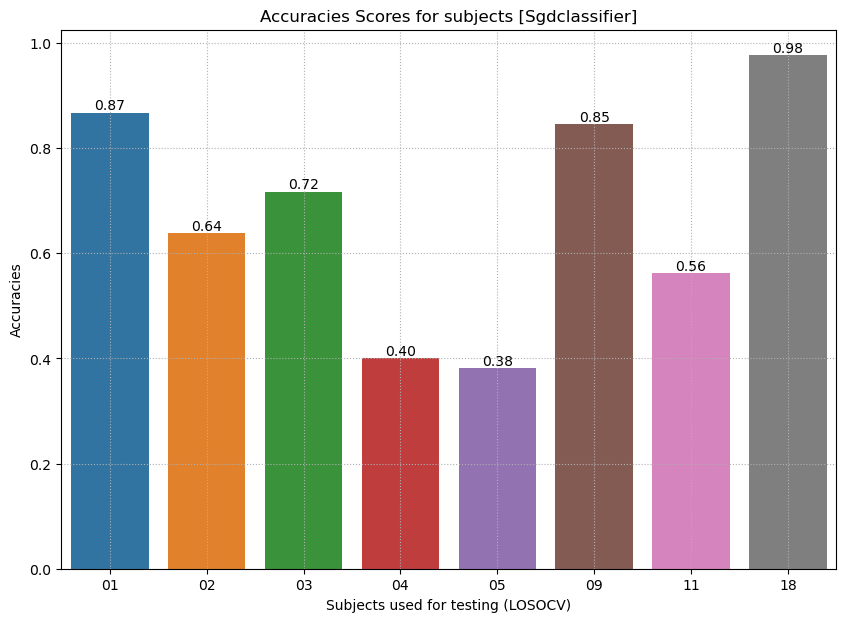

In [23]:
# Plotting individual metrics
plot_single_metric(classifier, results, 'accuracies')

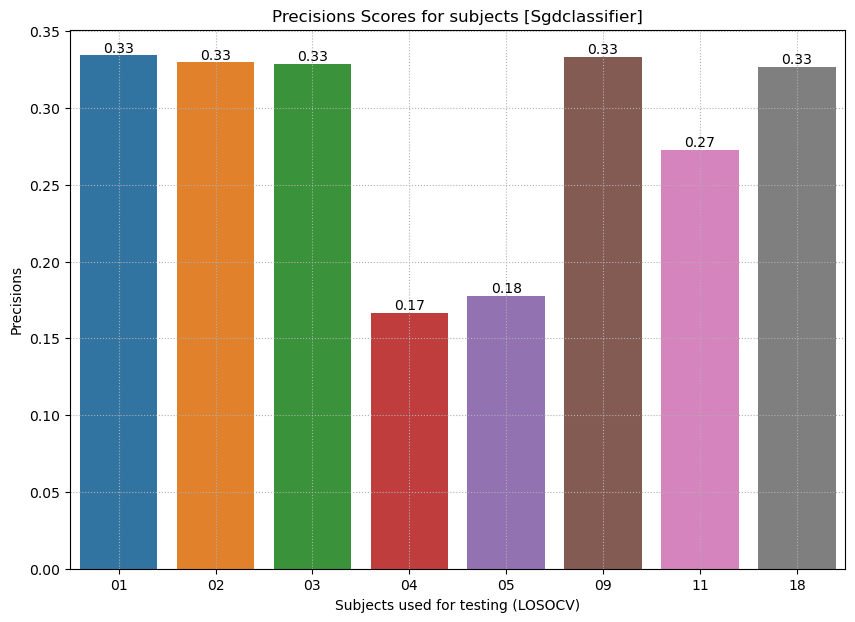

In [24]:
plot_single_metric(classifier, results, 'precisions')

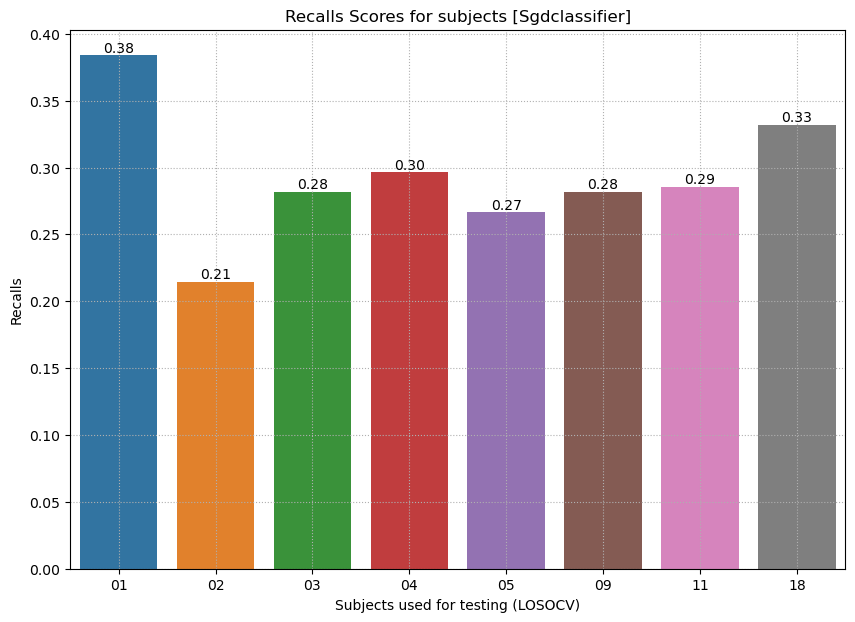

In [25]:
plot_single_metric(classifier, results, 'recalls')

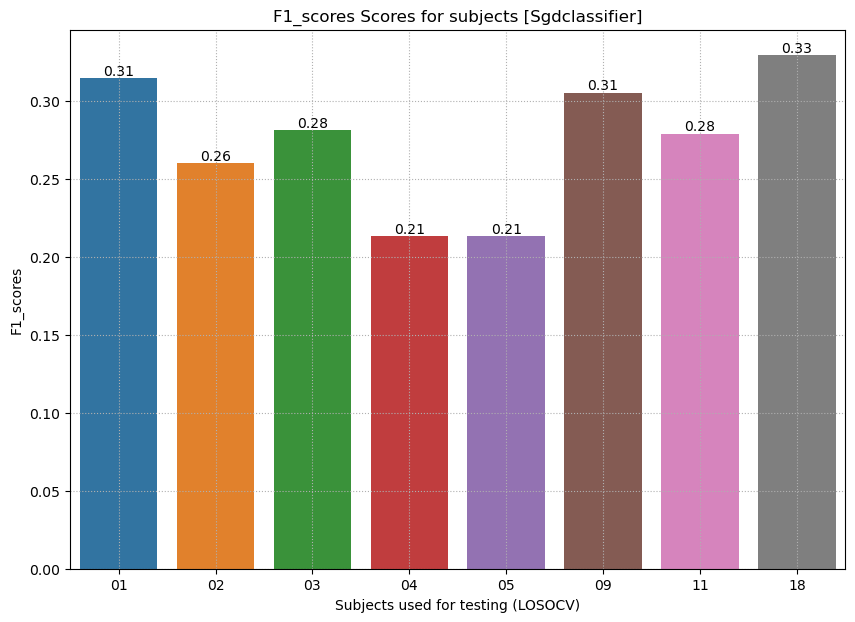

In [26]:
plot_single_metric(classifier, results, 'f1_scores')

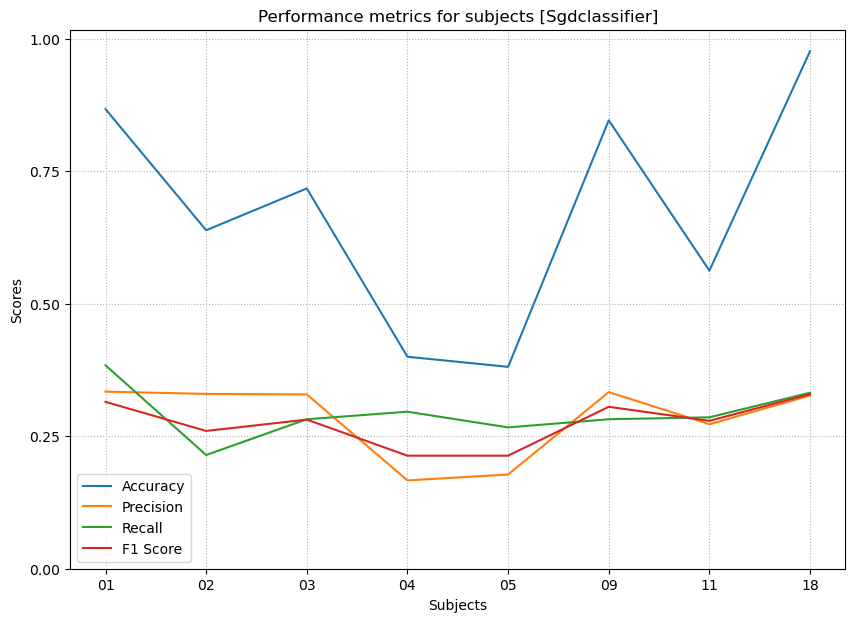

In [27]:
# Plotting all metrics in a single chart
plot_all_metrics(classifier, results, num_ticks=5)

## Inference on new subjects

In [28]:
def max_voting(predictions_list):
    # Convert the list of predictions into a numpy array for easier manipulation
    predictions_array = np.array(predictions_list)

    # Transpose the array to work with predictions of each sample across models
    transposed_array = np.transpose(predictions_array)

    # Create an empty list to store the final predictions
    final_predictions = []

    # Iterate through each sample's predictions
    for sample_predictions in transposed_array:
        # Calculate the mode (most frequent value) of predictions for each sample
        mode_prediction = np.argmax(np.bincount(sample_predictions.astype(int)))

        # Append the mode prediction to the final predictions list
        final_predictions.append(mode_prediction)

    return final_predictions

In [29]:
# Function to load model
def get_voting_ensemble(folder, model_names):
    
    models = []
    logger.info(f"Loading fitted models from {folder}. Fitted Models: {model_names}")
    for name in model_names:
        model = om.load_object(f"models/{folder}", f"{name}.pt")
        models.append(model)
        #models.append((f"{classifier}_{name}", model))
    
    #ensemble = VotingClassifier(estimators=models, voting='soft')
    
    return models #ensemble

# Function to run inference on subjects
def run_inference(ensemble, folder, filenames, features = [], normalize = True, sampling=False):
    metrics = {
    key: []
    for key in [
        Metrics.Accuracy.value,
        Metrics.Precision.value,
        Metrics.Recall.value,
        Metrics.F1.value,
        Metrics.Sample.value,
    ]
    }

    # Dictionary to store weighted avergae metrics
    weighted_avg_metrics = {}
    logger.info(f"Taking features: {features}")
    #Loop over csv files of each subject
    for file in filenames:
        #Load data
        x_test, y_test = dfm.load_data(file, data_folder, normalize, norm_method,features,sampling=False)
        
        y_preds = []
        
        # Evaluate the classifier on the current chunk
        for model in ensemble:
            y_pred = model.predict(x_test)
            y_preds.append(y_pred)
        
        # Get best predictions using max vote
        y_final = max_voting(y_preds)
        
        # Get evaluation metrics
        result = evaluate_metrics(y_test,y_pred)
        
        # Concat values
        metrics.update(result)
    
    
    # Calculate total number of samples
    total_samples = sum(metrics[Metrics.Sample.value])
    
    # Calculate the weighted average metrics
    
    for key, values in metrics.items():
        if key != Metrics.Sample.value:
            weighted_key_sum =  sum(val * count for val, count in zip(values, metrics[Metrics.Sample.value]))
            weighted_avg_metrics[key]= weighted_key_sum / total_samples
    
    logger.info("***"*20)
    logger.info(f"Inference Results:")
    for k, v in weighted_avg_metrics.items():
        logger.info(f"{k}:{v:.2f}")
            
    return weighted_avg_metrics

In [30]:
ensemble = get_voting_ensemble(folder, subjects)

2023-08-26 18:13:15 - INFO - Loading fitted models from 2023-08-26_18-10-35. Fitted Models: ['01', '02', '03', '04', '05', '09', '11', '18']


In [31]:
ensemble

[SGDClassifier(),
 SGDClassifier(),
 SGDClassifier(),
 SGDClassifier(),
 SGDClassifier(),
 SGDClassifier(),
 SGDClassifier(),
 SGDClassifier()]

In [32]:
inference_subjects = sorted(['07', '27', '15', '24', '22'])

In [33]:
infer_result = []

for test_subject in inference_subjects:
    logger.info("###"*10)
    logger.info(f"Running ensemble on test subject:{test_subject}")
    filenames = grouped_csv_files[test_subject]
    output = run_inference(ensemble, "stats", filenames, features = features, normalize = True)
    infer_result.append({test_subject:output})
    logger.info(f"Completed ensemble on test subject: {test_subject}")

2023-08-26 18:13:15 - INFO - ##############################
2023-08-26 18:13:15 - INFO - Running ensemble on test subject:07
2023-08-26 18:13:15 - INFO - Taking features: ['acc z_min', 'acc z_std', 'gyro x_25%', 'gyro x_75%', 'gyro x_max', 'gyro x_min', 'gyro x_std', 'gyro y_max', 'acc y_min', 'acc y_25%', 'acc y_mean', 'acc z_25%', 'gyro z_max', 'acc z_max', 'acc y_max']
2023-08-26 18:13:15 - INFO - Loading CSV File: OCDetect_07_recording_00_36b52ec7-be69-44fe-82d6-d7165abfdac1-stats.csv from stats.
2023-08-26 18:13:15 - INFO - ---------------
2023-08-26 18:13:15 - INFO - Total y_test:18
2023-08-26 18:13:15 - INFO - Total y_pred:18
2023-08-26 18:13:15 - INFO - Loading CSV File: OCDetect_07_recording_01_ba42ec72-01cd-4969-bcba-226869a3288e-stats.csv from stats.
2023-08-26 18:13:15 - INFO - ---------------
2023-08-26 18:13:15 - INFO - Total y_test:33
2023-08-26 18:13:15 - INFO - Total y_pred:33
2023-08-26 18:13:15 - INFO - Loading CSV File: OCDetect_07_recording_02_9c1649e7-f686-4d1b-91

2023-08-26 18:13:17 - INFO - ---------------
2023-08-26 18:13:17 - INFO - Total y_test:5373
2023-08-26 18:13:17 - INFO - Total y_pred:5373
2023-08-26 18:13:17 - INFO - Loading CSV File: OCDetect_15_recording_06_379f8edc-3110-4652-9711-01080dd12da8-stats.csv from stats.
2023-08-26 18:13:17 - INFO - ---------------
2023-08-26 18:13:17 - INFO - Total y_test:8674
2023-08-26 18:13:17 - INFO - Total y_pred:8674
2023-08-26 18:13:17 - INFO - Loading CSV File: OCDetect_15_recording_07_a0fdfa79-66f1-47b2-ace7-894be5516dcb-stats.csv from stats.
2023-08-26 18:13:17 - INFO - ---------------
2023-08-26 18:13:17 - INFO - Total y_test:3819
2023-08-26 18:13:17 - INFO - Total y_pred:3819
2023-08-26 18:13:17 - INFO - Loading CSV File: OCDetect_15_recording_08_976a4371-0312-4505-9541-0e1c3277163e-stats.csv from stats.
2023-08-26 18:13:17 - INFO - ---------------
2023-08-26 18:13:17 - INFO - Total y_test:34
2023-08-26 18:13:17 - INFO - Total y_pred:34
2023-08-26 18:13:17 - INFO - Loading CSV File: OCDetect

2023-08-26 18:13:18 - INFO - ---------------
2023-08-26 18:13:18 - INFO - Total y_test:515
2023-08-26 18:13:18 - INFO - Total y_pred:515
2023-08-26 18:13:18 - INFO - Loading CSV File: OCDetect_22_recording_15_4304c4e7-a57a-4d9a-9457-461da5ea9223-stats.csv from stats.
2023-08-26 18:13:18 - INFO - ---------------
2023-08-26 18:13:18 - INFO - Total y_test:180
2023-08-26 18:13:18 - INFO - Total y_pred:180
2023-08-26 18:13:18 - INFO - Loading CSV File: OCDetect_22_recording_16_03bb83be-110f-4043-821d-42c85053ef8d-stats.csv from stats.
2023-08-26 18:13:18 - INFO - ---------------
2023-08-26 18:13:18 - INFO - Total y_test:62
2023-08-26 18:13:18 - INFO - Total y_pred:62
2023-08-26 18:13:18 - INFO - Loading CSV File: OCDetect_22_recording_17_2a4fd805-e1d1-47e3-8b58-491256230e97-stats.csv from stats.
2023-08-26 18:13:18 - INFO - ---------------
2023-08-26 18:13:18 - INFO - Total y_test:72
2023-08-26 18:13:18 - INFO - Total y_pred:72
2023-08-26 18:13:18 - INFO - Loading CSV File: OCDetect_22_reco

2023-08-26 18:13:20 - INFO - ---------------
2023-08-26 18:13:20 - INFO - Total y_test:1761
2023-08-26 18:13:20 - INFO - Total y_pred:1761
2023-08-26 18:13:20 - INFO - Loading CSV File: OCDetect_27_recording_08_caa36b3a-89cf-40f0-9eaa-77acf36d28b4-stats.csv from stats.
2023-08-26 18:13:20 - INFO - ---------------
2023-08-26 18:13:20 - INFO - Total y_test:23
2023-08-26 18:13:20 - INFO - Total y_pred:23
2023-08-26 18:13:20 - INFO - Loading CSV File: OCDetect_27_recording_09_15b3d0c6-cc79-477b-9044-0301558478f1-stats.csv from stats.
2023-08-26 18:13:20 - INFO - ---------------
2023-08-26 18:13:20 - INFO - Total y_test:4245
2023-08-26 18:13:20 - INFO - Total y_pred:4245
2023-08-26 18:13:20 - INFO - Loading CSV File: OCDetect_27_recording_10_ef17b44d-6516-442c-b00f-cd26477abe65-stats.csv from stats.
2023-08-26 18:13:20 - INFO - ---------------
2023-08-26 18:13:20 - INFO - Total y_test:1163
2023-08-26 18:13:20 - INFO - Total y_pred:1163
2023-08-26 18:13:20 - INFO - Loading CSV File: OCDetect

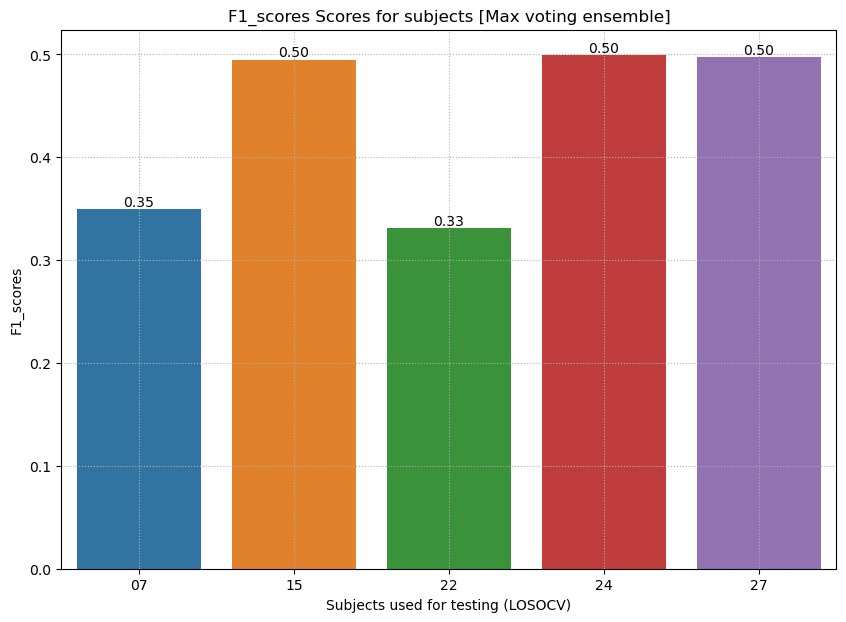

In [34]:
plot_single_metric("Max Voting Ensemble", infer_result, "f1_scores")

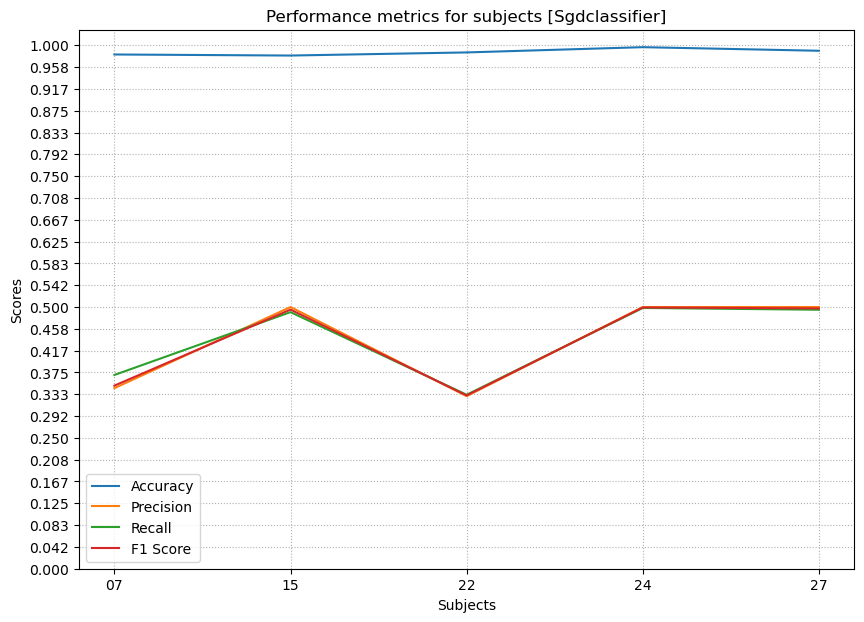

In [35]:
# Plotting all metrics in a single chart
plot_all_metrics(classifier, infer_result, num_ticks=25)